# TSLO Crowding & Microsaccades:

  This script is used to analyse and plot crowding and microsaccade data and to be able to understand the relationship   between the two.

In [28]:
%pylab inline
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time, sys
from IPython.display import clear_output
from scipy import stats
import scipy.stats
import scipy.optimize as opt
from scipy.stats import pearsonr
# %load_ext jupyternotify
from ipywidgets import interact,interactive,fixed,interact_manual
import ipywidgets as widgets
import pickle5 as pickle

Populating the interactive namespace from numpy and matplotlib


C:\Users\krish\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['interactive', 'diff', 'hist']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
#Progress bar function
def update_progress(progress):
    barLength = 100 # Modify this to change the length of the progress bar
    status = ""
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
        status = "error: progress var must be float\r\n"
    if progress < 0:
        progress = 0
        status = "Halt...\r\n"
    if progress >= 1:
        progress = 1
        status = "Done...\r\n"
    block = int(round(barLength*progress))
    text = "\rPercent: [{0}] {1}% {2}".format( "#"*block + "-"*(barLength-block), progress*100, status)
    sys.stdout.write(text)
    sys.stdout.flush()

In [3]:
#define F-test function
def f_test(x, y):
    x = np.array(x)
    y = np.array(y)
    f = np.var(x, ddof=1)/np.var(y, ddof=1) #calculate F test statistic 
    dfn = x.size-1 #define degrees of freedom numerator 
    dfd = y.size-1 #define degrees of freedom denominator 
    p = 1-scipy.stats.f.cdf(f, dfn, dfd) #find p-value of F test statistic 
    return f,p
# We have functions to convert proportion correct to z scores and vice versa
def ztop(z):
    p=0.5 * (1.0+scipy.special.erf(z/np.sqrt(2) ) )
    return p

def ptoz(p):
    if p==1:
        p=0.9999999
    elif p==0:
        p=0.0000001
    z=np.sqrt(2) * scipy.special.erfinv( 2*p-1.0)
    return z

def ptozM(p,M=10):
    if p==1:
        p=0.999999
    elif p==0:
        p=0.0001
    # from JEK Smith 1982. Checked to match tables of Hacker/Ratcliff
    K_M=0.86-0.085 * np.log(M-1)
    d=K_M*np.log( (M-1)*p/(1-p) )
    return d

# Function for getting bootstrapped zscores
def bootstrap_corr_to_z(df):
    num_boot=1000
    z_scores=[]
    for i in range(num_boot):
        resampled_df=df.sample(len(df),replace=True)
        zVal=ptozM(resampled_df.mean())
        z_scores.append(zVal)
    return z_scores

# Function for getting bootstrapped prop values from 0/1 correct/incorrect response list
def bootstrap_corr_to_propCor(df,num_boot=1000):
    propCor=[]
    for i in range(num_boot):
        resampled_df=df.sample(len(df),replace=True)
        propCor.append(resampled_df.mean())
    return propCor

## Perumutation Test
def perm_test(c,t,num_perm,method='mean',z_score=True,*args):
    k=[]
    # Look if there are additional groups passed in
    if len(args)>1:
        t1=args[0]
        t2=agrs[1]
                
    if method=='mean':
        if z_score==True:
            diff=(ptozM(np.mean(c))-ptozM(np.mean(t)))
        else:
            diff=((np.mean(c))-(np.mean(t)))
        z=np.concatenate([c,t])
        for i in range(num_perm):
            np.random.shuffle(z)
            # Since the number of samples in each group is unequal we would match the
            # distribution to the individual lengths of each data series
            if z_score==True:
                k.append((ptozM(np.mean(z[:int(len(c))])) - ptozM(np.mean(z[int(len(c)):]))))  
            else:
                k.append(((np.mean(z[:int(len(c))])) - (np.mean(z[int(len(c)):]))))  
    elif method=='ttest':
        # Compare between two sets of measures/data
        diff=stats.ttest_ind(c,t).statistic
        z=np.concatenate([c,t])
        for i in range(num_perm):
            np.random.shuffle(z)
            # Since the number of samples in each group is unequal we would match the
            # distribution to the individual lengths of each data series
            tval=stats.ttest_ind(z[:int(len(c))],z[int(len(c)):])
            k.append(tval.statistic)
        
    elif method=='ftest':
        for arg in args:
            t2=arg
        if 't2' in locals():
            # Compare between more than two sets of measures/data
            diff,p_val=stats.f_oneway(c,t,t2).statistic
            z=np.concatenate([c,t,t2])
            for i in range(num_perm):
                np.random.shuffle(z)
                # Since the number of samples in each group is unequal we would match the
                # distribution to the individual lengths of each data series
                g1=z[:int(len(c))]
                g2=z[int(len(c)):(int(len(c))+int(len(t)))]
                g3=z[(int(len(c))+int(len(t))):]
                fval=stats.f_oneway(g1,g2,g3).statistic
                k.append(fval)
        else:
            # Compare between  two sets of measures/data
            diff,p_val=f_test(c,t)
            z=np.concatenate([c,t])
            for i in range(num_perm):
                np.random.shuffle(z)
                # Since the number of samples in each group is unequal we would match the
                # distribution to the individual lengths of each data series
                g1=z[0:int(len(c))]
                g2=z[int(len(c))::]
                fval,p_val=f_test(g1,g2)
                k.append(fval)
        
    elif method=='friedman':
        # compare between two sets of measures/data
        diff=stats.friedmanchisquare(c,t,t1,t2).statistic
        z=np.concatenate([c,t,t1,t2])
        for i in range(num_perm):
            np.random.shuffle(z)
            # Since the number of samples in each group is unequal we would match the
            # distribution to the individual lengths of each data series
            len_df=len(c) # since lengths of groups are the same we use one of them
            g1=z[0:len_df]
            g2=z[len_df*1:len_df*2]
            g3=z[len_df*2:len_df*3]
            g4=z[len_df*3:len_df*4]
            friedman_test=stats.friedmanchisquare(g1,g2,g3,g4)
            k.append(friedman_test.statistic)
    if method=='mean':
        k=np.array(k)
        if diff>0: # when the original difference is positive
            p_value=len(np.where(k>=diff)[0])/num_perm
        elif diff<0: # when the original difference is negative
            p_value=len(np.where(k<=diff)[0])/num_perm
        elif diff==0 and np.mean(k)>0: # when the original difference is zero and distribution is positive
            p_value=len(np.where(k<=diff)[0])/num_perm
        elif diff==0 and np.mean(k)<0:# when the original difference is zero and distribution is negative
            p_value=len(np.where(k>=diff)[0])/num_perm
        else:# It wouldnt normally get here but just to prevent bugs
            p_value=1
    else: # all other test statistic
        if diff<np.mean(k):
            p_value=len(np.where(k<=diff)[0])/num_perm
        elif diff>np.mean(k):
            p_value=len(np.where(k>=diff)[0])/num_perm
    
    # check if p_value exists, if not assign it a high value
    if 'p_value' not in locals():
        print('UnboundLocalError')
        p_value=1
    
            
    return {"diff":diff,"k":k,'p_val':p_value}

In [29]:
# First we import the different dataframes created from the analysis protocols and also the behavioral data
if sys.platform=='win32':
        os.chdir("D:\KSP\Study\Houston\Projects\TSLOExperiments\TSLOData\CrowdingMOCS\MainExperiment\Data")
        #os.chdir("C:\TSLOData\Data")
elif sys.platform=='linux':
    os.chdir("/home/coateslab/LabData/TSLO_Experiment/CrowdingMOCS/TSLO_videos/crowding_microsaccade/AllData/Data/")
saccData=pd.read_csv('saccDataTrial.csv')
behavData=pd.read_csv("behavData.csv")
questDF=pd.read_csv('questDF.csv')
eyepos=pd.read_csv("eyeposTrial.csv")
driftData=pd.read_csv("driftDataTrial.csv")
stimData=pd.read_csv("stimData.csv")
eyepos_rel=pd.read_csv("eyepos_rel.csv")
eyepos_smoothed=pd.read_csv("eyepos_smoothed.csv")
#Load saccade dataframes from different filters
leftVrightData=pd.read_csv("leftVrightData.csv")
leftVrightData_single_msacc=pd.read_csv("single_microsaccade_df.csv")
leftVrightData_multiple_msacc=pd.read_csv("multiple_microsaccade_df.csv")
#Load the data for trials without microsaccades
noSaccDF=pd.read_csv("noSaccDF.csv")
#Binned data from entire dataset
BinnedData=pd.read_csv("BinnedData_2msStep_200msSize_finerTuning_Horz.csv")
BinnedPerfData_sacc=pd.read_csv("BinnedDataPerf_sacc_2msStep_200msSize.csv")
#Binned data from single saccade dataset
BinnedPerfData_single_sacc=pd.read_csv("BinnedDataPerf_sacc_single_microsaccade_10msStep_200msSize.csv")
BinnedData_single_sacc=pd.read_csv("BinnedData_single_microsaccade_10msStep_200msSize_finerTuning_Horz.csv")
#Binned data from trials with only more than on microsaccade
BinnedPerfData_multiple_sacc=pd.read_csv("BinnedDataPerf_sacc_multiple_microsaccade_10msStep_200msSize.csv")
BinnedData_multiple_sacc=pd.read_csv("BinnedData_multiple_microsaccades_10msStep_200msSize_finerTuning_Horz.csv")
#Binned data where we looked at saccade amplitude and performance
BinnedPerfData_bySaccadeAmp_sacc=pd.read_csv("BinnedDataPerf_bySaccadeAmp_50msStep_750msSize.csv")
# Binned Data where we grouped data based on saccade amplitude
BinnedPerfData_lower_sacc=pd.read_csv("BinnedDataPerf_sacc_lower_microsaccade_10msStep_200msSize.csv")
BinnedPerfData_upper_sacc=pd.read_csv("BinnedDataPerf_sacc_upper_microsaccade_10msStep_200msSize.csv")
BinnedPerfData_large_sacc=pd.read_csv("BinnedDataPerf_sacc_large_microsaccade_10msStep_200msSize.csv")
BinnedPerfData_small_sacc=pd.read_csv("BinnedDataPerf_sacc_small_microsaccade_10msStep_200msSize.csv")
p_val_df=pd.read_csv('p_val_df_perf.csv')
CS_df=pd.read_csv("CS_bootsrap_df.csv")
y_model_df=pd.read_csv("weibull_model_bootstrap_df.csv")
y_model_df_ecc=pd.read_csv("y_model_byecc.csv")
y_model_df_subj=pd.read_csv("y_model_df_subj.csv")
# relStimTime_df=pd.read_pickle('relStimTime_df.pkl')
# Convert critical spacing to log space
# CS_df['logCS']=np.log10(CS_df['CS'])
# The saccade directions range from -180 to +180 and uses the atan2d function in matlab. So to retrieve values that range between 0 and 360 we add 360 for values that
# are below 0
saccData['DirectionPolar']=0
for i in range(len(saccData)):
    if saccData['Direction'].iloc[i]<0:
        saccData['DirectionPolar'].iloc[i]=saccData['Direction'].iloc[i]+360
    else:
        saccData['DirectionPolar'].iloc[i]=saccData['Direction'].iloc[i]

# The behavioral data and saccade data are merged together
behavDataMerged=pd.merge(behavData,saccData,left_on='code',right_on='code')

C:\Users\krish\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (21) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\krish\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


# Proportion of microsaccade WRT stimulus onset
Additionally we look at the direction of microsaccades wrt stimulus onset
to see if there is a dissociation between the two

In [ ]:
a=leftVrightData.query("0<relOnsetTime<0.2").groupby(['ecc','spacing','subj_id_x'])['target'].count()
df2=a.reset_index()
df2['spacing_c']=df2.apply(lambda row: 'C'+str(row.spacing), axis=1)
df2['ecc_c']=df2.apply(lambda row: 'C'+str(row.ecc), axis=1)


In [ ]:
# g = sns.FacetGrid(df2, col="subj_id",hue='ecc_c')
# g=g.map(sns.lineplot, "spacing", "target",ci=None)
sns.lineplot(x='ecc_c',y='target',ci=95,data=df2,marker='o')
# plt.xscale('log')
# plt.yscale('log')
plt.legend()
plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0])
# plt.axvspan(stimStart, stimEnd, alpha=0.5, color='grey',label='Stimulus Window')
plt.xlim(-0.2,0.4)
plt.ylim(0,0.20)
plt.xlabel('Time relative to stimulus onset (s)',size=12)
plt.ylabel('Proportion of trials\n with microsaccades',size=12)
plt.legend(loc='best')
plt.tight_layout()

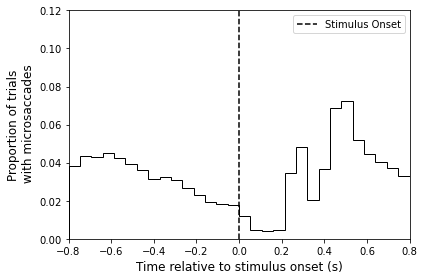

In [13]:
df1=leftVrightData.query("-0.8<relOnsetTime<0.8")
weights1 = np.ones_like(df1['relOnsetTime'])/float(len(df1['relOnsetTime']))
n, b, patches=plt.hist(df1['relOnsetTime'],weights=weights1,bins=30,histtype='step',ls='-',color='k')
plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0],label='Stimulus Onset')
# plt.axvspan(0, 0.100, alpha=0.5, color='grey',label='Stimulus Window')
plt.xlim(-0.8,0.8)
plt.ylim(0,0.12)
plt.xlabel('Time relative to stimulus onset (s)',size=12)
plt.ylabel('Proportion of trials\n with microsaccades',size=12)
plt.tight_layout()
plt.legend()
plt.savefig('..\Plots\MicrosaccadeRateVtime.pdf',format='pdf',dpi=1200)

In [18]:
# We do similar plots from data with single and only multiple saccades separately
#Single saccade
plt.figure()
df1=leftVrightData_single_msacc.query("-0.8<relOnsetTime<0.8")
weights1 = np.ones_like(df1['relOnsetTime'])/float(len(df1['relOnsetTime']))
n, b, patches=plt.hist(df1['relOnsetTime'],weights=weights1,bins=30,histtype='step',ls='-',color='k')
plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0],label='Stimulus Onset')
# plt.axvspan(0, 0.100, alpha=0.5, color='grey',label='Stimulus Window')
plt.xlim(-0.8,0.8)
plt.ylim(0,0.12)
plt.xlabel('Time relative to stimulus onset (s)',size=12)
plt.ylabel('Proportion of trials\n with microsaccades',size=12)
plt.title('Trials with single microsaccade')
plt.tight_layout()
plt.legend()

plt.figure()
df1=leftVrightData_multiple_msacc.query("-0.8<relOnsetTime<0.8")
weights1 = np.ones_like(df1['relOnsetTime'])/float(len(df1['relOnsetTime']))
n, b, patches=plt.hist(df1['relOnsetTime'],weights=weights1,bins=30,histtype='step',ls='-',color='k')
plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0],label='Stimulus Onset')
# plt.axvspan(0, 0.100, alpha=0.5, color='grey',label='Stimulus Window')
plt.xlim(-0.8,0.8)
plt.ylim(0,0.12)
plt.xlabel('Time relative to stimulus onset (s)',size=12)
plt.ylabel('Proportion of trials\n with microsaccades',size=12)
plt.title('Trials with multiple microsaccades')
plt.tight_layout()
plt.legend()

In [6]:
print(len(leftVrightData_single_msacc.query("-0.8<relOnsetTime<0.8")),len(leftVrightData_multiple_msacc.query("-0.8<relOnsetTime<0.8")),len(leftVrightData.query("-0.8<relOnsetTime<0.8")))

2831 29638 35806


In [ ]:
df=leftVrightData.query('-0.4<relOnsetTime<0.8')
g=sns.FacetGrid(data=df,col='ecc',hue='spacing')
g.map(sns.distplot,'relOnsetTime')
g.add_legend()
# plt.savefig('..\Plots\MicrosaccadeRateVtimeColEccHueSpacing.svg',format='svg',dpi=1200)

In [ ]:
df=leftVrightData.query('relOnsetTime<2')
num_bins=400

sns.distplot(df.query("spacing==100")['relOnsetTime'],bins=num_bins,kde=None,norm_hist=True, hist_kws={"histtype": "step", "linewidth": 1.25,
                            "alpha": 1, "color": "k"},label='100')
sns.distplot(df.query("spacing==5")['relOnsetTime'],bins=num_bins,kde=None,norm_hist=True, hist_kws={"histtype": "step", "linewidth": 1.25,
                            "alpha": 1, "color": "orange"},label='5')
sns.distplot(df.query("spacing==3")['relOnsetTime'],bins=num_bins,kde=None,norm_hist=True, hist_kws={"histtype": "step", "linewidth": 1.25,
                            "alpha": 1, "color": "green"},label='3')
sns.distplot(df.query("spacing==2")['relOnsetTime'],bins=num_bins,kde=None,norm_hist=True, hist_kws={"histtype": "step", "linewidth": 1.25,
                            "alpha": 1, "color": "red"},label='2')
sns.distplot(df.query("spacing==1.6")['relOnsetTime'],bins=num_bins,kde=None,norm_hist=True, hist_kws={"histtype": "step", "linewidth": 1.25,
                            "alpha": 1, "color": "blue"},label='1.6')
plt.xlim(0,0.5)
stimStart=0
stimEnd=0.100
plt.axvspan(stimStart, stimEnd, alpha=0.5, color='grey',label='Stimulus Window')
plt.xlabel('Time from stimulus onset (s)',size=12)
plt.ylabel('Proportion of trials\n with microsaccades',size=12)
plt.legend(loc='upper left')
plt.tight_layout()

In [ ]:
num_bins=200

sns.distplot(df.query("congruent==1 and spacing==2")['relOnsetTime'],bins=num_bins,kde=None,norm_hist=True, hist_kws={"histtype": "step", "linewidth": 1.25,
                            "alpha": 1, "color": "k"},label='Congruent')
sns.distplot(df.query("congruent==0 and spacing==2")['relOnsetTime'],bins=num_bins,kde=None,norm_hist=True, hist_kws={"histtype": "step", "linewidth": 1.25,
                            "alpha": 1, "color": "orange"},label='Incongruent')
plt.xlim(0,0.5)
plt.legend()

In [ ]:
#congruent condition
df1=leftVrightData.query("-0.2<relOnsetTime<0.4 and spacing_cond=='close'")
weights1 = np.ones_like(df1['relOnsetTime'])/float(len(df1['relOnsetTime']))
n, b, patches=plt.hist(df1['relOnsetTime'],weights=weights1,bins=30,histtype='step',ls='-',color='k',label='Crowded Trials')
#incongruenct condition
df2=leftVrightData.query("-0.2<relOnsetTime<0.4 and spacing_cond=='far'")
weights2 = np.ones_like(df2['relOnsetTime'])/float(len(df2['relOnsetTime']))
n, b, patches=plt.hist(df2['relOnsetTime'],weights=weights2,bins=30,histtype='step',ls='--',label='Uncrowded Trials')

plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0])
# plt.axvspan(stimStart, stimEnd, alpha=0.5, color='grey',label='Stimulus Window')
plt.xlim(-0.2,0.4)
# plt.ylim(0,0.20)
plt.xlabel('Time relative to stimulus onset (s)',size=12)
plt.ylabel('Proportion of trials\n with microsaccades',size=12)
plt.legend(loc='best')
plt.tight_layout()
# plt.savefig('TemporalModulationMicrosaccadebyCongruency.pdf')

# Behavioral performance V microsaccade

In [ ]:
timeWindow="0.2<relOnsetTime<0.3"
data=leftVrightData.query(timeWindow)
trialWsaccCode=data['trialCode'].unique()
trialWOsacc=behavData[~behavData.trialCode.isin(trialWsaccCode)]

In [ ]:
#TO DO: 
# incongruent effects identify saccades & subjtwise diff: Ones before and after stimulus onset have different effects
# look at individual spacing and ecc 

In [ ]:
sns.lineplot(x='spacing',y='corr',data=leftVrightData.query(timeWindow+" & congruent==1"),marker='o',color='green',label='Congruent Microsaccade between: %s'%(timeWindow))
sns.lineplot(x='spacing',y='corr',data=leftVrightData.query(timeWindow+" & congruent==0"),marker='o',color='red',label='Incongruent Microsaccade between: %s'%(timeWindow))
# sns.lineplot(x='spacing',y='corr',data=leftVrightData.query("-0.2<relOnsetTime<=0"),marker='o',label='Microsaccade between: -0.2 to 0 ms')
# sns.lineplot(x='spacing',y='corr',data=leftVrightData.query("0<relOnsetTime<=0.2"),marker='o',label='Microsaccade between: 0 to 0.2 ms')
sns.lineplot(x='spacing',y='corr',data=trialWOsacc,marker='o',label='No Microsaccade')
plt.legend(loc='lower right')
plt.xscale('log')
# plt.xlim(-0.PerfBinnedData_1msStep_50msSize.pklt.ylim(0.2,1)

In [ ]:
sns.lineplot(x='spacing',y='corr',data=leftVrightData.query("0<relOnsetTime<=0.2"),hue='congruent',marker='o')
sns.lineplot(x='spacing',y='corr',data=trialWOsacc,marker='o',label='No Microsaccade',color='k')
plt.legend(loc='lower right')
plt.xscale('log')
# plt.xlim(-0.PerfBinnedData_1msStep_50msSize.pklt.ylim(0.2,1)

In [ ]:
BinnedPerfData['meanPerf']=BinnedPerfData['meanPerf'].astype(float)

In [ ]:
timeWindow="-0.4<relOnsetTime<0.8"
data=leftVrightData.query(timeWindow)
trialWsaccCode=data['trialCode'].unique()
trialWOsacc=behavData[~behavData.trialCode.isin(trialWsaccCode)]
trialWOsacc['ecc_cond']=np.where((trialWOsacc['ecc']>3),'peripheral','parafoveal')
trialWOsacc['spacing_cond']=np.where((trialWOsacc['spacing']<=3),'close','far')

In [ ]:
p_val_df=pd.DataFrame(np.column_stack((bins,p_vals_cong,p_vals_perf,p_vals_amp)),columns=['bins','p_val_cong','p_val_perf','p_val_amp'])

In [ ]:
# We run permutation test for each time point/bin step 
bins=BinnedData.binPt.unique()
p_vals_perf=[]
idx=0
# loop through each bin
for abin in bins:
    print('%d/%d'%(idx,len(bins)-1),end='\r')
    idx+=1
    group1=BinnedPerfData.query("binPt==@abin and sacc_cond=='Sacc' and congruent=='1' & meanPerf<2")['meanPerf']
    group2=BinnedPerfData.query("binPt==@abin and sacc_cond=='Sacc' and congruent=='0' & meanPerf<2")['meanPerf']
    res=perm_test(group1,group2,10000,'mean',z_score=False)
    # append P val
    p_vals_perf.append(res['p_val'])

In [ ]:
plt.figure(figsize=(15,5))
# g=sns.FacetGrid(data=BinnedPerfData.query("sacc_cond=='Sacc'"),hue='congruent',col='spacing',height=4,aspect=1)
# g.map(sns.lineplot,"binPt","meanPerf")
sns.lineplot(x='binPt',y='zScore',ci=None,data=BinnedPerfData.query("sacc_cond=='Sacc'"),hue='congruent',style='spacing')
plt.legend(bbox_to_anchor=(1,1.01))
plt.grid()
# # replace labels
# g.add_legend(title='Microsaccade Congruency')
# new_labels = ['Incongruent', 'Congruent']
# for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

In [ ]:
def calc_z_from_p(df):
    zScore=ptozM(df.meanPerf)
    return zScore
BinnedPerfData['zScore']=(BinnedPerfData.apply(calc_z_from_p,1)).astype(float)

In [ ]:
df_grouped=df.groupby(['congruent','binPt'])['zScore'].mean().reset_index()


In [ ]:
df_grouped.binPt.unique()

In [ ]:
df_grouped_all=np.array(df_grouped.query("congruent=='1'")['zScore'])-np.array(df_grouped.query("congruent=='0'")['zScore'])

In [ ]:
df_grouped1_6=np.array(df_grouped.query("congruent=='1' and spacing<2")['zScore'])-np.array(df_grouped.query("congruent=='0' and spacing<2")['zScore'])
df_grouped2=np.array(df_grouped.query("congruent=='1' and spacing==2")['zScore'])-np.array(df_grouped.query("congruent=='0' and spacing==2")['zScore'])
df_grouped3=np.array(df_grouped.query("congruent=='1' and spacing==3")['zScore'])-np.array(df_grouped.query("congruent=='0' and spacing==3")['zScore'])
df_grouped5=np.array(df_grouped.query("congruent=='1' and spacing==5")['zScore'])-np.array(df_grouped.query("congruent=='0' and spacing==5")['zScore'])
df_grouped100=np.array(df_grouped.query("congruent=='1' and spacing==100")['zScore'])-np.array(df_grouped.query("congruent=='0' and spacing==100")['zScore'])

In [ ]:
plt.figure(figsize=(15,5))
xVals=df_grouped.binPt.unique()
plt.plot(xVals,df_grouped1_6,label='1.6')
plt.plot(xVals,df_grouped2,label='2')
plt.plot(xVals,df_grouped3,label='3')
plt.plot(xVals,df_grouped5,label='5')
plt.plot(xVals,df_grouped100,label='100')
plt.legend()
plt.grid()

In [ ]:
plt.figure(figsize=(15,5))
xVals=df_grouped.binPt.unique()
plt.plot(xVals,df_grouped_all)
plt.grid()

In [ ]:
df=df.query("sacc_cond=='Sacc'").sort_values(['spacing','congruent','zScore'])
df['zScoreDiff']=df.groupby(['spacing','congruent'])['zScore'].diff()

In [147]:
# Common permutation test for all conditions
# We run permutation test for each time point/bin step 
bins=BinnedData.binPt.unique()
binPtList=[]
p_vals_perf=[]
p_vals_cong=[]
idx=0
# loop through each bin
for abin in bins:
    print('%d/%d'%(idx,len(bins)-1),end='\r')
    idx+=1
    # Performance permutation test [By Congruency]
    group1_perf=np.array(BinnedPerfData_sacc.query("binPt==@abin and congruent==1 & corr<2")['corr'])
    group2_perf=np.array(BinnedPerfData_sacc.query("binPt==@abin and congruent==0 & corr<2")['corr'])
#     df1=bootstrap_corr_to_propCor(group1_perf,num_boot=100)
#     df2=bootstrap_corr_to_propCor(group2_perf,num_boot=100)
    res_perf=perm_test(group1_perf,group2_perf,1000,'mean',z_score=False)
    # append P val
    p_vals_perf.append(res_perf['p_val'])
    binPtList.append(abin)
p_val_df=pd.DataFrame(np.column_stack((binPtList,p_vals_perf)),columns=['binPt','p_val_perf'])

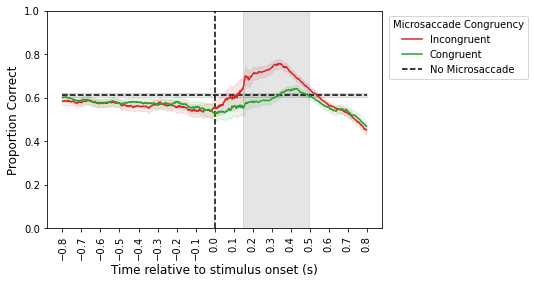

In [14]:
#### Incongruent Condition
df1_mean=BinnedPerfData_sacc.query("congruent==0").groupby(['binPt'])['corr'].mean().reset_index()
# Compute CI
df1_std=BinnedPerfData_sacc.query("congruent==0").groupby(['binPt'])['corr'].std().reset_index()
df1_count=BinnedPerfData_sacc.query("congruent==0").groupby(['binPt'])['corr'].count().reset_index()
ci1=1.96 * (df1_std['corr'])/np.sqrt(df1_count['corr']) 
x1=df1_std['binPt']
plt.plot(df1_mean['binPt'],df1_mean['corr'],label='Incongruent',color='C3')
plt.fill_between(x1,(df1_mean['corr']+ci1),(df1_mean['corr']-ci1),color='C3',alpha=0.1)

#Congruent Condition
df2_mean=BinnedPerfData_sacc.query("congruent==1").groupby(['binPt'])['corr'].mean().reset_index()
# Compute CI
df2_std=BinnedPerfData_sacc.query("congruent==1").groupby(['binPt'])['corr'].std().reset_index()
df2_count=BinnedPerfData_sacc.query("congruent==1").groupby(['binPt'])['corr'].count().reset_index()
x2=df2_std['binPt']
ci2=1.96 * (df2_std['corr'])/np.sqrt(df2_count['corr']) 
plt.plot(df2_mean['binPt'],df2_mean['corr'],label='Congruent',color='C2')
plt.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)

#No saccade condition
df3_mean=noSaccDF['corr'].mean()
# Compute CI
df3_std=noSaccDF['corr'].std()
df3_count=noSaccDF['corr'].count()
ci3=1.96 * (df3_std)/np.sqrt(df3_count) 
xvalues=np.linspace(-.8,0.8,5)
plt.hlines(xmin=-0.8,xmax=0.8,y=df3_mean,label='No Microsaccade',color='k',linestyle='--')
plt.fill_between(xvalues,(df3_mean+ci3),(df3_mean-ci3),color='k',alpha=0.1)

plt.vlines(0,ymin=0,ymax=1,linestyle='--',color=[0,0,0])
plt.legend(title='Microsaccade Congruency',bbox_to_anchor=(1.45,1))
plt.ylim(0,1)
plt.xticks(np.arange(-0.8,0.9,0.1),rotation=90)

plt.ylabel('Proportion Correct',size=12)
plt.xlabel('Time relative to stimulus onset (s)',size=12)

# we plot significance over this
p_vals_perf=p_val_df['p_val_perf'].values
bins=p_val_df['binPt'].values
alpha_lvl=0.001
start_bins=[]
end_bins=[]
got_one=0
for idx in range(len(p_vals_perf)):
    a_pval=p_vals_perf[idx]
    abin=bins[idx]
    if a_pval<alpha_lvl and got_one==0:
        start_bins.append(abin)
        got_one=1
    elif a_pval>alpha_lvl and got_one==1:
        end_bins.append(abin)
        got_one=0
# We plot between the start and end of the region where it is significant
start_pt=start_bins[0]
end_pt=end_bins[-1]
plt.fill_betweenx(y=[0,1],x1=start_pt,x2=end_pt,color=[0,0,0],alpha=0.1) 

plt.savefig('..\Plots\MicrosaccadeVbehavioralPerformance_hue_congruency.pdf',format='pdf',dpi=1200,bbox_inches='tight')

In [14]:
leftVrightData.groupby("congruent")['Duration'].count()

congruent
0    17866
1    17940
Name: Duration, dtype: int64

In [13]:
leftVrightData.query("0.150<relOnsetTime<0.496").groupby("congruent")['Duration'].count()

congruent
0    3477
1    5017
Name: Duration, dtype: int64

## We look at performance with microsaccades based on when they occur WRT stimulus across different conditions
 1. Look at difference between single and multiple microsaccades
 2. Difference between upper and lower half separated by median saccade amplitude
 3. Difference between large and small separarted by ones larger and smaller than 0.5 deg

### 1.

In [30]:
print("Percent single microsaccades: %.2f"%(len(leftVrightData_single_msacc)/len(leftVrightData)*100))

Percent single microsaccades: 8.94


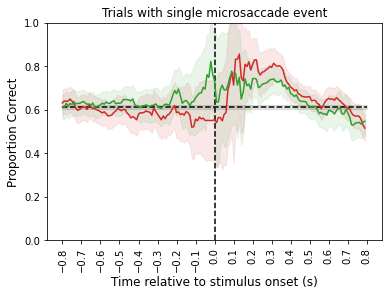

In [22]:
#### Incongruent Condition
df1_mean=BinnedPerfData_single_sacc.query("congruent==0").groupby(['binPt'])['corr'].mean().reset_index()
# Compute CI
df1_std=BinnedPerfData_single_sacc.query("congruent==0").groupby(['binPt'])['corr'].std().reset_index()
df1_count=BinnedPerfData_single_sacc.query("congruent==0").groupby(['binPt'])['corr'].count().reset_index()
ci1=1.96 * (df1_std['corr'])/np.sqrt(df1_count['corr']) 
x1=df1_std['binPt']
plt.plot(df1_mean['binPt'],df1_mean['corr'],label='Incongruent',color='C3')
plt.fill_between(x1,(df1_mean['corr']+ci1),(df1_mean['corr']-ci1),color='C3',alpha=0.1)

#Congruent Condition
df2_mean=BinnedPerfData_single_sacc.query("congruent==1").groupby(['binPt'])['corr'].mean().reset_index()
# Compute CI
df2_std=BinnedPerfData_single_sacc.query("congruent==1").groupby(['binPt'])['corr'].std().reset_index()
df2_count=BinnedPerfData_single_sacc.query("congruent==1").groupby(['binPt'])['corr'].count().reset_index()
x2=df2_std['binPt']
ci2=1.96 * (df2_std['corr'])/np.sqrt(df2_count['corr']) 
plt.plot(df2_mean['binPt'],df2_mean['corr'],label='Congruent',color='C2')
plt.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)

#No saccade condition
df3_mean=noSaccDF['corr'].mean()
# Compute CI
df3_std=noSaccDF['corr'].std()
df3_count=noSaccDF['corr'].count()
ci3=1.96 * (df3_std)/np.sqrt(df3_count) 
xvalues=np.linspace(-.8,0.8,5)
plt.hlines(xmin=-0.8,xmax=0.8,y=df3_mean,label='No Microsaccade',color='k',linestyle='--')
plt.fill_between(xvalues,(df3_mean+ci3),(df3_mean-ci3),color='k',alpha=0.1)

plt.vlines(0,ymin=0,ymax=1,linestyle='--',color=[0,0,0])
# plt.legend(title='Microsaccade Congruency',bbox_to_anchor=(1.45,1))
plt.ylim(0,1)
plt.xticks(np.arange(-0.8,0.9,0.1),rotation=90)

plt.ylabel('Proportion Correct',size=12)
plt.xlabel('Time relative to stimulus onset (s)',size=12)
plt.title("Trials with single microsaccade event")
plt.savefig('..\Plots\MicrosaccadeVbehavioralPerformance_hue_congruency_singleMicrosaccade.svg',format='svg',dpi=1200,bbox_inches='tight')

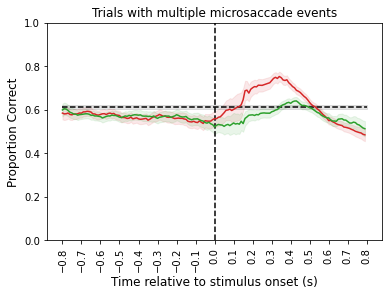

In [23]:
#### Incongruent Condition
df1_mean=BinnedPerfData_multiple_sacc.query("congruent==0").groupby(['binPt'])['corr'].mean().reset_index()
# Compute CI
df1_std=BinnedPerfData_multiple_sacc.query("congruent==0").groupby(['binPt'])['corr'].std().reset_index()
df1_count=BinnedPerfData_multiple_sacc.query("congruent==0").groupby(['binPt'])['corr'].count().reset_index()
ci1=1.96 * (df1_std['corr'])/np.sqrt(df1_count['corr']) 
x1=df1_std['binPt']
plt.plot(df1_mean['binPt'],df1_mean['corr'],label='Incongruent',color='C3')
plt.fill_between(x1,(df1_mean['corr']+ci1),(df1_mean['corr']-ci1),color='C3',alpha=0.1)

#Congruent Condition
df2_mean=BinnedPerfData_multiple_sacc.query("congruent==1").groupby(['binPt'])['corr'].mean().reset_index()
# Compute CI
df2_std=BinnedPerfData_multiple_sacc.query("congruent==1").groupby(['binPt'])['corr'].std().reset_index()
df2_count=BinnedPerfData_multiple_sacc.query("congruent==1").groupby(['binPt'])['corr'].count().reset_index()
x2=df2_std['binPt']
ci2=1.96 * (df2_std['corr'])/np.sqrt(df2_count['corr']) 
plt.plot(df2_mean['binPt'],df2_mean['corr'],label='Congruent',color='C2')
plt.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)

#No saccade condition
df3_mean=noSaccDF['corr'].mean()
# Compute CI
df3_std=noSaccDF['corr'].std()
df3_count=noSaccDF['corr'].count()
ci3=1.96 * (df3_std)/np.sqrt(df3_count) 
xvalues=np.linspace(-.8,0.8,5)
plt.hlines(xmin=-0.8,xmax=0.8,y=df3_mean,label='No Microsaccade',color='k',linestyle='--')
plt.fill_between(xvalues,(df3_mean+ci3),(df3_mean-ci3),color='k',alpha=0.1)

plt.vlines(0,ymin=0,ymax=1,linestyle='--',color=[0,0,0])
# plt.legend(title='Microsaccade Congruency',bbox_to_anchor=(1.45,1))
plt.ylim(0,1)
plt.xticks(np.arange(-0.8,0.9,0.1),rotation=90)

plt.ylabel('Proportion Correct',size=12)
plt.xlabel('Time relative to stimulus onset (s)',size=12)
plt.title("Trials with multiple microsaccade events")
plt.savefig('..\Plots\MicrosaccadeVbehavioralPerformance_hue_congruency_multipleMicrosaccades.svg',format='svg',dpi=1200,bbox_inches='tight')

In [159]:
leftVrightData_single_msacc.query("@start_pt<relOnsetTime<@end_pt").groupby('congruent')['corr'].count()


congruent
0    294
1    344
Name: corr, dtype: int64

In [158]:
leftVrightData_multiple_msacc.query("@start_pt<relOnsetTime<@end_pt").groupby('congruent')['corr'].count()


congruent
0    2822
1    4105
Name: corr, dtype: int64

### 2.

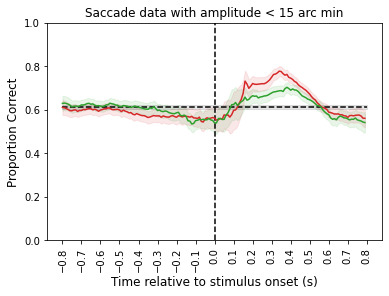

In [20]:
#### Incongruent Condition
df1_mean=BinnedPerfData_lower_sacc.query("congruent==0").groupby(['binPt'])['corr'].mean().reset_index()
# Compute CI
df1_std=BinnedPerfData_lower_sacc.query("congruent==0").groupby(['binPt'])['corr'].std().reset_index()
df1_count=BinnedPerfData_lower_sacc.query("congruent==0").groupby(['binPt'])['corr'].count().reset_index()
ci1=1.96 * (df1_std['corr'])/np.sqrt(df1_count['corr']) 
x1=df1_std['binPt']
plt.plot(df1_mean['binPt'],df1_mean['corr'],label='Incongruent',color='C3')
plt.fill_between(x1,(df1_mean['corr']+ci1),(df1_mean['corr']-ci1),color='C3',alpha=0.1)

#Congruent Condition
df2_mean=BinnedPerfData_lower_sacc.query("congruent==1").groupby(['binPt'])['corr'].mean().reset_index()
# Compute CI
df2_std=BinnedPerfData_lower_sacc.query("congruent==1").groupby(['binPt'])['corr'].std().reset_index()
df2_count=BinnedPerfData_lower_sacc.query("congruent==1").groupby(['binPt'])['corr'].count().reset_index()
x2=df2_std['binPt']
ci2=1.96 * (df2_std['corr'])/np.sqrt(df2_count['corr']) 
plt.plot(df2_mean['binPt'],df2_mean['corr'],label='Congruent',color='C2')
plt.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)

#No saccade condition
df3_mean=noSaccDF['corr'].mean()
# Compute CI
df3_std=noSaccDF['corr'].std()
df3_count=noSaccDF['corr'].count()
ci3=1.96 * (df3_std)/np.sqrt(df3_count) 
xvalues=np.linspace(-.8,0.8,5)
plt.hlines(xmin=-0.8,xmax=0.8,y=df3_mean,label='No Microsaccade',color='k',linestyle='--')
plt.fill_between(xvalues,(df3_mean+ci3),(df3_mean-ci3),color='k',alpha=0.1)

plt.vlines(0,ymin=0,ymax=1,linestyle='--',color=[0,0,0])
#plt.legend(title='Microsaccade Congruency',bbox_to_anchor=(1.45,1))
plt.ylim(0,1)
plt.xticks(np.arange(-0.8,0.9,0.1),rotation=90)

plt.ylabel('Proportion Correct',size=12)
plt.xlabel('Time relative to stimulus onset (s)',size=12)
plt.title("Saccade data with amplitude < 15 arc min")
plt.savefig('..\Plots\MicrosaccadeVbehavioralPerformance_hue_congruency_lowerHalfMicrosaccades.svg',format='svg',dpi=1200,bbox_inches='tight')

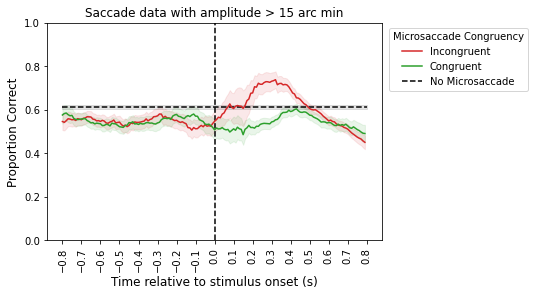

In [15]:
#### Incongruent Condition
df1_mean=BinnedPerfData_upper_sacc.query("congruent==0").groupby(['binPt'])['corr'].mean().reset_index()
# Compute CI
df1_std=BinnedPerfData_upper_sacc.query("congruent==0").groupby(['binPt'])['corr'].std().reset_index()
df1_count=BinnedPerfData_upper_sacc.query("congruent==0").groupby(['binPt'])['corr'].count().reset_index()
ci1=1.96 * (df1_std['corr'])/np.sqrt(df1_count['corr']) 
x1=df1_std['binPt']
plt.plot(df1_mean['binPt'],df1_mean['corr'],label='Incongruent',color='C3')
plt.fill_between(x1,(df1_mean['corr']+ci1),(df1_mean['corr']-ci1),color='C3',alpha=0.1)

#Congruent Condition
df2_mean=BinnedPerfData_upper_sacc.query("congruent==1").groupby(['binPt'])['corr'].mean().reset_index()
# Compute CI
df2_std=BinnedPerfData_upper_sacc.query("congruent==1").groupby(['binPt'])['corr'].std().reset_index()
df2_count=BinnedPerfData_upper_sacc.query("congruent==1").groupby(['binPt'])['corr'].count().reset_index()
x2=df2_std['binPt']
ci2=1.96 * (df2_std['corr'])/np.sqrt(df2_count['corr']) 
plt.plot(df2_mean['binPt'],df2_mean['corr'],label='Congruent',color='C2')
plt.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)

#No saccade condition
df3_mean=noSaccDF['corr'].mean()
# Compute CI
df3_std=noSaccDF['corr'].std()
df3_count=noSaccDF['corr'].count()
ci3=1.96 * (df3_std)/np.sqrt(df3_count) 
xvalues=np.linspace(-.8,0.8,5)
plt.hlines(xmin=-0.8,xmax=0.8,y=df3_mean,label='No Microsaccade',color='k',linestyle='--')
plt.fill_between(xvalues,(df3_mean+ci3),(df3_mean-ci3),color='k',alpha=0.1)

plt.vlines(0,ymin=0,ymax=1,linestyle='--',color=[0,0,0])
plt.legend(title='Microsaccade Congruency',bbox_to_anchor=(1.45,1))
plt.ylim(0,1)
plt.xticks(np.arange(-0.8,0.9,0.1),rotation=90)

plt.ylabel('Proportion Correct',size=12)
plt.xlabel('Time relative to stimulus onset (s)',size=12)
plt.title("Saccade data with amplitude > 15 arc min")
plt.savefig('..\Plots\MicrosaccadeVbehavioralPerformance_hue_congruency_upperHalfMicrosaccades.svg',format='svg',dpi=1200,bbox_inches='tight')

### 3.

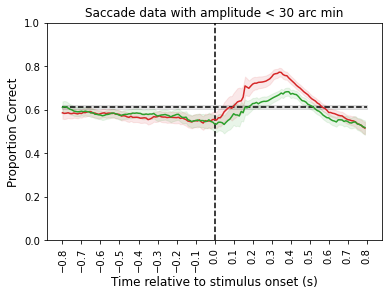

In [21]:
#### Incongruent Condition
df1_mean=BinnedPerfData_small_sacc.query("congruent==0").groupby(['binPt'])['corr'].mean().reset_index()
# Compute CI
df1_std=BinnedPerfData_small_sacc.query("congruent==0").groupby(['binPt'])['corr'].std().reset_index()
df1_count=BinnedPerfData_small_sacc.query("congruent==0").groupby(['binPt'])['corr'].count().reset_index()
ci1=1.96 * (df1_std['corr'])/np.sqrt(df1_count['corr']) 
x1=df1_std['binPt']
plt.plot(df1_mean['binPt'],df1_mean['corr'],label='Incongruent',color='C3')
plt.fill_between(x1,(df1_mean['corr']+ci1),(df1_mean['corr']-ci1),color='C3',alpha=0.1)

#Congruent Condition
df2_mean=BinnedPerfData_small_sacc.query("congruent==1").groupby(['binPt'])['corr'].mean().reset_index()
# Compute CI
df2_std=BinnedPerfData_small_sacc.query("congruent==1").groupby(['binPt'])['corr'].std().reset_index()
df2_count=BinnedPerfData_small_sacc.query("congruent==1").groupby(['binPt'])['corr'].count().reset_index()
x2=df2_std['binPt']
ci2=1.96 * (df2_std['corr'])/np.sqrt(df2_count['corr']) 
plt.plot(df2_mean['binPt'],df2_mean['corr'],label='Congruent',color='C2')
plt.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)

#No saccade condition
df3_mean=noSaccDF['corr'].mean()
# Compute CI
df3_std=noSaccDF['corr'].std()
df3_count=noSaccDF['corr'].count()
ci3=1.96 * (df3_std)/np.sqrt(df3_count) 
xvalues=np.linspace(-.8,0.8,5)
plt.hlines(xmin=-0.8,xmax=0.8,y=df3_mean,label='No Microsaccade',color='k',linestyle='--')
plt.fill_between(xvalues,(df3_mean+ci3),(df3_mean-ci3),color='k',alpha=0.1)

plt.vlines(0,ymin=0,ymax=1,linestyle='--',color=[0,0,0])
#plt.legend(title='Microsaccade Congruency',bbox_to_anchor=(1.45,1))
plt.ylim(0,1)
plt.xticks(np.arange(-0.8,0.9,0.1),rotation=90)

plt.ylabel('Proportion Correct',size=12)
plt.xlabel('Time relative to stimulus onset (s)',size=12)
plt.title("Saccade data with amplitude < 30 arc min")
plt.savefig('..\Plots\MicrosaccadeVbehavioralPerformance_hue_congruency_smallMicrosaccades.svg',format='svg',dpi=1200,bbox_inches='tight')

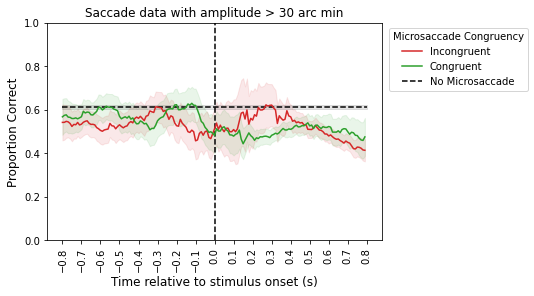

In [17]:
#### Incongruent Condition
df1_mean=BinnedPerfData_large_sacc.query("congruent==0").groupby(['binPt'])['corr'].mean().reset_index()
# Compute CI
df1_std=BinnedPerfData_large_sacc.query("congruent==0").groupby(['binPt'])['corr'].std().reset_index()
df1_count=BinnedPerfData_large_sacc.query("congruent==0").groupby(['binPt'])['corr'].count().reset_index()
ci1=1.96 * (df1_std['corr'])/np.sqrt(df1_count['corr']) 
x1=df1_std['binPt']
plt.plot(df1_mean['binPt'],df1_mean['corr'],label='Incongruent',color='C3')
plt.fill_between(x1,(df1_mean['corr']+ci1),(df1_mean['corr']-ci1),color='C3',alpha=0.1)

#Congruent Condition
df2_mean=BinnedPerfData_large_sacc.query("congruent==1").groupby(['binPt'])['corr'].mean().reset_index()
# Compute CI
df2_std=BinnedPerfData_large_sacc.query("congruent==1").groupby(['binPt'])['corr'].std().reset_index()
df2_count=BinnedPerfData_large_sacc.query("congruent==1").groupby(['binPt'])['corr'].count().reset_index()
x2=df2_std['binPt']
ci2=1.96 * (df2_std['corr'])/np.sqrt(df2_count['corr']) 
plt.plot(df2_mean['binPt'],df2_mean['corr'],label='Congruent',color='C2')
plt.fill_between(x2,(df2_mean['corr']+ci2),(df2_mean['corr']-ci2),color='C2',alpha=0.1)

#No saccade condition
df3_mean=noSaccDF['corr'].mean()
# Compute CI
df3_std=noSaccDF['corr'].std()
df3_count=noSaccDF['corr'].count()
ci3=1.96 * (df3_std)/np.sqrt(df3_count) 
xvalues=np.linspace(-.8,0.8,5)
plt.hlines(xmin=-0.8,xmax=0.8,y=df3_mean,label='No Microsaccade',color='k',linestyle='--')
plt.fill_between(xvalues,(df3_mean+ci3),(df3_mean-ci3),color='k',alpha=0.1)

plt.vlines(0,ymin=0,ymax=1,linestyle='--',color=[0,0,0])
plt.legend(title='Microsaccade Congruency',bbox_to_anchor=(1.45,1))
plt.ylim(0,1)
plt.xticks(np.arange(-0.8,0.9,0.1),rotation=90)

plt.ylabel('Proportion Correct',size=12)
plt.xlabel('Time relative to stimulus onset (s)',size=12)
plt.title("Saccade data with amplitude > 30 arc min")
plt.savefig('..\Plots\MicrosaccadeVbehavioralPerformance_hue_congruency_largeMicrosaccades.svg',format='svg',dpi=1200,bbox_inches='tight')

In [13]:
startPt=leftVrightData['VectorAmp'].min()
endPt=leftVrightData['VectorAmp'].max()
#Saccade Condition
df1_mean=BinnedPerfData_bySaccadeAmp_sacc.groupby(['binPt'])['corr'].mean().reset_index()
# Compute CI
df1_std=BinnedPerfData_bySaccadeAmp_sacc.groupby(['binPt'])['corr'].std().reset_index()
df1_count=BinnedPerfData_bySaccadeAmp_sacc.groupby(['binPt'])['corr'].count().reset_index()
ci1=1.96 * (df1_std['corr'])/np.sqrt(df1_count['corr']) 
x1=df1_std['binPt']
plt.plot(df1_mean['binPt'],df1_mean['corr'],label='Saccade Trials',color='C3')
plt.fill_between(x1,(df1_mean['corr']+ci1),(df1_mean['corr']-ci1),color='C3',alpha=0.1)

#No saccade condition
df3_mean=noSaccDF['corr'].mean()
# Compute CI
df3_std=noSaccDF['corr'].std()
df3_count=noSaccDF['corr'].count()
ci3=1.96 * (df3_std)/np.sqrt(df3_count)
min_amp=leftVrightData.VectorAmp.min()
max_amp=leftVrightData.VectorAmp.max()
xvalues=np.linspace(min_amp,max_amp,5)
plt.hlines(xmin=min_amp,xmax=max_amp,y=df3_mean,label='No Microsaccade',color='k',linestyle='--')
plt.fill_between(xvalues,(df3_mean+ci3),(df3_mean-ci3),color='k',alpha=0.1)

plt.legend(title='Microsaccade Condition',bbox_to_anchor=(1.45,1))
plt.ylim(0,1)

plt.ylabel('Proportion Correct',size=12)
plt.xlabel('Saccade Amplitude (deg)',size=12)
plt.savefig('..\Plots\MicrosaccadeVbehavioralPerformance_hue_saccadeCondition_bySaccadeAmp.svg',format='svg',dpi=1200,bbox_inches='tight')

In [ ]:
g=sns.FacetGrid(data=BinnedPerfData.query("sacc_cond=='Sacc'"),hue='congruent',height=4,aspect=1)
g.map(sns.lineplot,"binPt","meanPerf")
for ax in g.axes.flat:
    # we first get the data for the no microsaccade condition
    yVal=trialWOsacc.query("corr!='nan'")['corr']
    # We compute CI
    ci=sns.utils.ci(sns.algorithms.bootstrap(yVal))
    diff=np.abs(yVal.mean()-ci[0])
    min=plt.xlim()[0]
    max=plt.xlim()[1]
    ax.hlines(xmin=min,xmax=max,y=yVal.mean(),linestyle='--',color=[0,0,0])
    x=linspace(min,max,10)
    ax.vlines(0,ymin=0,ymax=1,linestyle='--',color=[0,0,0])
    y=np.repeat(yVal.mean(),len(x))
    ax.fill_between(x, (y-diff),(y+diff), color='b', alpha=.1)
# Make final tweaks to the plot
ax.set_ylim([0.2,1])
ax.set_ylabel('Mean Performance',size=12)
ax.set_xlabel('Time relative to stimulus onset (s)',size=12)
# replace labels
g.add_legend(title='Microsaccade Congruency')
new_labels = ['Incongruent', 'Congruent']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
# we plot significance over this
p_vals_perf=p_val_df['p_val'].values
bins=p_val_df['binPt'].values
p_vals_perf=p_val_df['p_val_perf_means'].values
bins=p_val_df['bins'].values
alpha_lvl=0.001
start_bins=[]
end_bins=[]
got_one=0
for idx in range(len(p_vals_perf)):
    a_pval=p_vals_perf[idx]
    abin=bins[idx]
    if a_pval<alpha_lvl and got_one==0:
        start_bins.append(abin)
        got_one=1
    elif a_pval>alpha_lvl and got_one==1:
        end_bins.append(abin)
        got_one=0
# We plot between the start and end of the region where it is significant
start_pt=start_bins[0]
end_pt=end_bins[-1]
plt.fill_betweenx(y=[0,1],x1=start_pt,x2=end_pt,color=[0,0,0],alpha=0.1)   
plt.xticks(np.arange(-0.8,1,0.2))
plt.ylim(0.2,1.0)
#Rotate labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)
# plt.savefig('..\Plots\MicrosaccadeVbehavioralPerformance_hue_congruencyNoSignificanceBars.svg',format='svg',dpi=1200,bbox_inches='tight')

In [ ]:
# Equal bin width method: 
# Cons: Every bin would have different number of samples/trials
#segregate by spacing
startPt=-0.300
stepSize=0.050#0.025
binSize=0.125#0.075
endPt=0.100
bins=np.arange(startPt,endPt,stepSize)
binWidth=binSize/2
subs=relStimTime_df['subj_id'].unique()
spacings=relStimTime_df['spacing'].unique()
nums=relStimTime_df['target'].unique()
congruencies=relStimTime_df['congruent'].unique()
eccs=[2,5]
counter=1
total_iter=len(bins)*len(subs)*len(eccs)*len(spacings)*len(nums) * len(congruencies)
# First for the performance df
binPtList=[]
spacingList=[]
eccList=[]
subList=[]
targetList=[]
congList=[]
#second we create lists for the outcome/microsaccade metrics
perfList=[]
countList=[]
for abin in bins:
    start=abin-binWidth
    end=abin+binWidth
    for asub in subs:
        for ecc in eccs:
            for aspacing in spacings:
                for anum in nums:
                    for acong in congruencies:
                        print("%d/%d"%(counter,total_iter),end='\r')
                        data=relStimTime_df.query("@start<relStimTime<@end & spacing==@aspacing & ecc==@ecc & subj_id==@asub & target==@anum & congruent==@acong")
                        mean=data['corr'].mean()
                        sd=data['corr'].std()
                        count=len(data)
                        # we add the metric to a separate list
                        perfList.append(mean)
                        countList.append(count)
                        # we append the experiment conditions
                        binPtList.append(abin)
                        spacingList.append(aspacing)
                        eccList.append(ecc)
                        subList.append(asub)
                        targetList.append(anum)
                        congList.append(acong)
                        counter+=1
                    
# We form the dataframe for the performance data                    
data=np.column_stack((binPtList,spacingList,eccList,subList,targetList,perfList,countList,congList))
binSacc=pd.DataFrame(data)
binSacc.columns=['binPt','spacing','ecc','subj_id','target','meanPerf','count','congruency']
# declare variable type
binSacc['binPt']=binSacc['binPt'].astype('float')
binSacc['target']=binSacc['target'].astype('float')
binSacc['ecc']=binSacc['ecc'].astype(int)
binSacc['spacing']=binSacc['spacing'].astype('float')
binSacc['meanPerf']=binSacc['meanPerf'].astype('float')
binSacc['count']=binSacc['count'].astype('float')
binSacc['congruency']=binSacc['congruency'].astype('int')
# we add another column to indicate the difficulty of the target presented
binSacc['target_difficulty']=np.where(((binSacc['target']==0) | (binSacc['target']==1) | (binSacc['target']==4) | (binSacc['target']==7)),'easy','difficult')

In [ ]:
sns.lineplot(x='binPt',y='meanPerf',hue='congruency',data=binSacc)

In [ ]:
timeWindow="-0.3<relStimTime<0.1"
data=relStimTime_df.query(timeWindow)
trialWsaccCode=data['trialCode'].unique()
trialWOsacc=behavData[~behavData.trialCode.isin(trialWsaccCode)]
trialWOsacc['ecc_cond']=np.where((trialWOsacc['ecc']>3),'peripheral','parafoveal')
trialWOsacc['spacing_cond']=np.where((trialWOsacc['spacing']<=3),'close','far')

binSacc['ecc_cond']=np.where((binSacc['ecc']>3),'peripheral','parafoveal')
binSacc['spacing_cond']=np.where((binSacc['spacing']<=3),'close','far')

g=sns.FacetGrid(data=binSacc,row='ecc_cond',col='spacing_cond',hue='congruency',height=4,aspect=1)
g.map(sns.lineplot,"binPt","meanPerf")
spacingList=['close','far','close','far']
eccList=['parafoveal','parafoveal','peripheral','peripheral']
axes = g.fig.axes
axCounter=0
for ax in axes:
    spacingVal=spacingList[axCounter]
    eccVal=eccList[axCounter]
    yVal=trialWOsacc.query("spacing_cond==@spacingVal & ecc_cond==@eccVal & corr<2")['corr']
    # We compute CI
    ci=sns.utils.ci(sns.algorithms.bootstrap(yVal,n_boot=1000))
    diff=np.abs(yVal.mean()-ci[0])
    min=ax.get_xlim()[0]
    max=ax.get_xlim()[1]
    ax.hlines(xmin=min,xmax=max,y=yVal.mean(),linestyle='--',color=[0,0,0])
    x=linspace(min,max,10)
    y=np.repeat(yVal.mean(),len(x))
    ax.fill_between(x, (y-diff),(y+diff), color='b', alpha=.1)
    axCounter+=1

In [ ]:
g=sns.FacetGrid(data=BinnedPerfData.query("sacc_cond=='Sacc'"),col='ecc_cond',hue='spacing_cond',size=4,aspect=1)
g.map(sns.lineplot,"binPt","meanPerf",ci=95)
g.axes[0,0].set_ylabel('Mean Performance',size=12)
g.axes[0,0].set_xlabel('')
g.axes[0,1].set_xlabel('')
g.axes[0,0].set_xlim([-0.8,0.8])
g.axes[0,1].set_xlim([-0.8,0.8])
g.axes[0,0].set_ylim([0.2,1])
g.axes[0,1].set_ylim([0.2,1])
ecc_conds=['parafoveal','peripheral']
spacing_conds=['close','far']
axCounter=0
for ax in g.axes.flat:
    anecc=ecc_conds[axCounter]
    ax.vlines(0,ymin=0,ymax=1,label='Stimulus Onset',linestyle='--',color=[0,0,0])
    for i in range(2):
        aspacing=spacing_conds[i]
        yVal=trialWOsacc.query("spacing_cond==@aspacing & ecc_cond==@anecc & corr!='nan'")['corr']
        # We compute CI
        ci=sns.utils.ci(sns.algorithms.bootstrap(yVal))
        diff=np.abs(yVal.mean()-ci[0])
        min=ax.get_xlim()[0]
        max=ax.get_xlim()[1]
        ax.hlines(xmin=min,xmax=max,y=yVal.mean(),linestyle='--',color=[0,0,0])
        x=linspace(min,max,10)
        y=np.repeat(yVal.mean(),len(x))
        if i==0:
            ax.fill_between(x, (y-diff),(y+diff), color='b', alpha=.1)
        else:
            ax.fill_between(x, (y-diff),(y+diff), color='orange', alpha=.1) 
    axCounter+=1
# Change column headers
for ax, title in zip(g.axes.flat, ['Target Eccentricity: Parafoveal','Target Eccentricity: Peripheral']):
    ax.set_title(title)
    
#change xlabel
g.fig.text(0.35,0,'Time relative to stimulus onset (s)',size=12)

g.fig.subplots_adjust(wspace=0.3, hspace=0)
g.add_legend(title='Flanker Spacing')
plt.savefig('..\Plots\MicrosaccadeVbehavioralPerformance_hue_spacing_col_eccentricity.svg',format='svg',dpi=1200)

In [ ]:
g=sns.FacetGrid(data=BinnedPerfData.query("sacc_cond=='Sacc'"),col='spacing',hue='congruent',size=4,aspect=1)
g.map(sns.lineplot,"binPt","meanPerf",ci=95)
g.axes[0,0].set_ylabel('Mean Performance',size=12)
g.axes[0,0].set_xlabel('')
g.axes[0,1].set_xlabel('')
g.axes[0,2].set_xlabel('')
g.axes[0,3].set_xlabel('')
g.axes[0,4].set_xlabel('')
g.axes[0,0].set_xlim([-0.8,0.8])
g.axes[0,1].set_xlim([-0.8,0.8])
g.axes[0,2].set_xlim([-0.8,0.8])
g.axes[0,3].set_xlim([-0.8,0.8])
g.axes[0,4].set_xlim([-0.8,0.8])
g.axes[0,0].set_ylim([0.2,1])
g.axes[0,1].set_ylim([0.2,1])
g.axes[0,2].set_ylim([0.2,1])
g.axes[0,3].set_ylim([0.2,1])
g.axes[0,4].set_ylim([0.2,1])
# ecc_conds=['parafoveal','peripheral']
spacing_conds=['close','far']
spacings=[1.6,2,3,5,100]
axCounter=0
for ax in g.axes.flat:
    aspacing=spacings[axCounter]
    ax.vlines(0,ymin=0,ymax=1,label='Stimulus Onset',linestyle='--',color=[0,0,0])
    yVal=trialWOsacc.query("spacing==@aspacing & corr!='nan'")['corr']
    # We compute CI
    ci=sns.utils.ci(sns.algorithms.bootstrap(yVal))
    diff=np.abs(yVal.mean()-ci[0])
    min=ax.get_xlim()[0]
    max=ax.get_xlim()[1]
    ax.hlines(xmin=min,xmax=max,y=yVal.mean(),linestyle='--',color=[0,0,0])
    x=linspace(min,max,10)
    y=np.repeat(yVal.mean(),len(x))
    if i==0:
        ax.fill_between(x, (y-diff),(y+diff), color='b', alpha=.1)
    else:
        ax.fill_between(x, (y-diff),(y+diff), color='orange', alpha=.1) 
    axCounter+=1
# Change column headers
for ax, title in zip(g.axes.flat, ['Target Spacing: 1.6x','Target Spacing: 2x','Target Spacing: 3x','Target Spacing: 5x','Target Spacing: Unflanked']):
    ax.set_title(title)
    
#change xlabel
g.fig.text(0.35,0,'Time relative to stimulus onset (s)',size=12)

g.fig.subplots_adjust(wspace=0.3, hspace=0)
g.add_legend(title='Microsaccade Congruency')
# replace labels
new_labels = ['Incongruent', 'Congruent']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
    
plt.savefig('..\Plots\MicrosaccadeVbehavioralPerformance_hue_congruency_col_spacing.svg',format='svg',dpi=1200)

In [ ]:
g=sns.FacetGrid(data=BinnedPerfData.query("sacc_cond=='Sacc'"),col='spacing_cond',hue='congruent',size=4,aspect=1)
g.map(sns.lineplot,"binPt","meanPerf",ci=95)
g.axes[0,0].set_ylabel('Mean Performance',size=12)
g.axes[0,0].set_xlabel('')
g.axes[0,1].set_xlabel('')
g.axes[0,0].set_xlim([-0.8,0.8])
g.axes[0,1].set_xlim([-0.8,0.8])
g.axes[0,0].set_ylim([0.2,1])
g.axes[0,1].set_ylim([0.2,1])

# ecc_conds=['parafoveal','peripheral']
spacing_conds=['close','far']
axCounter=0
for ax in g.axes.flat:
    aspacing=spacing_conds[axCounter]
    ax.vlines(0,ymin=0,ymax=1,label='Stimulus Onset',linestyle='--',color=[0,0,0])
    yVal=trialWOsacc.query("spacing_cond==@aspacing & corr!='nan'")['corr']
    # We compute CI
    ci=sns.utils.ci(sns.algorithms.bootstrap(yVal))
    diff=np.abs(yVal.mean()-ci[0])
    min=ax.get_xlim()[0]
    max=ax.get_xlim()[1]
    ax.hlines(xmin=min,xmax=max,y=yVal.mean(),linestyle='--',color=[0,0,0])
    x=linspace(min,max,10)
    y=np.repeat(yVal.mean(),len(x))
    if i==0:
        ax.fill_between(x, (y-diff),(y+diff), color='b', alpha=.1)
    else:
        ax.fill_between(x, (y-diff),(y+diff), color='orange', alpha=.1) 
    axCounter+=1
#Change column headers
for ax, title in zip(g.axes.flat, ['Target Spacing: Close','Target Spacing: Far']):
    ax.set_title(title)
    
#change xlabel
g.fig.text(0.35,0,'Time relative to stimulus onset (s)',size=12)

g.fig.subplots_adjust(wspace=0.3, hspace=0)
g.add_legend(title='Microsaccade Congruency')
# replace labels
new_labels = ['Incongruent', 'Congruent']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
#Move legend position
leg=g._legend
leg.set_bbox_to_anchor([1,0.5])
plt.savefig('..\Plots\MicrosaccadeVbehavioralPerformance_hue_congruency_col_spacing_cond.svg',format='svg',dpi=1200)

In [ ]:
#  2. Columns: Eccentricity 
#microsacadde condition
withSaccData=BinnedPerfData.query("sacc_cond=='Sacc'")
ecc_conds=['parafoveal','peripheral']
#No microsaccade condition
noSaccData=BinnedPerfData.query("sacc_cond=='NoSacc'")
counter=1
for anecc in range(1,6):
#     plt.figure(figsize=(10,20))
    withSaccTemp=withSaccData.query("ecc==@anecc & spacing_cond=='far'")
    noSaccTemp=noSaccData.query("ecc==@anecc & spacing_cond=='far'")
    plt.subplot(1,5,counter)
    ax1=sns.lineplot(x='binPt',y='meanPerf',ci=95,data=withSaccTemp)
    noSaccTemp.query("ecc==@anecc & spacing_cond=='far'").groupby('binPt')['meanPerf'].mean().plot(color='darkblue',ls='--',label='_nolegend_')
    plt.axvline(0, 0.0, C='k',ls='--')
    plt.title("Ecc: %d"%(anecc))
    if counter!=1:
        plt.xlabel('')
    plt.xlim(-0.2,0.2)
#     plt.ylim(0,1)
    counter+=1
plt.gcf().subplots_adjust(wspace=0.8)
# plt.savefig('PerformanceEccColHueSpacing.pdf')

In [ ]:
data=saccBins.query("congruent=='Incongruent'")
g = sns.FacetGrid(data, col="subj")
g=g.map(sns.lineplot, "binPt", "meanPerf",ci=95,markers=True)
axes = g.fig.axes
for ax in axes:
    ax.axvline(0, 0.0, C='k',ls='--')
plt.xlim(-0.2,0.2)
# plt.ylim(0.5,1)
# plt.savefig('PerformanceVBinsHueSubj.pdf')

In [ ]:
trialWsaccList=saccData['trialCode'].unique()
trialWOsaccList=behavData[~behavData.trialCode.isin(trialWsaccList)]['trialCode']
nosacc=behavData[~behavData.trialCode.isin(trialWsaccList)]

In [ ]:
df=saccBins.query('spacing==100')
nosacc=behavData[~behavData.trialCode.isin(trialWsaccList)].query('spacing==100')
noSaccdf=pd.DataFrame()
noSaccdf['binPt']=saccBins['binPt'].unique()
plt.figure()
sns.lineplot(x='binPt',y='meanPerf',data=df,ci=95)
plt.axhline(xmin=0,xmax=1,y=nosacc['corr'].mean(),c='k',ls='--')


In [ ]:
trialWsaccList=saccData['trialCode'].unique()
trialWOsaccList=behavData[~behavData.trialCode.isin(trialWsaccList)]['trialCode']
nosacc=behavData[~behavData.trialCode.isin(trialWsaccList)]
yval=nosacc['corr'].mean()
yerr=nosacc['corr'].std()

g = sns.FacetGrid(saccBins, col="congruent")
g=g.map(sns.lineplot, "binPt", "meanPerf",ci=95,markers=True)
axes = g.fig.axes
for ax in axes:
    ax.axvline(0, 0.0, C='k',ls='--')
    ax.axhline(xmin=0,xmax=1,y=nosacc['corr'].mean(),c='k',ls='--')


In [ ]:
data=BinnedPerfData.query("sacc_cond=='Sacc'")#.query("congruent!='No Microsaccade' & spacing==100")
g = sns.FacetGrid(data, col="ecc")
g=g.map(sns.lineplot, "binPt", "meanPerf",ci=95,markers=True)

# Size threshold V Eccentricity
Here we show the size thresholds acheived from the quest method and the performance as a function of flanker spacing for the different eccentricities tested

In [5]:
data=questDF
questDF['MAR']=questDF['size']/5
sns.pointplot(x='ecc',y='MAR',hue='subj_id',data=questDF,markers='o',linestyles='-')
plt.xlabel('Eccentricity (deg)',size=12)
plt.ylabel('MAR (min)',size=12)
plt.legend(title='Subject ID')
# plt.savefig('.\Plots\Prelim\SizeVeccbySubj.pdf')

# Psychometric function

Currently we have the following set of fit types/functions set up:
1. Exponential Fit
2. Weibull Fit

In [7]:
# GENERAL EQUATION ------------------------------------------------------------
#1. We use an exponential fit
#2. Or we use a weibull fit
def func(x, A, c, d):
    return A*np.exp(c*x) + d
# Wikipedia Weibull CDF https://en.wikipedia.org/wiki/Weibull_distribution
def func_weibull(x,lamb,k,lr):
    guess=0.1
    weibull_cdf=(1-np.exp(- (x/lamb)**k) )
    yval=guess+(1.0-guess-lr)*weibull_cdf
    return yval

In [ ]:
subj='S01'
for anecc in range(1,6):
    data=behavData.query("subj_id==@subj & ecc==@anecc")
    #get samples
    x_all = data['spacing'].unique()
#     x_all.sort()
    y_all = data.groupby('spacing')['corr'].mean().values
    x_samp=x_all#[:-1]
    x_samp.sort()
    y_samp=y_all#[:-1]
    y_samp.sort()

    # REGRESSION ------------------------------------------------------------------
    p0 = [3.5, 2,0.05] #weibull                                       # guessed params
#     p0=[-1.5,-1,1] # exponential
    w, _ = opt.curve_fit(func_weibull, x_samp, y_samp, p0=p0)     
    print("Estimated Parameters", w)  

    # Model
    x_lin=np.linspace(0,6,50) # we move the unflanked one to 6th pos to make it look nice
    y_model = func_weibull(x_lin, *w)

    # PLOT ------------------------------------------------------------------------
    # Visualize data and fitted curves

    plt.plot(x_samp[:-1], y_samp[:-1], "ko",label=anecc,marker=markerType,color=colorType)
    plt.plot(6,y_all[-1], "ko",marker=markerType,color=colorType)
    plt.plot(x_lin, y_model, "--",color=colorType)
    plt.title("%s"%(subj))
    plt.ylabel("Proportion Correct",size=12)
    plt.xlabel("Flanker Spacing (nominal)",size=12)
    plt.legend(loc="best",title='Eccentricity')
    plt.ylim(0,1.0)
    xticklabels=['0','1','2','3','4','5','Unflanked']
    plt.xticks([0,1,2,3,4,5,6],xticklabels)
# plt.savefig('..\Plots\PerformanceVSpacing%s_weibullFit.svg'%(subj),format='svg',dpi=1200)

In [18]:
leftVrightData.query(saccWindow).groupby(["congruent",'subj_id_x'])['Duration'].count()

congruent  subj_id_x
0          S01          1234
           S02           155
           S03          1393
           S04            79
           S05           616
1          S01          1315
           S02           332
           S03          1705
           S04           180
           S05          1485
Name: Duration, dtype: int64

In [10]:
# we do the same thing as earlier but for each subject individually and create a df with critical spacings
# First step is to get a function
# Have a function that pulls in the X & Y values from df, fits the data and get the Critical spacing
def fit_and_get_CS(df,x_lin):
    # First sort the x & y values from the DF
    x_all=df['spacing'].unique()
    y_all=df.groupby('spacing')['corr'].mean().values
    x_all.sort()
    y_all.sort()
    #optimize fit 
    w,_=opt.curve_fit(func_weibull,x_all,y_all,p0=p0,bounds=(0,[10,10,0.05]),maxfev=10000)
    # model fit
    y_model=func_weibull(x_lin,*w)
    # Compute Critical Spacing (CS)
    CS=np.interp(0.75*np.max(y_model), y_model,x_lin)
    # Also add interpolated 50% of asymptotic level
    fifty_percent_interp=np.interp(0.50*np.max(y_model), y_model,x_lin)
    # return the paramters
    return w,y_model,CS,fifty_percent_interp
# we first create the empty arrays that will be filling inside the loop
y_model_cong_list=np.array([])
y_model_incong_list=np.array([])
y_model_nosacc_list=np.array([])
x_lin_list=np.array([])
CS_cong_list=np.array([])
CS_incong_list=np.array([])
CS_nosacc_list=np.array([])
CS_ecc_list=np.array([])
ecc_array=np.array([])
sub_array=np.array([])
# Create an empty df and fill inside loop
subjs=behavData['subj_id'].unique()
counter=1
ecc_list=behavData.ecc.unique()
# for asub in subs:
for anecc in ecc_list:
    print('%d/%d'%(counter,5),end='\r')
    # This plots the psychometric function in trials with and without microsaccades independently
    # First we declare the data/trials with congruent microsaccades
    #saccWindow="@start_pt<relOnsetTime<@end_pt & subj_id_x==@asub "
    saccWindow="@start_pt<relOnsetTime<@end_pt"
    dataWsaccCong=leftVrightData.query(saccWindow+" & congruent==1 & corr!='NaN' & ecc==@anecc") # to fix cases where the rel onset time is really big
    # second we declare the data/trials with incongruent microsaccades
    dataWsaccIncong=leftVrightData.query(saccWindow+" & congruent==0  & corr!='NaN' & ecc==@anecc") # to fix cases where the rel onset time is really big
    # third we declare data/trials without microsaccades
    noSaccWindow="@start_pt<relOnsetTime<@end_pt "
    data=leftVrightData.query(noSaccWindow)
    trialWsaccCode=data['trialCode'].unique()
    trialWOsaccRaw=behavData[~behavData.trialCode.isin(trialWsaccCode)]
    trialWOsacc=trialWOsaccRaw.query(" corr!='NaN' & ecc==@anecc")

    # We use bootstrapping procedure for each getting the fit for each resampled data 
    for resample_idx in range(1000):
        #1. Resample DF
        new_df_saccCong = dataWsaccCong.sample(n=len(dataWsaccCong),replace=True)
        new_df_saccIncong=dataWsaccIncong.sample(n=len(dataWsaccIncong),replace=True)
        new_df_nosacc=trialWOsacc.sample(n=len(trialWOsacc),replace=True)
        # Weibull function fit ------------------------------------------------------------------
        p0 = [1,1,0.05] #weibull guessed params
        # Model
        unflanked_position=7
        x_lin=np.linspace(0,unflanked_position,50)
        w1,y_model_sacc_cong,CS_cong,fifty_percent_interp_cong = fit_and_get_CS(new_df_saccCong,x_lin)
        w2,y_model_sacc_incong,CS_incong,fifty_percent_interp_incong = fit_and_get_CS(new_df_saccIncong,x_lin)
        w3,y_model_nosacc,CS_nosacc,fifty_percent_interp_nosacc=fit_and_get_CS(new_df_nosacc,x_lin)

        # Finally we save it to a DF
        y_model_cong_list=np.concatenate((y_model_cong_list,y_model_sacc_cong),axis=None)
        y_model_incong_list=np.concatenate((y_model_incong_list,y_model_sacc_incong),axis=None)
        y_model_nosacc_list=np.concatenate((y_model_nosacc_list,y_model_nosacc),axis=None)
        x_lin_list=np.concatenate((x_lin_list,x_lin),axis=None)
        ecc_array=np.concatenate((ecc_array,np.repeat(anecc,len(y_model_sacc_cong))))
        # Also create a separate list for CS measure
        CS_cong_list=np.concatenate((CS_cong_list,CS_cong),axis=None)
        CS_incong_list=np.concatenate((CS_incong_list,CS_incong),axis=None)
        CS_nosacc_list=np.concatenate((CS_nosacc_list,CS_nosacc),axis=None)
        CS_ecc_list=np.concatenate((CS_ecc_list,anecc),axis=None)
        #sub_array=np.concatenate((sub_array,np.repeat(asub,len(y_model_sacc_cong))))
    counter+=1
        
#create individual df's and append together
# Model DF
y_model_df_nosacc=pd.DataFrame((np.column_stack((x_lin_list,y_model_nosacc_list,ecc_array))),columns=['x_lin','y_model','ecc'])
y_model_df_nosacc['microsaccade_condition']='no_saccade'
y_model_df_cong=pd.DataFrame((np.column_stack((x_lin_list,y_model_cong_list,ecc_array))),columns=['x_lin','y_model','ecc'])
y_model_df_cong['microsaccade_condition']='congruent'
y_model_df_incong=pd.DataFrame((np.column_stack((x_lin_list,y_model_incong_list,ecc_array))),columns=['x_lin','y_model','ecc'])
y_model_df_incong['microsaccade_condition']='incongruent'
frames=[y_model_df_incong,y_model_df_cong,y_model_df_nosacc]
y_model_df_ecc=pd.concat(frames)
y_model_df_ecc['x_lin']=y_model_df_ecc['x_lin'].astype('float')
y_model_df_ecc['y_model']=y_model_df_ecc['y_model'].astype('float')
y_model_df_ecc['ecc']=y_model_df_ecc['ecc'].astype('int')

CS_df=pd.DataFrame((np.column_stack((CS_cong_list,CS_incong_list,CS_nosacc_list,CS_ecc_list))),columns=['CS_cong','CS_incong','CS_nosacc','ecc'])

In [165]:
y_model_df_ecc.to_csv("y_model_byecc.csv")

In [9]:
# we do the same thing as earlier but for each subject individually and create a df with critical spacings
# First step is to get a function
# Have a function that pulls in the X & Y values from df, fits the data and get the Critical spacing
def fit_and_get_CS(df,x_lin):
    # First sort the x & y values from the DF
    x_all=df['spacing'].unique()
    y_all=df.groupby('spacing')['corr'].mean().values
    x_all.sort()
    y_all.sort()
    #optimize fit 
    w,_=opt.curve_fit(func_weibull,x_all,y_all,p0=p0,bounds=(0,[10,10,0.05]),maxfev=10000)
    # model fit
    y_model=func_weibull(x_lin,*w)
    # Compute Critical Spacing (CS)
    CS=np.interp(0.75*np.max(y_model), y_model,x_lin)
    # Also add interpolated 50% of asymptotic level
    fifty_percent_interp=np.interp(0.50*np.max(y_model), y_model,x_lin)
    # return the paramters
    return w,y_model,CS,fifty_percent_interp
# we first create the empty arrays that will be filling inside the loop
y_model_cong_list=np.array([])
y_model_incong_list=np.array([])
y_model_nosacc_list=np.array([])
x_lin_list=np.array([])
CS_cong_list=np.array([])
CS_incong_list=np.array([])
CS_nosacc_list=np.array([])
ecc_array=np.array([])
sub_array=np.array([])
# Create an empty df and fill inside loop
subs=behavData['subj_id'].unique()
counter=1
ecc_list=behavData.ecc.unique()
for asub in subs:
    for anecc in ecc_list:
        print('%d/%d'%(counter,25),end='\r')
        # This plots the psychometric function in trials with and without microsaccades independently
        # First we declare the data/trials with congruent microsaccades
        saccWindow="@start_pt<relOnsetTime<@end_pt & subj_id_x==@asub "
        #saccWindow="@start_pt<relOnsetTime<@end_pt"
        dataWsaccCong=leftVrightData.query(saccWindow+" & congruent==1 & corr!='NaN' & ecc==@anecc") # to fix cases where the rel onset time is really big
        # second we declare the data/trials with incongruent microsaccades
        dataWsaccIncong=leftVrightData.query(saccWindow+" & congruent==0  & corr!='NaN' & ecc==@anecc") # to fix cases where the rel onset time is really big
        # third we declare data/trials without microsaccades
        noSaccWindow="@start_pt<relOnsetTime<@end_pt "
        data=leftVrightData.query(noSaccWindow)
        trialWsaccCode=data['trialCode'].unique()
        trialWOsaccRaw=behavData[~behavData.trialCode.isin(trialWsaccCode)]
        trialWOsacc=trialWOsaccRaw.query("subj_id==@asub & corr!='NaN' & ecc==@anecc")
        try:
            # We use bootstrapping procedure for each getting the fit for each resampled data 
            for resample_idx in range(1000):
                #1. Resample DF
                new_df_saccCong = dataWsaccCong.sample(n=len(dataWsaccCong),replace=True)
                new_df_saccIncong=dataWsaccIncong.sample(n=len(dataWsaccIncong),replace=True)
                new_df_nosacc=trialWOsacc.sample(n=len(trialWOsacc),replace=True)
                # Weibull function fit ------------------------------------------------------------------
                p0 = [1,1,0.05] #weibull guessed params
                # Model
                unflanked_position=7
                x_lin=np.linspace(0,unflanked_position,50)
                w1,y_model_sacc_cong,CS_cong,fifty_percent_interp_cong = fit_and_get_CS(new_df_saccCong,x_lin)
                w2,y_model_sacc_incong,CS_incong,fifty_percent_interp_incong = fit_and_get_CS(new_df_saccIncong,x_lin)
                w3,y_model_nosacc,CS_nosacc,fifty_percent_interp_nosacc=fit_and_get_CS(new_df_nosacc,x_lin)

                # Finally we save it to a DF
                y_model_cong_list=np.concatenate((y_model_cong_list,y_model_sacc_cong),axis=None)
                y_model_incong_list=np.concatenate((y_model_incong_list,y_model_sacc_incong),axis=None)
                y_model_nosacc_list=np.concatenate((y_model_nosacc_list,y_model_nosacc),axis=None)
                x_lin_list=np.concatenate((x_lin_list,x_lin),axis=None)
        #         CS_cong_list=np.concatenate((CS_cong_list,CS_cong),axis=None)
        #         CS_incong_list=np.concatenate((CS_incong_list,CS_incong),axis=None)
        #         CS_nosacc_list=np.concatenate((CS_nosacc_list,CS_nosacc),axis=None)
                ecc_array=np.concatenate((ecc_array,np.repeat(anecc,len(y_model_sacc_cong))))
                sub_array=np.concatenate((sub_array,np.repeat(asub,len(y_model_sacc_cong))))
            counter+=1
        except:
            print('Fit error occurred',end='\r')
        
#create individual df's and append together
# Model DF
y_model_df_nosacc=pd.DataFrame((np.column_stack((x_lin_list,y_model_nosacc_list,ecc_array,sub_array))),columns=['x_lin','y_model','ecc','subj'])
y_model_df_nosacc['microsaccade_condition']='no_saccade'
y_model_df_cong=pd.DataFrame((np.column_stack((x_lin_list,y_model_cong_list,ecc_array,sub_array))),columns=['x_lin','y_model','ecc','subj'])
y_model_df_cong['microsaccade_condition']='congruent'
y_model_df_incong=pd.DataFrame((np.column_stack((x_lin_list,y_model_incong_list,ecc_array,sub_array))),columns=['x_lin','y_model','ecc','subj'])
y_model_df_incong['microsaccade_condition']='incongruent'
frames=[y_model_df_incong,y_model_df_cong,y_model_df_nosacc]
y_model_df_subj=pd.concat(frames)
y_model_df_subj['x_lin']=y_model_df_subj['x_lin'].astype('float')
y_model_df_subj['y_model']=y_model_df_subj['y_model'].astype('float')
y_model_df_subj['ecc']=y_model_df_subj['ecc'].astype('float')

C:\Users\krish\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [8]:
# This plots the psychometric function in trials with and without microsaccades independently
# Set whether or not to use bootstrap fit
bootstrap_fit=True
# First we declare the data/trials with congruent microsaccades
saccWindow="@start_pt<relOnsetTime<@end_pt"
dataWsaccCong=leftVrightData.query(saccWindow+" & congruent==1") # to fix cases where the rel onset time is really big
#get samples
x_all = dataWsaccCong['spacing'].unique()
#     x_all.sort()
y_all = dataWsaccCong.groupby('spacing')['corr'].mean().values
x_sacc_cong=x_all#[:-1]
x_sacc_cong.sort()
y_sacc_cong=y_all#[:-1]
y_sacc_cong.sort()

# second we declare the data/trials with incongruent microsaccades
dataWsaccIncong=leftVrightData.query(saccWindow+" & congruent==0") # to fix cases where the rel onset time is really big
#get samples
x_all = dataWsaccIncong['spacing'].unique()
#     x_all.sort()
y_all = dataWsaccIncong.groupby('spacing')['corr'].mean().values
x_sacc_incong=x_all#[:-1]
x_sacc_incong.sort()
y_sacc_incong=y_all#[:-1]
y_sacc_incong.sort()

# Second we declare data/trials without microsaccades
noSaccWindow="@start_pt<relOnsetTime<@end_pt"#"-0.4<relOnsetTime<0.8"
data=leftVrightData.query(noSaccWindow)
trialWsaccCode=data['trialCode'].unique()
trialWOsacc=behavData[~behavData.trialCode.isin(trialWsaccCode)]
#get samples
x_all = trialWOsacc['spacing'].unique()
#     x_all.sort()
y_all = trialWOsacc.groupby('spacing')['corr'].mean().values
x_nosacc=x_all#[:-1]
x_nosacc.sort()
y_nosacc=y_all#[:-1]
y_nosacc.sort()


# REGRESSION ------------------------------------------------------------------
p0 = [3.5, 2,0.05] #weibull                                       # guessed params
#     p0=[-1.5,-1,1] # exponential
w1, _ = opt.curve_fit(func_weibull, x_sacc_cong, y_sacc_cong, p0=p0)
w2, _ = opt.curve_fit(func_weibull, x_sacc_incong, y_sacc_incong, p0=p0)
w3,_= opt.curve_fit(func_weibull, x_nosacc, y_nosacc, p0=p0)
print("Estimated Parameters:Congruent", w1)  
print("Estimated Parameters:Incongruent", w2)  
print("Estimated Parameters:No Saccade", w3)  

unflanked_position=10
# Model
x_lin=np.linspace(0,unflanked_position+1,50) # we move the unflanked one to 6th pos to make it look nice
y_model_sacc_cong = func_weibull(x_lin, *w1)
y_model_sacc_incong = func_weibull(x_lin, *w2)
y_model_nosacc=func_weibull(x_lin,*w3)

fig,(ax,ax2)=plt.subplots(1,2,sharey=True,gridspec_kw={'width_ratios': [3, 1]})

## First we do the plot on the left/All flanked data
#plot congruent microsaccade condition
ax.plot(x_sacc_cong[:-1], y_sacc_cong[:-1],ls='',marker='v',color='C2',label='Trials W congruent microsaccade')
ax.plot(unflanked_position,y_sacc_cong[-1], marker='v',color='C2')
if bootstrap_fit==True:
    sns.lineplot(x='x_lin',y='y_model',color='C2',ci='sd',data=y_model_df.query("microsaccade_condition=='congruent'"),ax=ax)
else:
    ax.plot(x_lin,y_model_sacc_cong,ls='--',color='C2')

# plot incongruent microsaccade condition
ax.plot(x_sacc_incong[:-1], y_sacc_incong[:-1],ls='',marker='*',color='C3',label='Trials W Incongruent microsaccade')
ax.plot(unflanked_position,y_sacc_incong[-1], marker='*',color='C3')
if bootstrap_fit==True:
    sns.lineplot(x='x_lin',y='y_model',color='C3',ci='sd',data=y_model_df.query("microsaccade_condition=='incongruent'"),ax=ax)
else:
    ax.plot(x_lin,y_model_sacc_incong,ls='--',color='C3')

#plot no saccade condtion
ax.plot(x_nosacc[:-1], y_nosacc[:-1],ls='',marker='o',color='k',label='Trials W/O microsaccade')
ax.plot(unflanked_position,y_nosacc[-1],marker='o',color='k')
if bootstrap_fit==True:
    sns.lineplot(x='x_lin',y='y_model',color='k',ci='sd',data=y_model_df.query("microsaccade_condition=='no_saccade'"),ax=ax)
else:
    ax.plot(x_lin,y_model_nosacc,ls='--',color='k')
    
## Next we do the plot on the right/ Just the unflanked data
#model
ax2.plot(x_sacc_cong[:-1], y_sacc_cong[:-1],ls='',marker='v',color='C2',label='Trials W congruent microsaccade')
ax2.plot(unflanked_position,y_sacc_cong[-1], marker='v',color='C2')
if bootstrap_fit==True:
    sns.lineplot(x='x_lin',y='y_model',color='C2',ci='sd',data=y_model_df.query("microsaccade_condition=='congruent'"),ax=ax2)
else:
    ax2.plot(x_lin,y_model_sacc_cong,ls='--',color='C2')

# plot incongruent microsaccade condition
ax2.plot(x_sacc_incong[:-1], y_sacc_incong[:-1],ls='',marker='*',color='C3',label='Trials W Incongruent microsaccade')
ax2.plot(unflanked_position,y_sacc_incong[-1], marker='*',color='C3')
if bootstrap_fit==True:
    sns.lineplot(x='x_lin',y='y_model',color='C3',ci='sd',data=y_model_df.query("microsaccade_condition=='incongruent'"),ax=ax2)
else:
    ax2.plot(x_lin,y_model_sacc_incong,ls='--',color='C3')

#plot no saccade condtion
ax2.plot(x_nosacc[:-1], y_nosacc[:-1],ls='',marker='o',color='k',label='Trials W/O microsaccade')
ax2.plot(unflanked_position,y_nosacc[-1],marker='o',color='k')
if bootstrap_fit==True:
    sns.lineplot(x='x_lin',y='y_model',color='k',ci='sd',data=y_model_df.query("microsaccade_condition=='no_saccade'"),ax=ax2)
else:
    ax2.plot(x_lin,y_model_nosacc,ls='--',color='k')
    
## We then zoom in to different portions on each plot
ax.set_xlim(0,7.5)
ax2.set_xlim(7.5,11)

# hide the spines between ax and ax2
ax.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
# ax.yaxis.tick_left()
ax2.yaxis.tick_right()
ax2.tick_params(right=False)
ax.get_legend().remove()
ax2.get_legend().remove()
ax.xaxis.label.set_visible(False)
ax2.xaxis.label.set_visible(False)

# Make the spacing between the two axes a bit smaller
plt.subplots_adjust(wspace=0.05)

# Add the '//' to indicate axis break
ax.text(7.52,-0.015,'//')
ax.text(7.52,0.985,'//')

#plot tweaks
ax2.legend(title='Microsaccade condition',bbox_to_anchor=(-1.15,0.4))
ax.set_ylabel("Proportion Correct",size=12)
# plt.xlabel("Flanker Spacing (nominal)",size=12)
fig.text(0.5,0.01,"Flanker Spacing (nominal)",size=12,ha='center')
ax.set_ylim(0,1)
ax2.set_ylim(0,1)
# xticklabels=['0','1','2','3','4','5','6']
# ax.set_xticks([0,1,2,3,4,5,6],xticklabels)
ax.set_xticks([1,2,3,4,5,6])
ax.set_xticklabels(['1','2','3','4','5','6'])
ax2.set_xticks([8,10])
ax2.set_xticklabels(['8','Unflanked'])
# # We compute critical spacings and mark them on the plot
if bootstrap_fit==True:
    df_incong= y_model_df.query("microsaccade_condition=='incongruent'").groupby('x_lin')['y_model'].mean().reset_index()
    cs_incong=(np.interp(0.75,  df_incong['y_model'], df_incong['x_lin']))
    df_cong=y_model_df.query("microsaccade_condition=='congruent'").groupby('x_lin')['y_model'].mean().reset_index()
    cs_cong=(np.interp(0.75, df_cong['y_model'], df_cong['x_lin']))
    df_nosacc=y_model_df.query("microsaccade_condition=='no_saccade'").groupby('x_lin')['y_model'].mean().reset_index()
    cs_nosacc=(np.interp(0.75,  df_nosacc['y_model'], df_nosacc['x_lin']))
else:
    cs_incong=(np.interp(0.75, y_model_sacc_incong,x_lin))
    cs_cong=(np.interp(0.75, y_model_sacc_cong,x_lin))
    cs_nosacc=(np.interp(0.75, y_model_nosacc,x_lin))
ax.hlines(y=0.75,xmin=0,xmax=cs_nosacc,color='k',linestyle='--',alpha=0.1)
ax.axvline(x=cs_incong,ymin=0,ymax=0.75,linestyle='--',color='C3')
ax.axvline(x=cs_cong,ymin=0,ymax=0.75,linestyle='--',color='C2')
ax.axvline(x=cs_nosacc,ymin=0,ymax=0.75,linestyle='--',color='k')
print("Incongruent:%.2f,Congruent:%.2f,NoSaccade:%.2f"%(cs_incong,cs_cong,cs_nosacc))
# plt.title("Microsaccade query conditions: %s"%(saccWindow))
# plt.title('Trials with microsaccades between 154 to 414 ms after stimulus onset',size=10)
if bootstrap_fit==True:
    plt.savefig('..\Plots\psychometricFunction_%dto%dms_bootStrapFit.svg'%(start_pt*1000,end_pt*1000),format='svg',dpi=1200)    
else:
    plt.savefig('..\Plots\psychometricFunction_150to464ms.svg',format='svg',dpi=1200,bbox_tight='inches')

Estimated Parameters:Congruent [3.02158018 1.93589014 0.09036084]
Estimated Parameters:Incongruent [2.54436323 2.02954158 0.06989421]
Estimated Parameters:No Saccade [3.0750626  1.66711106 0.13092001]
Incongruent:3.10,Congruent:4.02,NoSaccade:4.47


In [18]:
print(np.interp(0.75, y_model_sacc_incong,x_lin))
print(np.interp(0.75, y_model_sacc_cong,x_lin))
print(np.interp(0.75, y_model_nosacc,x_lin))

3.0304275423957905
3.940492750851657
4.428499913358064


C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:150: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_tight" which is no longer supported as of 3.3 and will become an error two minor releases later


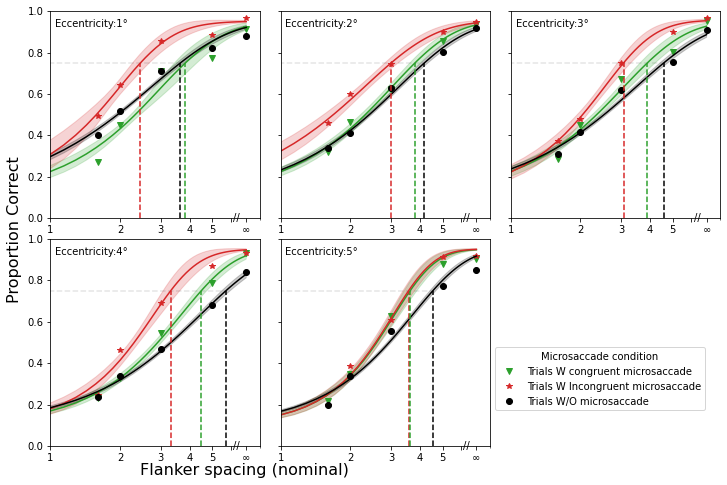

In [12]:
import matplotlib.patches as patches
# This plots the psychometric function in trials with and without microsaccades independently
# Set whether or not to use bootstrap fit
bootstrap_fit=True
fig,ax=plt.subplots(nrows=2,ncols=3,figsize=(12,8),sharey=True)
eccs_list=leftVrightData.ecc.unique()
ecc_counter=0
# First we declare the data/trials with congruent microsaccades
saccWindow="@start_pt<relOnsetTime<@end_pt"
# We save CS values to a seperate DF
cs_list=np.array([])
cs_cond_list=np.array([])
ecc_cond=np.array([])
for col in ax:
    for row in col:
        if ecc_counter!=5:
            anecc=eccs_list[ecc_counter]

            dataWsaccCong=leftVrightData.query(saccWindow+" & congruent==1 & ecc==@anecc") # to fix cases where the rel onset time is really big
            #get samples
            x_all = dataWsaccCong['spacing'].unique()
            #     x_all.sort()
            y_all = dataWsaccCong.groupby('spacing')['corr'].mean().values
            x_sacc_cong=x_all#[:-1]
            x_sacc_cong.sort()
            y_sacc_cong=y_all#[:-1]
            y_sacc_cong.sort()

            # second we declare the data/trials with incongruent microsaccades
            dataWsaccIncong=leftVrightData.query(saccWindow+" & congruent==0 & ecc==@anecc") # to fix cases where the rel onset time is really big
            #get samples
            x_all = dataWsaccIncong['spacing'].unique()
            #     x_all.sort()
            y_all = dataWsaccIncong.groupby('spacing')['corr'].mean().values
            x_sacc_incong=x_all#[:-1]
            x_sacc_incong.sort()
            y_sacc_incong=y_all#[:-1]
            y_sacc_incong.sort()

            # Second we declare data/trials without microsaccades
            noSaccWindow="@start_pt<relOnsetTime<@end_pt"#"-0.4<relOnsetTime<0.8"
            data=leftVrightData.query(noSaccWindow)
            trialWsaccCode=data['trialCode'].unique()
            trialWOsaccRaw=behavData[~behavData.trialCode.isin(trialWsaccCode)]
            trialWOsacc=trialWOsaccRaw.query(" corr!='NaN' & ecc==@anecc")
            #get samples
            x_all = trialWOsacc['spacing'].unique()
            #     x_all.sort()
            y_all = trialWOsacc.groupby('spacing')['corr'].mean().values
            x_nosacc=x_all#[:-1]
            x_nosacc.sort()
            y_nosacc=y_all#[:-1]
            y_nosacc.sort()


            # REGRESSION ------------------------------------------------------------------
            p0 = [3.5, 2,0.05] #weibull                                       # guessed params
            #     p0=[-1.5,-1,1] # exponential
            w1, _ = opt.curve_fit(func_weibull, x_sacc_cong, y_sacc_cong, p0=p0)
            w2, _ = opt.curve_fit(func_weibull, x_sacc_incong, y_sacc_incong, p0=p0)
            w3,_= opt.curve_fit(func_weibull, x_nosacc, y_nosacc, p0=p0)
        #     print("Estimated Parameters:Congruent", w1)  
        #     print("Estimated Parameters:Incongruent", w2)  
        #     print("Estimated Parameters:No Saccade", w3)  

            unflanked_position=7
            # Model
            x_lin=np.linspace(0,unflanked_position,50) # we move the unflanked one to 6th pos to make it look nice
            y_model_sacc_cong = func_weibull(x_lin, *w1)
            y_model_sacc_incong = func_weibull(x_lin, *w2)
            y_model_nosacc=func_weibull(x_lin,*w3)

            #plot congruent microsaccade condition
            row.plot(x_sacc_cong[:-1], y_sacc_cong[:-1],ls='',marker='v',color='C2',label='Trials W congruent microsaccade')
            row.plot(unflanked_position,y_sacc_cong[-1], marker='v',color='C2')
            if bootstrap_fit==True:
                sns.lineplot(x='x_lin',y='y_model',color='C2',ci='sd',data=y_model_df_ecc.query("microsaccade_condition=='congruent' & ecc==@anecc"),ax=row)
            else:
                row.plot(x_lin,y_model_sacc_cong,ls='--',color='C2')

            # plot incongruent microsaccade condition
            row.plot(x_sacc_incong[:-1], y_sacc_incong[:-1],ls='',marker='*',color='C3',label='Trials W Incongruent microsaccade')
            row.plot(unflanked_position,y_sacc_incong[-1], marker='*',color='C3')
            if bootstrap_fit==True:
                sns.lineplot(x='x_lin',y='y_model',color='C3',ci='sd',data=y_model_df_ecc.query("microsaccade_condition=='incongruent' & ecc==@anecc"),ax=row)
            else:
                row.plot(x_lin,y_model_sacc_incong,ls='--',color='C3')

            #plot no saccade condtion
            row.plot(x_nosacc[:-1], y_nosacc[:-1],ls='',marker='o',color='k',label='Trials W/O microsaccade')
            row.plot(unflanked_position,y_nosacc[-1],marker='o',color='k')
            if bootstrap_fit==True:
                sns.lineplot(x='x_lin',y='y_model',color='k',ci='sd',data=y_model_df_ecc.query("microsaccade_condition=='no_saccade' & ecc==@anecc"),ax=row)
            else:
                row.plot(x_lin,y_model_nosacc,ls='--',color='k')

            ## We then zoom in to different portions on each plot
            row.get_legend().remove()
        #     row.get_xaxis().set_visible(False)
        #     row.get_yaxis().set_visible(False)
            row.set_xscale('log')
            row.set_xlim(1,8)
            row.text(6.15,-0.015,'//')
            row.set_ylim(0,1)
            row.set_xticks([1,2,3,4,5,6,7])
            row.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
            row.set_xticklabels(['1','2','3','4','5','','∞'])

            if ecc_counter==4:
                #row.set_ylabel("Proportion Correct",size=12)
                row.legend(title='Microsaccade condition',bbox_to_anchor=(1,0.5))
            else:
                row.set_ylabel("")
            row.set_xlabel("")
            row.text(1.05,0.925,"Eccentricity:%d°"%anecc)

            # # We compute critical spacings and mark them on the plot
            if bootstrap_fit==True:
                df_incong=y_model_df_ecc.query("microsaccade_condition=='incongruent' & ecc==@anecc").groupby('x_lin')['y_model'].mean().reset_index()
                cs_incong=(np.interp(0.75,  df_incong['y_model'], df_incong['x_lin']))
                df_cong=y_model_df_ecc.query("microsaccade_condition=='congruent' & ecc==@anecc").groupby('x_lin')['y_model'].mean().reset_index()
                cs_cong=(np.interp(0.75,  df_cong['y_model'], df_cong['x_lin']))
                df_nosacc=y_model_df_ecc.query("microsaccade_condition=='no_saccade' & ecc==@anecc").groupby('x_lin')['y_model'].mean().reset_index()
                cs_nosacc=(np.interp(0.75, df_nosacc ['y_model'], df_nosacc['x_lin']))
            else:
                cs_incong=(np.interp(0.75, y_model_sacc_incong,x_lin))
                cs_cong=(np.interp(0.75, y_model_sacc_cong,x_lin))
                cs_nosacc=(np.interp(0.75, y_model_nosacc,x_lin))
            # We save the CS measures to a separate DF
            cs_list=np.concatenate((cs_list,[cs_incong,cs_cong,cs_nosacc]))
            cs_cond_list=np.concatenate((cs_cond_list,['Incongruent','Congruent','NoSaccade']))
            ecc_cond=np.concatenate((ecc_cond,np.repeat(anecc,3)))
            row.hlines(y=0.75,xmin=0,xmax=cs_nosacc,color='k',linestyle='--',alpha=0.1)
            row.axvline(x=cs_incong,ymin=0,ymax=0.75,linestyle='--',color='C3')
            row.axvline(x=cs_cong,ymin=0,ymax=0.75,linestyle='--',color='C2')
            row.axvline(x=cs_nosacc,ymin=0,ymax=0.75,linestyle='--',color='k')
            #print("Incongruent:%.2f,Congruent:%.2f,NoSaccade:%.2f"%(cs_incong,cs_cong,cs_nosacc))
            ecc_counter+=1
        else:
            fig.delaxes(row)
# We also compile the CS DF
cs_df=pd.DataFrame(np.column_stack((cs_list,cs_cond_list,ecc_cond)),columns=['CS','microsaccade_cond','ecc'])
cs_df['CS']=cs_df['CS'].astype(float)
fig.subplots_adjust(wspace=0.1,hspace=0.1)
# fig.tight_layout()
fig.text(0.075,0.5,"Proportion Correct",size=16,va='center',rotation=90)
fig.text(0.35,0.075,"Flanker spacing (nominal)",size=16,ha='center')
#Make the spacing between the two axes a bit smaller
if bootstrap_fit==True:
    plt.savefig('..\Plots\psychometricFunction_%dto%dms_bootStrapFit_by_ecc.pdf'%(start_pt*1000,end_pt*1000),format='pdf',dpi=1200,bbox_tight='inches')    
else:
    plt.savefig('..\Plots\psychometricFunction_%dto%dms_bootStrapFit_by_ecc.pdf'%(start_pt*1000,end_pt*1000),format='pdf',dpi=1200,bbox_tight='inches')

In [105]:
df=cs_df.groupby(['ecc','microsaccade_cond'])['CS'].mean().reset_index()

In [117]:
eccs=df.ecc.unique()
diff_list=[]
for anecc in eccs:
    diff_percentage=((df.query("microsaccade_cond=='Congruent' & ecc==@anecc")['CS'].values-df.query("microsaccade_cond=='Incongruent' & ecc==@anecc")['CS'].values)/df.query("microsaccade_cond=='Congruent' & ecc==@anecc")['CS'].values)*100
    diff_list.append(diff_percentage)

In [119]:
np.average(diff_list[0:3])

26.306914543237227

In [15]:
import matplotlib.patches as patches
# This plots the psychometric function in trials with and without microsaccades independently
# Set whether or not to use bootstrap fit
bootstrap_fit=True
fig,ax=plt.subplots(nrows=5,ncols=5,figsize=(20,12),sharey=True)
eccs_list=[1,2,3,4,5]*5
sub_list=leftVrightData.subj_id_x.unique()
ecc_counter=0
sub_counter=0
# First we declare the data/trials with congruent microsaccades
saccWindow="@start_pt<relOnsetTime<@end_pt"
# We save CS values to a seperate DF
cs_list=np.array([])
cs_cond_list=np.array([])
ecc_cond=np.array([])
for row in ax:
    asub=sub_list[sub_counter]
    for col in row:
        anecc=eccs_list[ecc_counter]

        dataWsaccCong=leftVrightData.query(saccWindow+" & congruent==1 & ecc==@anecc & subj_id_x==@asub") # to fix cases where the rel onset time is really big
        #get samples
        x_all = dataWsaccCong['spacing'].unique()
        #     x_all.sort()
        y_all = dataWsaccCong.groupby('spacing')['corr'].mean().values
        x_sacc_cong=x_all#[:-1]
        x_sacc_cong.sort()
        y_sacc_cong=y_all#[:-1]
        y_sacc_cong.sort()

        # second we declare the data/trials with incongruent microsaccades
        dataWsaccIncong=leftVrightData.query(saccWindow+" & congruent==0 & ecc==@anecc & subj_id_x==@asub") # to fix cases where the rel onset time is really big
        #get samples
        x_all = dataWsaccIncong['spacing'].unique()
        #     x_all.sort()
        y_all = dataWsaccIncong.groupby('spacing')['corr'].mean().values
        x_sacc_incong=x_all#[:-1]
        x_sacc_incong.sort()
        y_sacc_incong=y_all#[:-1]
        y_sacc_incong.sort()

        # Second we declare data/trials without microsaccades
        noSaccWindow="@start_pt<relOnsetTime<@end_pt & ecc==@anecc & subj_id_x==@asub"#"-0.4<relOnsetTime<0.8"
        data=leftVrightData.query(noSaccWindow)
        trialWsaccCode=data['trialCode'].unique()
        trialWOsaccRaw=behavData[~behavData.trialCode.isin(trialWsaccCode)]
        trialWOsacc=trialWOsaccRaw.query(" corr!='NaN' & ecc==@anecc & subj_id==@asub")
        #get samples
        x_all = trialWOsacc['spacing'].unique()
        #     x_all.sort()
        y_all = trialWOsacc.groupby('spacing')['corr'].mean().values
        x_nosacc=x_all#[:-1]
        x_nosacc.sort()
        y_nosacc=y_all#[:-1]
        y_nosacc.sort()


        # REGRESSION ------------------------------------------------------------------
        p0 = [3.5, 2,0.05] #weibull                                       # guessed params
        #     p0=[-1.5,-1,1] # exponential
        w1, _ = opt.curve_fit(func_weibull, x_sacc_cong, y_sacc_cong, p0=p0)
        w2, _ = opt.curve_fit(func_weibull, x_sacc_incong, y_sacc_incong, p0=p0)
        w3,_= opt.curve_fit(func_weibull, x_nosacc, y_nosacc, p0=p0)
    #     print("Estimated Parameters:Congruent", w1)  
    #     print("Estimated Parameters:Incongruent", w2)  
    #     print("Estimated Parameters:No Saccade", w3)  

        unflanked_position=7
        # Model
        x_lin=np.linspace(0,unflanked_position,50) # we move the unflanked one to 6th pos to make it look nice
        y_model_sacc_cong = func_weibull(x_lin, *w1)
        y_model_sacc_incong = func_weibull(x_lin, *w2)
        y_model_nosacc=func_weibull(x_lin,*w3)

        #plot congruent microsaccade condition
        col.plot(x_sacc_cong[:-1], y_sacc_cong[:-1],ls='',marker='v',color='C2',label='Trials W congruent microsaccade')
        col.plot(unflanked_position,y_sacc_cong[-1], marker='v',color='C2')
        if bootstrap_fit==True:
            sns.lineplot(x='x_lin',y='y_model',color='C2',ci='sd',data=y_model_df_subj.query("microsaccade_condition=='congruent' & ecc==@anecc & subj==@asub"),ax=col)
        else:
            col.plot(x_lin,y_model_sacc_cong,ls='--',color='C2')

        # plot incongruent microsaccade condition
        col.plot(x_sacc_incong[:-1], y_sacc_incong[:-1],ls='',marker='*',color='C3',label='Trials W Incongruent microsaccade')
        col.plot(unflanked_position,y_sacc_incong[-1], marker='*',color='C3')
        if bootstrap_fit==True:
            sns.lineplot(x='x_lin',y='y_model',color='C3',ci='sd',data=y_model_df_subj.query("microsaccade_condition=='incongruent' & ecc==@anecc & subj==@asub"),ax=col)
        else:
            col.plot(x_lin,y_model_sacc_incong,ls='--',color='C3')

        #plot no saccade condtion
        col.plot(x_nosacc[:-1], y_nosacc[:-1],ls='',marker='o',color='k',label='Trials W/O microsaccade')
        col.plot(unflanked_position,y_nosacc[-1],marker='o',color='k')
        if bootstrap_fit==True:
            sns.lineplot(x='x_lin',y='y_model',color='k',ci='sd',data=y_model_df_subj.query("microsaccade_condition=='no_saccade' & ecc==@anecc & subj==@asub"),ax=col)
        else:
            col.plot(x_lin,y_model_nosacc,ls='--',color='k')
            
    #     row.get_xaxis().set_visible(False)
    #     row.get_yaxis().set_visible(False)
        col.set_xscale('log')
        col.set_xlim(1,8)
        col.text(6.15,-0.015,'//')
        col.set_ylim(0,1)
        col.set_xticks([1,2,3,4,5,6,7])
        col.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        col.set_xticklabels(['1','2','3','4','5','','∞'])
        if asub=='S03' and anecc==5:
            #row.set_ylabel("Proportion Correct",size=12)
            col.legend(title='Microsaccade condition',bbox_to_anchor=(1,0.5))
        else:
            col.set_ylabel("")
            col.get_legend().remove()
        if anecc==5:
            col.text(col.get_xlim()[1]+0.1,col.get_ylim()[1]-0.1,'Subj:%s'%(asub))
        col.set_xlabel("")
        col.text(3.75,0.1,"Eccentricity:%d°"%anecc)

        # # We compute critical spacings and mark them on the plot
        # if bootstrap_fit==True:
        #     df_incong=y_model_df_subj.query("microsaccade_condition=='incongruent' & ecc==@anecc").groupby('x_lin')['y_model'].mean().reset_index()
        #     cs_incong=(np.interp(0.75,  df_incong['y_model'], df_incong['x_lin']))
        #     df_cong=y_model_df_subj.query("microsaccade_condition=='congruent' & ecc==@anecc").groupby('x_lin')['y_model'].mean().reset_index()
        #     cs_cong=(np.interp(0.75,  df_cong['y_model'], df_cong['x_lin']))
        #     df_nosacc=y_model_df_subj.query("microsaccade_condition=='no_saccade' & ecc==@anecc").groupby('x_lin')['y_model'].mean().reset_index()
        #     cs_nosacc=(np.interp(0.75, df_nosacc ['y_model'], df_nosacc['x_lin']))
        # else:
        #     cs_incong=(np.interp(0.75, y_model_sacc_incong,x_lin))
        #     cs_cong=(np.interp(0.75, y_model_sacc_cong,x_lin))
        #     cs_nosacc=(np.interp(0.75, y_model_nosacc,x_lin))
        # # We save the CS measures to a separate DF
        # cs_list=np.concatenate((cs_list,[cs_incong,cs_cong,cs_nosacc]))
        # cs_cond_list=np.concatenate((cs_cond_list,['Incongruent','Congruent','NoSaccade']))
        # ecc_cond=np.concatenate((ecc_cond,np.repeat(anecc,3)))
        # col.hlines(y=0.75,xmin=0,xmax=cs_nosacc,color='k',linestyle='--',alpha=0.1)
        # col.axvline(x=cs_incong,ymin=0,ymax=0.75,linestyle='--',color='C3')
        # col.axvline(x=cs_cong,ymin=0,ymax=0.75,linestyle='--',color='C2')
        # col.axvline(x=cs_nosacc,ymin=0,ymax=0.75,linestyle='--',color='k')
        #print("Incongruent:%.2f,Congruent:%.2f,NoSaccade:%.2f"%(cs_incong,cs_cong,cs_nosacc))
        ecc_counter+=1
    sub_counter+=1

# We also compile the CS DF
fig.subplots_adjust(wspace=0.1,hspace=0.2)
fig.tight_layout()
fig.text(-0.005,0.5,"Proportion Correct",size=16,va='center',rotation=90)
fig.text(0.5,-0.005,"Flanker spacing (nominal)",size=16,ha='center')

#Make the spacing between the two axes a bit smaller
if bootstrap_fit==True:
    plt.savefig('..\Plots\psychometricFunction_%dto%dms_bootStrapFit_by_ecc&subj.pdf'%(start_pt*1000,end_pt*1000),format='pdf',dpi=1200,bbox_inches='tight')    

C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in power
  if __name__ == '__main__':
C:\Users\krish\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [83]:
eccs=y_model_df_ecc.ecc.unique()
congruencies=['incongruent','congruent']
ecc_list=[]
microsaccade_cond_list=[]
diff_list=[]
bootstrap_cond=True
for anecc in eccs:
    for acong in congruencies:
        no_sacc_model=y_model_df_ecc.query("microsaccade_condition=='no_saccade' and ecc==@anecc")
        sacc_model=y_model_df_ecc.query("microsaccade_condition==@acong and ecc==@anecc")
        if bootstrap_cond==True:
            for i in range(1000):
                no_sacc_newDF=no_sacc_model.sample(n=len(no_sacc_model),replace=True)
                sacc_newDF=sacc_model.sample(n=len(sacc_model),replace=True)
                #compute CS
                no_sacc_formatDF=no_sacc_newDF.groupby('x_lin')['y_model'].mean().reset_index()
                sacc_formatDF=sacc_newDF.groupby('x_lin')['y_model'].mean().reset_index()
                CS_val_none=(np.interp(0.75,  no_sacc_formatDF['y_model'], no_sacc_formatDF['x_lin']))
                CS_val_sacc=(np.interp(0.75,  sacc_formatDF['y_model'], sacc_formatDF['x_lin']))
                #Compuate diff
                diff=((CS_val_none- CS_val_sacc)/CS_val_none)*100
                #append to lists
                ecc_list.append(anecc)
                diff_list.append(diff)
                microsaccade_cond_list.append(acong)
        else:
            #compute CS
            no_sacc_formatDF=no_sacc_model.groupby('x_lin')['y_model'].mean().reset_index()
            sacc_formatDF=sacc_model.groupby('x_lin')['y_model'].mean().reset_index()
            CS_val_none=(np.interp(0.75,  no_sacc_formatDF['y_model'], no_sacc_formatDF['x_lin']))
            CS_val_sacc=(np.interp(0.75,  sacc_formatDF['y_model'], sacc_formatDF['x_lin']))
            #Compuate diff
            diff=((CS_val_none- CS_val_sacc)/CS_val_none)*100
            #append to lists
            ecc_list.append(anecc)
            diff_list.append(diff)
            microsaccade_cond_list.append(acong)
CS_diff=pd.DataFrame((np.column_stack((ecc_list,microsaccade_cond_list,diff_list))),columns=['ecc','microsaccade_condition','CS_diff'])
CS_diff['CS_diff']=CS_diff['CS_diff'].astype(float)

In [79]:
eccs=y_model_df_subj.ecc.unique()
subs=y_model_df_subj.subj.unique()
congruencies=['incongruent','congruent']
ecc_list=[]
microsaccade_cond_list=[]
diff_list=[]
sub_list=[]
bootstrap_cond=True
for anecc in eccs:
    for acong in congruencies:
        for asub in subs:
            no_sacc_model=y_model_df_subj.query("microsaccade_condition=='no_saccade' and ecc==@anecc and subj==@asub")
            sacc_model=y_model_df_subj.query("microsaccade_condition==@acong and ecc==@anecc and subj==@asub")
            if bootstrap_cond==True:
                for i in range(1000):
                    no_sacc_newDF=no_sacc_model.sample(n=len(no_sacc_model),replace=True)
                    sacc_newDF=sacc_model.sample(n=len(sacc_model),replace=True)
                    #compute CS
                    no_sacc_formatDF=no_sacc_newDF.groupby('x_lin')['y_model'].mean().reset_index()
                    sacc_formatDF=sacc_newDF.groupby('x_lin')['y_model'].mean().reset_index()
                    CS_val_none=(np.interp(0.75,  no_sacc_formatDF['y_model'], no_sacc_formatDF['x_lin']))
                    CS_val_sacc=(np.interp(0.75,  sacc_formatDF['y_model'], sacc_formatDF['x_lin']))
                    #Compuate diff
                    diff=((CS_val_none- CS_val_sacc)/CS_val_none)*100
                    #append to lists
                    ecc_list.append(anecc)
                    diff_list.append(diff)
                    microsaccade_cond_list.append(acong)
                    sub_list.append(asub)
            else:
                #compute CS
                no_sacc_formatDF=no_sacc_model.groupby('x_lin')['y_model'].mean().reset_index()
                sacc_formatDF=sacc_model.groupby('x_lin')['y_model'].mean().reset_index()
                CS_val_none=(np.interp(0.75,  no_sacc_formatDF['y_model'], no_sacc_formatDF['x_lin']))
                CS_val_sacc=(np.interp(0.75,  sacc_formatDF['y_model'], sacc_formatDF['x_lin']))
                #Compuate diff
                diff=((CS_val_none- CS_val_sacc)/CS_val_none)*100
                #append to lists
                ecc_list.append(anecc)
                diff_list.append(diff)
                microsaccade_cond_list.append(acong)
                sub_list.append(asub)
CS_diff=pd.DataFrame((np.column_stack((ecc_list,microsaccade_cond_list,diff_list,sub_list))),columns=['ecc','microsaccade_condition','CS_diff','sub'])
CS_diff['CS_diff']=CS_diff['CS_diff'].astype(float)

In [94]:
CS_diff=pd.read_csv("cs_diff_subj.csv")

In [49]:
CS_diff.groupby('microsaccade_condition')['CS_diff'].mean()

microsaccade_condition
congruent      12.145001
incongruent    31.506011
Name: CS_diff, dtype: float64

In [57]:
CS_df['cong_diff']=((CS_df['CS_nosacc']-CS_df['CS_cong'])/CS_df['CS_nosacc'])*100
CS_df['incong_diff']=((CS_df['CS_nosacc']-CS_df['CS_incong'])/CS_df['CS_nosacc'])*100
CS_diff_cong=pd.DataFrame((np.column_stack((CS_ecc_list,CS_df['cong_diff'].values))),columns=['ecc','CS_diff'])
CS_diff_cong['microsaccade_condition']='congruent'
CS_diff_incong=pd.DataFrame((np.column_stack((CS_ecc_list,CS_df['incong_diff'].values))),columns=['ecc','CS_diff'])
CS_diff_incong['microsaccade_condition']='incongruent'
CS_diff=CS_diff_incong.append(CS_diff_cong)

KeyError: 'no_saccade'

Text(4.69, 50, 'Smaller CS')

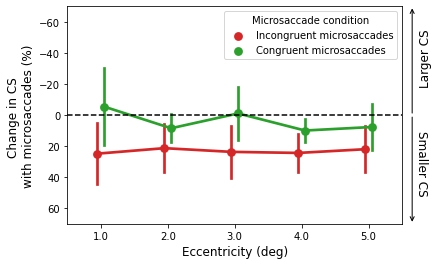

In [95]:
fig,ax=plt.subplots()
sns.pointplot(data=CS_diff,ci='sd',x='ecc',y='CS_diff',dodge=0.1,palette=['C3','C2'],hue='microsaccade_condition')
plt.ylim(70,-70)
ax.set_xlabel('Eccentricity (deg)',size=12)
# plt.ylabel("CS Trials W/O Microsaccades \n - CS Trials W Microsaccades (%)",size=12)
ax.set_ylabel("Change in CS \nwith microsaccades (%)",size=12)
ax.axhline(y=0,xmin=0,xmax=1,ls='--',color='k')
L=ax.legend(title='Microsaccade condition')
L.get_texts()[0].set_text('Incongruent microsaccades')
L.get_texts()[1].set_text("Congruent microsaccades")
ax.set_ylim(70,-70)
ax.annotate('', xy=(1.03, 0.5), xycoords='axes fraction', xytext=(1.03, 1), 
            arrowprops=dict(arrowstyle="<-", color='k'))
ax.text(4.75,-20,'Larger CS',rotation=90,size=12)
ax.annotate('', xy=(1.03, 0.5), xycoords='axes fraction', xytext=(1.03, 0), 
            arrowprops=dict(arrowstyle="<-", color='k'))
ax.text(4.69,50,'Smaller CS',rotation=270,size=12)
# plt.savefig('..\Plots\change_in_CS_from_noMicrosaccade_vs_ecc_hue_microsaccade_condition.pdf',format='pdf',dpi=1200,bbox_inches='tight')

##     1.Single microsaccade data

In [11]:
# we do the same thing as earlier but for each subject individually and create a df with critical spacings
# First step is to get a function
# Have a function that pulls in the X & Y values from df, fits the data and get the Critical spacing
def fit_and_get_CS(df,x_lin):
    # First sort the x & y values from the DF
    x_all=df['spacing'].unique()
    y_all=df.groupby('spacing')['corr'].mean().values
    x_all.sort()
    y_all.sort()
    #optimize fit 
    w,_=opt.curve_fit(func_weibull,x_all,y_all,p0=p0,bounds=(0,[3.5, 2,0.05]),maxfev=10000)
    # model fit
    y_model=func_weibull(x_lin,*w)
    # Compute Critical Spacing (CS)
    CS=np.interp(0.75*np.max(y_model), y_model,x_lin)
    # Also add interpolated 50% of asymptotic level
    fifty_percent_interp=np.interp(0.50*np.max(y_model), y_model,x_lin)
    # return the paramters
    return w,y_model,CS,fifty_percent_interp
# we first create the empty arrays that will be filling inside the loop
y_model_cong_list=np.array([])
y_model_incong_list=np.array([])
y_model_nosacc_list=np.array([])
x_lin_list=np.array([])
CS_cong_list=np.array([])
CS_incong_list=np.array([])
CS_nosacc_list=np.array([])
ecc_array=np.array([])
# Create an empty df and fill inside loop
subjs=behavData['subj_id'].unique()
counter=1
ecc_list=behavData.ecc.unique()
# This plots the psychometric function in trials with and without microsaccades independently
# First we declare the data/trials with congruent microsaccades
saccWindow="@start_pt<relOnsetTime<@end_pt "
dataWsaccCong=leftVrightData_single_msacc.query(saccWindow+" & congruent==1 & corr!='NaN'") # to fix cases where the rel onset time is really big
# second we declare the data/trials with incongruent microsaccades
dataWsaccIncong=leftVrightData_single_msacc.query(saccWindow+" & congruent==0  & corr!='NaN'") # to fix cases where the rel onset time is really big
# third we declare data/trials without microsaccades
noSaccWindow="@start_pt<relOnsetTime<@end_pt "
data=leftVrightData_single_msacc.query(noSaccWindow)
trialWsaccCode=data['trialCode'].unique()
trialWOsaccRaw=behavData[~behavData.trialCode.isin(trialWsaccCode)]
trialWOsacc=trialWOsaccRaw.query("corr!='NaN'")

# We use bootstrapping procedure for each getting the fit for each resampled data 
for resample_idx in range(1000):
    #1. Resample DF
    new_df_saccCong = dataWsaccCong.sample(n=len(dataWsaccCong),replace=True)
    new_df_saccIncong=dataWsaccIncong.sample(n=len(dataWsaccIncong),replace=True)
    new_df_nosacc=trialWOsacc.sample(n=len(trialWOsacc),replace=True)
    # Weibull function fit ------------------------------------------------------------------
    p0 = [1,1,0.05] #weibull guessed params
    # Model
    unflanked_position=7
    x_lin=np.linspace(0,unflanked_position,50)
    w1,y_model_sacc_cong,CS_cong,fifty_percent_interp_cong = fit_and_get_CS(new_df_saccCong,x_lin)
    w2,y_model_sacc_incong,CS_incong,fifty_percent_interp_incong = fit_and_get_CS(new_df_saccIncong,x_lin)
    w3,y_model_nosacc,CS_nosacc,fifty_percent_interp_nosacc=fit_and_get_CS(new_df_nosacc,x_lin)

    # Finally we save it to a DF
    y_model_cong_list=np.concatenate((y_model_cong_list,y_model_sacc_cong),axis=None)
    y_model_incong_list=np.concatenate((y_model_incong_list,y_model_sacc_incong),axis=None)
    y_model_nosacc_list=np.concatenate((y_model_nosacc_list,y_model_nosacc),axis=None)
    x_lin_list=np.concatenate((x_lin_list,x_lin),axis=None)
#         CS_cong_list=np.concatenate((CS_cong_list,CS_cong),axis=None)
#         CS_incong_list=np.concatenate((CS_incong_list,CS_incong),axis=None)
#         CS_nosacc_list=np.concatenate((CS_nosacc_list,CS_nosacc),axis=None)

#create individual df's and append together
# Model DF
y_model_df_nosacc=pd.DataFrame((np.column_stack((x_lin_list,y_model_nosacc_list))),columns=['x_lin','y_model'])
y_model_df_nosacc['microsaccade_condition']='no_saccade'
y_model_df_cong=pd.DataFrame((np.column_stack((x_lin_list,y_model_cong_list))),columns=['x_lin','y_model'])
y_model_df_cong['microsaccade_condition']='congruent'
y_model_df_incong=pd.DataFrame((np.column_stack((x_lin_list,y_model_incong_list))),columns=['x_lin','y_model'])
y_model_df_incong['microsaccade_condition']='incongruent'
frames=[y_model_df_incong,y_model_df_cong,y_model_df_nosacc]
y_model_single_df=pd.concat(frames)
y_model_single_df['x_lin']=y_model_single_df['x_lin'].astype('float')
y_model_single_df['y_model']=y_model_single_df['y_model'].astype('float')


In [38]:

# This plots the psychometric function in trials with and without microsaccades independently
# Set whether or not to use bootstrap fit
bootstrap_fit=True
# First we declare the data/trials with congruent microsaccades
saccWindow="@start_pt<relOnsetTime<@end_pt"
dataWsaccCong=leftVrightData_single_msacc.query(saccWindow+" & congruent==1") # to fix cases where the rel onset time is really big
#get samples
x_all = dataWsaccCong['spacing'].unique()
#     x_all.sort()
y_all = dataWsaccCong.groupby('spacing')['corr'].mean().values
x_sacc_cong=x_all#[:-1]
x_sacc_cong.sort()
y_sacc_cong=y_all#[:-1]
y_sacc_cong.sort()

# second we declare the data/trials with incongruent microsaccades
dataWsaccIncong=leftVrightData_single_msacc.query(saccWindow+" & congruent==0") # to fix cases where the rel onset time is really big
#get samples
x_all = dataWsaccIncong['spacing'].unique()
#     x_all.sort()
y_all = dataWsaccIncong.groupby('spacing')['corr'].mean().values
x_sacc_incong=x_all#[:-1]
x_sacc_incong.sort()
y_sacc_incong=y_all#[:-1]
y_sacc_incong.sort()

# Second we declare data/trials without microsaccades
noSaccWindow="@start_pt<relOnsetTime<@end_pt"#"-0.4<relOnsetTime<0.8"
data=leftVrightData_single_msacc.query(noSaccWindow)
trialWsaccCode=data['trialCode'].unique()
trialWOsacc=behavData[~behavData.trialCode.isin(trialWsaccCode)]
#get samples
x_all = trialWOsacc['spacing'].unique()
#     x_all.sort()
y_all = trialWOsacc.groupby('spacing')['corr'].mean().values
x_nosacc=x_all#[:-1]
x_nosacc.sort()
y_nosacc=y_all#[:-1]
y_nosacc.sort()


# REGRESSION ------------------------------------------------------------------
p0 = [3.5, 2,0.05] #weibull                                       # guessed params
#     p0=[-1.5,-1,1] # exponential
w1, _ = opt.curve_fit(func_weibull, x_sacc_cong, y_sacc_cong, p0=p0)
w2, _ = opt.curve_fit(func_weibull, x_sacc_incong, y_sacc_incong, p0=p0)
w3,_= opt.curve_fit(func_weibull, x_nosacc, y_nosacc, p0=p0)
print("Estimated Parameters:Congruent", w1)  
print("Estimated Parameters:Incongruent", w2)  
print("Estimated Parameters:No Saccade", w3)  

unflanked_position=7
# Model
x_lin=np.linspace(0,unflanked_position,50) # we move the unflanked one to 6th pos to make it look nice
y_model_sacc_cong = func_weibull(x_lin, *w1)
y_model_sacc_incong = func_weibull(x_lin, *w2)
y_model_nosacc=func_weibull(x_lin,*w3)

fig,axs=plt.subplots(1,1,figsize=(8,4))
#plot congruent microsaccade condition
axs.plot(x_sacc_cong[:-1], y_sacc_cong[:-1],ls='',marker='v',color='C2',label='Trials W congruent microsaccade')
axs.plot(unflanked_position,y_sacc_cong[-1], marker='v',color='C2')
if bootstrap_fit==True:
    sns.lineplot(x='x_lin',y='y_model',color='C2',ci='sd',data=y_model_single_df.query("microsaccade_condition=='congruent'"),ax=axs)
else:
    axs.plot(x_lin,y_model_sacc_cong,ls='--',color='C2')

# plot incongruent microsaccade condition
axs.plot(x_sacc_incong[:-1], y_sacc_incong[:-1],ls='',marker='*',color='C3',label='Trials W Incongruent microsaccade')
axs.plot(unflanked_position,y_sacc_incong[-1], marker='*',color='C3')
if bootstrap_fit==True:
    sns.lineplot(x='x_lin',y='y_model',color='C3',ci='sd',data=y_model_single_df.query("microsaccade_condition=='incongruent'"),ax=axs)
else:
    axs.plot(x_lin,y_model_sacc_incong,ls='--',color='C3')

#plot no saccade condtion
axs.plot(x_nosacc[:-1], y_nosacc[:-1],ls='',marker='o',color='k',label='Trials W/O microsaccade')
axs.plot(unflanked_position,y_nosacc[-1],marker='o',color='k')
if bootstrap_fit==True:
    sns.lineplot(x='x_lin',y='y_model',color='k',ci='sd',data=y_model_single_df.query("microsaccade_condition=='no_saccade'"),ax=axs)
else:
    axs.plot(x_lin,y_model_nosacc,ls='--',color='k')

#plot tweaks
axs.legend(title='Microsaccade condition',bbox_to_anchor=(0.7,0.35))
axs.set_ylabel("Proportion Correct",size=12)
axs.set_xlabel("Flanker Spacing (nominal)",size=12)
axs.set_ylim(0,1.0)
axs.set_xscale('log')
axs.set_xlim(1,8)
axs.text(6.5,-0.025,'//')
axs.set_ylim(0,1)
axs.set_xticks([1,2,3,4,5,6,7])
axs.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs.set_xticklabels(['1','2','3','4','5','','∞'])
# We compute critical spacings and mark them on the plot
if bootstrap_fit==True:
    df_incong=y_model_single_df.query("microsaccade_condition=='incongruent'").groupby('x_lin')['y_model'].mean().reset_index()
    cs_incong=(np.interp(0.75,  df_incong['y_model'], df_incong['x_lin']))
    df_cong=y_model_single_df.query("microsaccade_condition=='congruent' ").groupby('x_lin')['y_model'].mean().reset_index()
    cs_cong=(np.interp(0.75,  df_cong['y_model'], df_cong['x_lin']))
    df_nosacc=y_model_single_df.query("microsaccade_condition=='no_saccade' ").groupby('x_lin')['y_model'].mean().reset_index()
    cs_nosacc=(np.interp(0.75, df_nosacc ['y_model'], df_nosacc['x_lin']))
else:
    cs_incong=(np.interp(0.75, y_model_sacc_incong,x_lin))
    cs_cong=(np.interp(0.75, y_model_sacc_cong,x_lin))
    cs_nosacc=(np.interp(0.75, y_model_nosacc,x_lin))
axs.hlines(y=0.75,xmin=0,xmax=cs_nosacc,color='k',linestyle='--',alpha=0.1)
axs.axvline(x=cs_incong,ymin=0,ymax=0.75,linestyle='--',color='C3')
axs.axvline(x=cs_cong,ymin=0,ymax=0.75,linestyle='--',color='C2')
axs.axvline(x=cs_nosacc,ymin=0,ymax=0.75,linestyle='--',color='k')
print("Incongruent:%.2f,Congruent:%.2f,NoSaccade:%.2f"%(cs_incong,cs_cong,cs_nosacc))
# plt.xscale('log')
plt.tight_layout()
#plt.subplots_adjust(right=0.7)
plt.savefig('..\Plots\psychometricFunction_150to494ms_singleMicrosaccade.svg',format='svg',bbox_tight='inches',dpi=1200)

#plt.show()

Estimated Parameters:Congruent [2.37687244 2.18149427 0.11906391]
Estimated Parameters:Incongruent [2.91381428 1.76636898 0.01958355]
Estimated Parameters:No Saccade [3.01560436 1.75379706 0.11824433]
Incongruent:3.41,Congruent:3.41,NoSaccade:4.29


C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:116: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_tight" which is no longer supported as of 3.3 and will become an error two minor releases later


## 2. Multiple microsaccade trials

In [25]:
# we do the same thing as earlier but for each subject individually and create a df with critical spacings
# First step is to get a function
# Have a function that pulls in the X & Y values from df, fits the data and get the Critical spacing
def fit_and_get_CS(df,x_lin):
    # First sort the x & y values from the DF
    x_all=df['spacing'].unique()
    y_all=df.groupby('spacing')['corr'].mean().values
    x_all.sort()
    y_all.sort()
    #optimize fit 
    w,_=opt.curve_fit(func_weibull,x_all,y_all,p0=p0,bounds=(0,[3.5, 2,0.05]),maxfev=10000)
    # model fit
    y_model=func_weibull(x_lin,*w)
    # Compute Critical Spacing (CS)
    CS=np.interp(0.75*np.max(y_model), y_model,x_lin)
    # Also add interpolated 50% of asymptotic level
    fifty_percent_interp=np.interp(0.50*np.max(y_model), y_model,x_lin)
    # return the paramters
    return w,y_model,CS,fifty_percent_interp
# we first create the empty arrays that will be filling inside the loop
y_model_cong_list=np.array([])
y_model_incong_list=np.array([])
y_model_nosacc_list=np.array([])
x_lin_list=np.array([])
CS_cong_list=np.array([])
CS_incong_list=np.array([])
CS_nosacc_list=np.array([])
ecc_array=np.array([])
# Create an empty df and fill inside loop
subjs=behavData['subj_id'].unique()
counter=1
ecc_list=behavData.ecc.unique()
# This plots the psychometric function in trials with and without microsaccades independently
# First we declare the data/trials with congruent microsaccades
saccWindow="@start_pt<relOnsetTime<@end_pt "
dataWsaccCong=leftVrightData_multiple_msacc.query(saccWindow+" & congruent==1 & corr!='NaN'") # to fix cases where the rel onset time is really big
# second we declare the data/trials with incongruent microsaccades
dataWsaccIncong=leftVrightData_multiple_msacc.query(saccWindow+" & congruent==0  & corr!='NaN'") # to fix cases where the rel onset time is really big
# third we declare data/trials without microsaccades
noSaccWindow="@start_pt<relOnsetTime<@end_pt "
data=leftVrightData_multiple_msacc.query(noSaccWindow)
trialWsaccCode=data['trialCode'].unique()
trialWOsaccRaw=behavData[~behavData.trialCode.isin(trialWsaccCode)]
trialWOsacc=trialWOsaccRaw.query("corr!='NaN'")

# We use bootstrapping procedure for each getting the fit for each resampled data 
for resample_idx in range(1000):
    #1. Resample DF
    new_df_saccCong = dataWsaccCong.sample(n=len(dataWsaccCong),replace=True)
    new_df_saccIncong=dataWsaccIncong.sample(n=len(dataWsaccIncong),replace=True)
    new_df_nosacc=trialWOsacc.sample(n=len(trialWOsacc),replace=True)
    # Weibull function fit ------------------------------------------------------------------
    p0 = [1,1,0.05] #weibull guessed params
    # Model
    unflanked_position=7
    x_lin=np.linspace(0,unflanked_position,50)
    w1,y_model_sacc_cong,CS_cong,fifty_percent_interp_cong = fit_and_get_CS(new_df_saccCong,x_lin)
    w2,y_model_sacc_incong,CS_incong,fifty_percent_interp_incong = fit_and_get_CS(new_df_saccIncong,x_lin)
    w3,y_model_nosacc,CS_nosacc,fifty_percent_interp_nosacc=fit_and_get_CS(new_df_nosacc,x_lin)

    # Finally we save it to a DF
    y_model_cong_list=np.concatenate((y_model_cong_list,y_model_sacc_cong),axis=None)
    y_model_incong_list=np.concatenate((y_model_incong_list,y_model_sacc_incong),axis=None)
    y_model_nosacc_list=np.concatenate((y_model_nosacc_list,y_model_nosacc),axis=None)
    x_lin_list=np.concatenate((x_lin_list,x_lin),axis=None)
#         CS_cong_list=np.concatenate((CS_cong_list,CS_cong),axis=None)
#         CS_incong_list=np.concatenate((CS_incong_list,CS_incong),axis=None)
#         CS_nosacc_list=np.concatenate((CS_nosacc_list,CS_nosacc),axis=None)

#create individual df's and append together
# Model DF
y_model_df_nosacc=pd.DataFrame((np.column_stack((x_lin_list,y_model_nosacc_list))),columns=['x_lin','y_model'])
y_model_df_nosacc['microsaccade_condition']='no_saccade'
y_model_df_cong=pd.DataFrame((np.column_stack((x_lin_list,y_model_cong_list))),columns=['x_lin','y_model'])
y_model_df_cong['microsaccade_condition']='congruent'
y_model_df_incong=pd.DataFrame((np.column_stack((x_lin_list,y_model_incong_list))),columns=['x_lin','y_model'])
y_model_df_incong['microsaccade_condition']='incongruent'
frames=[y_model_df_incong,y_model_df_cong,y_model_df_nosacc]
y_model_multiple_df=pd.concat(frames)
y_model_multiple_df['x_lin']=y_model_multiple_df['x_lin'].astype('float')
y_model_multiple_df['y_model']=y_model_multiple_df['y_model'].astype('float')


Estimated Parameters:Congruent [3.08300434 1.89373911 0.09051901]
Estimated Parameters:Incongruent [2.53552723 2.04287573 0.07459239]
Estimated Parameters:No Saccade [3.03935869 1.70142025 0.12532637]
Incongruent:3.22,Congruent:4.06,NoSaccade:4.42


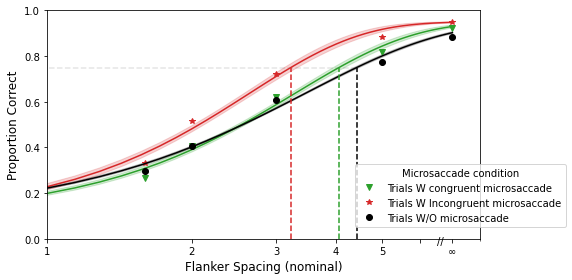

In [40]:

# This plots the psychometric function in trials with and without microsaccades independently
# Set whether or not to use bootstrap fit
# First we declare the data/trials with congruent microsaccades
saccWindow="@start_pt<relOnsetTime<@end_pt"
dataWsaccCong=leftVrightData_multiple_msacc.query(saccWindow+" & congruent==1") # to fix cases where the rel onset time is really big
#get samples
x_all = dataWsaccCong['spacing'].unique()
#     x_all.sort()
y_all = dataWsaccCong.groupby('spacing')['corr'].mean().values
x_sacc_cong=x_all#[:-1]
x_sacc_cong.sort()
y_sacc_cong=y_all#[:-1]
y_sacc_cong.sort()

# second we declare the data/trials with incongruent microsaccades
dataWsaccIncong=leftVrightData_multiple_msacc.query(saccWindow+" & congruent==0") # to fix cases where the rel onset time is really big
#get samples
x_all = dataWsaccIncong['spacing'].unique()
#     x_all.sort()
y_all = dataWsaccIncong.groupby('spacing')['corr'].mean().values
x_sacc_incong=x_all#[:-1]
x_sacc_incong.sort()
y_sacc_incong=y_all#[:-1]
y_sacc_incong.sort()

# Second we declare data/trials without microsaccades
noSaccWindow="@start_pt<relOnsetTime<@end_pt"#"-0.4<relOnsetTime<0.8"
data=leftVrightData_multiple_msacc.query(noSaccWindow)
trialWsaccCode=data['trialCode'].unique()
trialWOsacc=behavData[~behavData.trialCode.isin(trialWsaccCode)]
#get samples
x_all = trialWOsacc['spacing'].unique()
#     x_all.sort()
y_all = trialWOsacc.groupby('spacing')['corr'].mean().values
x_nosacc=x_all#[:-1]
x_nosacc.sort()
y_nosacc=y_all#[:-1]
y_nosacc.sort()


# REGRESSION ------------------------------------------------------------------
p0 = [3.5, 2,0.05] #weibull                                       # guessed params
#     p0=[-1.5,-1,1] # exponential
w1, _ = opt.curve_fit(func_weibull, x_sacc_cong, y_sacc_cong, p0=p0)
w2, _ = opt.curve_fit(func_weibull, x_sacc_incong, y_sacc_incong, p0=p0)
w3,_= opt.curve_fit(func_weibull, x_nosacc, y_nosacc, p0=p0)
print("Estimated Parameters:Congruent", w1)  
print("Estimated Parameters:Incongruent", w2)  
print("Estimated Parameters:No Saccade", w3)  

unflanked_position=7
# Model
x_lin=np.linspace(0,unflanked_position+1,50) # we move the unflanked one to 6th pos to make it look nice
y_model_sacc_cong = func_weibull(x_lin, *w1)
y_model_sacc_incong = func_weibull(x_lin, *w2)
y_model_nosacc=func_weibull(x_lin,*w3)

fig,axs=plt.subplots(1,1,figsize=(8,4))

#plot congruent microsaccade condition
axs.plot(x_sacc_cong[:-1], y_sacc_cong[:-1],ls='',marker='v',color='C2',label='Trials W congruent microsaccade')
axs.plot(unflanked_position,y_sacc_cong[-1], marker='v',color='C2')
if bootstrap_fit==True:
    sns.lineplot(x='x_lin',y='y_model',color='C2',ci='sd',data=y_model_multiple_df.query("microsaccade_condition=='congruent'"),ax=axs)
else:
    axs.plot(x_lin,y_model_sacc_cong,ls='--',color='C2')

# plot incongruent microsaccade condition
axs.plot(x_sacc_incong[:-1], y_sacc_incong[:-1],ls='',marker='*',color='C3',label='Trials W Incongruent microsaccade')
axs.plot(unflanked_position,y_sacc_incong[-1], marker='*',color='C3')
if bootstrap_fit==True:
    sns.lineplot(x='x_lin',y='y_model',color='C3',ci='sd',data=y_model_multiple_df.query("microsaccade_condition=='incongruent'"),ax=axs)
else:
    axs.plot(x_lin,y_model_sacc_incong,ls='--',color='C3')

#plot no saccade condtion
axs.plot(x_nosacc[:-1], y_nosacc[:-1],ls='',marker='o',color='k',label='Trials W/O microsaccade')
axs.plot(unflanked_position,y_nosacc[-1],marker='o',color='k')
if bootstrap_fit==True:
    sns.lineplot(x='x_lin',y='y_model',color='k',ci='sd',data=y_model_multiple_df.query("microsaccade_condition=='no_saccade'"),ax=axs)
else:
    axs.plot(x_lin,y_model_nosacc,ls='--',color='k')

#plot tweaks
axs.legend(title='Microsaccade condition',bbox_to_anchor=(0.7,0.35))
axs.set_ylabel("Proportion Correct",size=12)
axs.set_xlabel("Flanker Spacing (nominal)",size=12)
axs.set_ylim(0,1.0)
axs.set_xscale('log')
axs.set_xlim(1,8)
axs.text(6.5,-0.025,'//')
axs.set_ylim(0,1)
axs.set_xticks([1,2,3,4,5,6,7])
axs.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs.set_xticklabels(['1','2','3','4','5','','∞'])
# We compute critical spacings and mark them on the plot
if bootstrap_fit==True:
    df_incong=y_model_multiple_df.query("microsaccade_condition=='incongruent'").groupby('x_lin')['y_model'].mean().reset_index()
    cs_incong=(np.interp(0.75,  df_incong['y_model'], df_incong['x_lin']))
    df_cong=y_model_multiple_df.query("microsaccade_condition=='congruent' ").groupby('x_lin')['y_model'].mean().reset_index()
    cs_cong=(np.interp(0.75,  df_cong['y_model'], df_cong['x_lin']))
    df_nosacc=y_model_multiple_df.query("microsaccade_condition=='no_saccade' ").groupby('x_lin')['y_model'].mean().reset_index()
    cs_nosacc=(np.interp(0.75, df_nosacc ['y_model'], df_nosacc['x_lin']))
else:
    cs_incong=(np.interp(0.75, y_model_sacc_incong,x_lin))
    cs_cong=(np.interp(0.75, y_model_sacc_cong,x_lin))
    cs_nosacc=(np.interp(0.75, y_model_nosacc,x_lin))
axs.hlines(y=0.75,xmin=0,xmax=cs_nosacc,color='k',linestyle='--',alpha=0.1)
axs.axvline(x=cs_incong,ymin=0,ymax=0.75,linestyle='--',color='C3')
axs.axvline(x=cs_cong,ymin=0,ymax=0.75,linestyle='--',color='C2')
axs.axvline(x=cs_nosacc,ymin=0,ymax=0.75,linestyle='--',color='k')
print("Incongruent:%.2f,Congruent:%.2f,NoSaccade:%.2f"%(cs_incong,cs_cong,cs_nosacc))
# plt.xscale('log')
plt.tight_layout()
plt.savefig('..\Plots\psychometricFunction_150to494ms_MultipleMicrosaccade.svg',format='svg',bbox_inches='tight',dpi=1200)

In [ ]:
# This plots the psychometric function in trials with and without microsaccades independently
# Set whether or not to use bootstrap fit
bootstrap_fit=True
# First we declare the data/trials with congruent microsaccades
saccWindow="@start_pt<relOnsetTime<@end_pt"
dataWsaccCong=leftVrightData.query(saccWindow+" & congruent==1") # to fix cases where the rel onset time is really big
#get samples
x_all = dataWsaccCong['spacing'].unique()
#     x_all.sort()
y_all = dataWsaccCong.groupby('spacing')['corr'].mean().values
x_sacc_cong=x_all#[:-1]
x_sacc_cong.sort()
y_sacc_cong=y_all#[:-1]
y_sacc_cong.sort()

# second we declare the data/trials with incongruent microsaccades
dataWsaccIncong=leftVrightData.query(saccWindow+" & congruent==0") # to fix cases where the rel onset time is really big
#get samples
x_all = dataWsaccIncong['spacing'].unique()
#     x_all.sort()
y_all = dataWsaccIncong.groupby('spacing')['corr'].mean().values
x_sacc_incong=x_all#[:-1]
x_sacc_incong.sort()
y_sacc_incong=y_all#[:-1]
y_sacc_incong.sort()

# Second we declare data/trials without microsaccades
noSaccWindow="@start_pt<relOnsetTime<@end_pt"#"-0.4<relOnsetTime<0.8"
data=leftVrightData.query(noSaccWindow)
trialWsaccCode=data['trialCode'].unique()
trialWOsacc=behavData[~behavData.trialCode.isin(trialWsaccCode)]
#get samples
x_all = trialWOsacc['spacing'].unique()
#     x_all.sort()
y_all = trialWOsacc.groupby('spacing')['corr'].mean().values
x_nosacc=x_all#[:-1]
x_nosacc.sort()
y_nosacc=y_all#[:-1]
y_nosacc.sort()


# REGRESSION ------------------------------------------------------------------
p0 = [3.5, 2,0.05] #weibull                                       # guessed params
#     p0=[-1.5,-1,1] # exponential
w1, _ = opt.curve_fit(func_weibull, x_sacc_cong, y_sacc_cong, p0=p0)
w2, _ = opt.curve_fit(func_weibull, x_sacc_incong, y_sacc_incong, p0=p0)
w3,_= opt.curve_fit(func_weibull, x_nosacc, y_nosacc, p0=p0)
print("Estimated Parameters:Congruent", w1)  
print("Estimated Parameters:Incongruent", w2)  
print("Estimated Parameters:No Saccade", w3)  

unflanked_position=10
# Model
x_lin=np.linspace(0,unflanked_position+1,50) # we move the unflanked one to 6th pos to make it look nice
y_model_sacc_cong = func_weibull(x_lin, *w1)
y_model_sacc_incong = func_weibull(x_lin, *w2)
y_model_nosacc=func_weibull(x_lin,*w3)


#plot congruent microsaccade condition
plt.plot(x_sacc_cong[:-1], y_sacc_cong[:-1],ls='',marker='v',color='C2',label='Trials W congruent microsaccade')
plt.plot(unflanked_position,y_sacc_cong[-1], marker='v',color='C2')
if bootstrap_fit==True:
    ax=sns.lineplot(x='x_lin',y='y_model',color='C2',ci='sd',data=y_model_df.query("microsaccade_condition=='congruent'"))
else:
    plt.plot(x_lin,y_model_sacc_cong,ls='--',color='C2')

# plot incongruent microsaccade condition
plt.plot(x_sacc_incong[:-1], y_sacc_incong[:-1],ls='',marker='*',color='C3',label='Trials W Incongruent microsaccade')
plt.plot(unflanked_position,y_sacc_incong[-1], marker='*',color='C3')
if bootstrap_fit==True:
    ax=sns.lineplot(x='x_lin',y='y_model',color='C3',ci='sd',data=y_model_df.query("microsaccade_condition=='incongruent'"))
else:
    plt.plot(x_lin,y_model_sacc_incong,ls='--',color='C3')

#plot no saccade condtion
plt.plot(x_nosacc[:-1], y_nosacc[:-1],ls='',marker='o',color='k',label='Trials W/O microsaccade')
plt.plot(unflanked_position,y_nosacc[-1],marker='o',color='k')
if bootstrap_fit==True:
    ax=sns.lineplot(x='x_lin',y='y_model',color='k',ci='sd',data=y_model_df.query("microsaccade_condition=='no_saccade'"))
else:
    plt.plot(x_lin,y_model_nosacc,ls='--',color='k')

#plot tweaks
plt.legend(title='Microsaccade condition',bbox_to_anchor=(1.08,0.35))
plt.ylabel("Proportion Correct",size=12)
plt.xlabel("Flanker Spacing (nominal)",size=12)
plt.ylim(0,1.0)
xticklabels=['0','1','2','3','4','5','Unflanked']
plt.xticks([0,1,2,3,4,5,unflanked_position],xticklabels)
# We compute critical spacings and mark them on the plot
if bootstrap_fit==True:
    cs_incong=(np.interp(0.75,  y_model_df.query("microsaccade_condition=='incongruent'")['y_model'], y_model_df.query("microsaccade_condition=='incongruent'")['x_lin']))
    cs_cong=(np.interp(0.75,  y_model_df.query("microsaccade_condition=='congruent'")['y_model'], y_model_df.query("microsaccade_condition=='congruent'")['x_lin']))
    cs_nosacc=(np.interp(0.75,  y_model_df.query("microsaccade_condition=='no_saccade'")['y_model'], y_model_df.query("microsaccade_condition=='no_saccade'")['x_lin']))
else:
    cs_incong=(np.interp(0.75, y_model_sacc_incong,x_lin))
    cs_cong=(np.interp(0.75, y_model_sacc_cong,x_lin))
    cs_nosacc=(np.interp(0.75, y_model_nosacc,x_lin))
plt.hlines(y=0.75,xmin=0,xmax=cs_nosacc,color='k',linestyle='--',alpha=0.1)
plt.axvline(x=cs_incong,ymin=0,ymax=0.75,linestyle='--',color='C3')
plt.axvline(x=cs_cong,ymin=0,ymax=0.75,linestyle='--',color='C2')
plt.axvline(x=cs_nosacc,ymin=0,ymax=0.75,linestyle='--',color='k')
print("Incongruent:%.2f,Congruent:%.2f,NoSaccade:%.2f"%(cs_incong,cs_cong,cs_nosacc))
plt.xscale('log')
# plt.title("Microsaccade query conditions: %s"%(saccWindow))
# plt.title('Trials with microsaccades between 154 to 414 ms after stimulus onset',size=10)
# if bootstrap_fit==True:
#     plt.savefig('..\Plots\psychometricFunction_%dto%dms_bootStrapFit.svg'%(start_pt*1000,end_pt*1000),format='svg',dpi=1200)    
# else:
#     plt.savefig('..\Plots\psychometricFunction_150to464ms.svg',format='svg',dpi=1200)

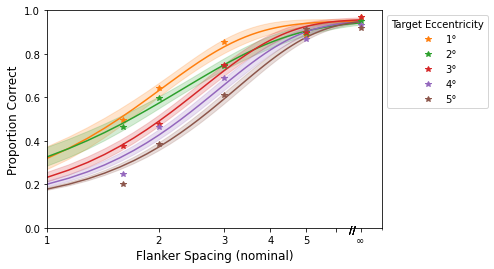

In [30]:
bootstrap_fit=True
fig,axs=plt.subplots(1,1)
eccs_list=[1,2,3,4,5]
ecc_counter=0
# First we declare the data/trials with congruent microsaccades
saccWindow="@start_pt<relOnsetTime<@end_pt"
for i in range(5):
    anecc=eccs_list[i]

    # second we declare the data/trials with incongruent microsaccades
    dataWsaccIncong=leftVrightData.query(saccWindow+" & congruent==0 & ecc==@anecc") # to fix cases where the rel onset time is really big
    #get samples
    x_all = dataWsaccIncong['spacing'].unique()
    #     x_all.sort()
    y_all = dataWsaccIncong.groupby('spacing')['corr'].mean().values
    x_sacc_incong=x_all#[:-1]
    x_sacc_incong.sort()
    y_sacc_incong=y_all#[:-1]
    y_sacc_incong.sort()

    # REGRESSION ------------------------------------------------------------------
    p0 = [3.5, 2,0.05] #weibull                                       # guessed params
    #     p0=[-1.5,-1,1] # exponential
    w2, _ = opt.curve_fit(func_weibull, x_sacc_incong, y_sacc_incong, p0=p0)
#     print("Estimated Parameters:Congruent", w1)  
#     print("Estimated Parameters:Incongruent", w2)  
#     print("Estimated Parameters:No Saccade", w3)  

    unflanked_position=7
    # Model
    x_lin=np.linspace(0,unflanked_position,50) # we move the unflanked one to 6th pos to make it look nice
    y_model_sacc_incong = func_weibull(x_lin, *w2)

    if anecc==1:
        colorType='C1'
    elif anecc==2:
        colorType='C2'
    elif anecc==3:
        colorType='C3'
    elif anecc==4:
        colorType='C4'
    elif anecc==5:
        colorType='C5'
    # plot incongruent microsaccade condition
    axs.plot(x_sacc_incong[:-1], y_sacc_incong[:-1],ls='',color=colorType,marker='*',label='%d°'%(anecc))
    axs.plot(unflanked_position,y_sacc_incong[-1], marker='*',color=colorType)
    if bootstrap_fit==True:
        if anecc==1:
            sns.lineplot(x='x_lin',y='y_model',color=colorType,ci='sd',data=y_model_df_ecc.query("microsaccade_condition=='incongruent'"),hue='ecc',ax=axs,legend=False,palette=['C1','C2','C3','C4','C5'])
        

    ## We then zoom in to different portions on each plot
    axs.set_xscale('log')
    axs.set_xlim(1,8)
    axs.text(6.5,-0.025,'//')
    axs.set_ylim(0,1)
    axs.set_xticks([1,2,3,4,5,6,7])
    axs.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    axs.set_xticklabels(['1','2','3','4','5','','∞'])
    
    axs.set_ylabel("Proportion Correct",size=12)
    axs.legend(title='Target Eccentricity',bbox_to_anchor=(1,1))
    axs.set_xlabel("Flanker Spacing (nominal)",size=12)

    #print("Incongruent:%.2f,Congruent:%.2f,NoSaccade:%.2f"%(cs_incong,cs_cong,cs_nosacc))
plt.savefig("..\Plots\PsychometricFunction_IncongruentOnly_byEcc.svg",dpi=1200)

In [20]:
# Unflanked Data
# First we declare the data/trials with congruent microsaccades
saccWindow="@start_pt<relOnsetTime<@end_pt"
dataWsaccCong=leftVrightData.query(saccWindow+" & congruent==1 and spacing==100")
bootstrapped_unflanked_df=[]
subs=leftVrightData.subj_id_x.unique()
ecc_list=behavData.ecc.unique()
for asub in subs:
    for anecc in ecc_list:
        #Congruent condition
        data_cong=leftVrightData.query(saccWindow+" & congruent==1 and spacing==100 & ecc==@anecc & subj_id_x==@asub")['corr']
        zScores=bootstrap_corr_to_z(data_cong)
        propCorr=bootstrap_corr_to_propCor(data_cong)
        tempDF_sacc_cong=pd.DataFrame(np.column_stack((zScores,propCorr)),columns=['zScores','propCorr'])
        tempDF_sacc_cong['subj']=asub
        tempDF_sacc_cong['congruent']='congruent'
        tempDF_sacc_cong['ecc']=anecc
        bootstrapped_unflanked_df.append(tempDF_sacc_cong)
        #incongruent condition
        data_incong=leftVrightData.query(saccWindow+" & congruent==0 and spacing==100 & ecc==@anecc & subj_id_x==@asub")['corr']
        zScores=bootstrap_corr_to_z(data_incong)
        propCorr=bootstrap_corr_to_propCor(data_incong)
        tempDF_sacc_incong=pd.DataFrame(np.column_stack((zScores,propCorr)),columns=['zScores','propCorr'])
        tempDF_sacc_incong['subj']=asub
        tempDF_sacc_incong['congruent']='incongruent'
        tempDF_sacc_incong['ecc']=anecc
        bootstrapped_unflanked_df.append(tempDF_sacc_incong)
        # No saccade condition
        noSaccWindow="@start_pt<relOnsetTime<@end_pt & subj_id_x==@asub"
        data=leftVrightData.query(noSaccWindow)
        trialWsaccCode=data['trialCode'].unique()
        trialWOsacc=behavData[~behavData.trialCode.isin(trialWsaccCode)]
        data_nosacc=trialWOsacc.query("spacing==100 & ecc==@anecc & subj_id==@asub")['corr']
        zScores=bootstrap_corr_to_z(data_nosacc)
        propCorr=bootstrap_corr_to_propCor(data_nosacc)
        tempDF_nosacc=pd.DataFrame(np.column_stack((zScores,propCorr)),columns=['zScores','propCorr'])
        tempDF_nosacc['subj']=asub
        tempDF_nosacc['congruent']='nosaccade'
        tempDF_nosacc['ecc']=anecc
        bootstrapped_unflanked_df.append(tempDF_nosacc)
    
bootstrapped_unflanked_df=pd.concat(bootstrapped_unflanked_df)

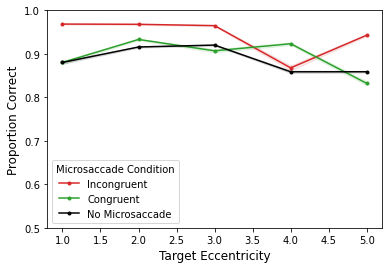

In [21]:
#### Incongruent Condition
df1_mean=bootstrapped_unflanked_df.query("congruent=='incongruent'").groupby(['ecc'])['propCorr'].mean().reset_index()
# Compute CI
df1_std=bootstrapped_unflanked_df.query("congruent=='incongruent'").groupby(['ecc'])['propCorr'].std().reset_index()
df1_count=bootstrapped_unflanked_df.query("congruent=='incongruent'").groupby(['ecc'])['propCorr'].count().reset_index()
ci1=1.96 * (df1_std['propCorr'])/np.sqrt(df1_count['propCorr']) 
x1=df1_std['ecc']
plt.plot(df1_mean['ecc'],df1_mean['propCorr'],label='Incongruent',color='C3',marker='.')
plt.fill_between(x1,(df1_mean['propCorr']+ci1),(df1_mean['propCorr']-ci1),color='C3',alpha=0.1)

#congruent condition
df1_mean=bootstrapped_unflanked_df.query("congruent=='congruent'").groupby(['ecc'])['propCorr'].mean().reset_index()
# Compute CI
df1_std=bootstrapped_unflanked_df.query("congruent=='congruent'").groupby(['ecc'])['propCorr'].std().reset_index()
df1_count=bootstrapped_unflanked_df.query("congruent=='congruent'").groupby(['ecc'])['propCorr'].count().reset_index()
ci1=1.96 * (df1_std['propCorr'])/np.sqrt(df1_count['propCorr']) 
x1=df1_std['ecc']
plt.plot(df1_mean['ecc'],df1_mean['propCorr'],label='Congruent',color='C2',marker='.')
plt.fill_between(x1,(df1_mean['propCorr']+ci1),(df1_mean['propCorr']-ci1),color='C2',alpha=0.1)

# No saccade condition
df1_mean=bootstrapped_unflanked_df.query("congruent=='nosaccade'").groupby(['ecc'])['propCorr'].mean().reset_index()
# Compute CI
df1_std=bootstrapped_unflanked_df.query("congruent=='nosaccade'").groupby(['ecc'])['propCorr'].std().reset_index()
df1_count=bootstrapped_unflanked_df.query("congruent=='nosaccade'").groupby(['ecc'])['propCorr'].count().reset_index()
ci1=1.96 * (df1_std['propCorr'])/np.sqrt(df1_count['propCorr']) 
x1=df1_std['ecc']
plt.plot(df1_mean['ecc'],df1_mean['propCorr'],label='No Microsaccade',color='k',marker='.')
plt.fill_between(x1,(df1_mean['propCorr']+ci1),(df1_mean['propCorr']-ci1),color='k',alpha=0.1)

plt.ylabel("Proportion Correct",size=12)
plt.xlabel("Target Eccentricity",size=12)
plt.legend(title='Microsaccade Condition')
plt.ylim(0.5,1)
plt.savefig('..\Plots\PropCorrVecc_unflanked condition.pdf',dpi=1200)

In [67]:
plt.figure(figsize=(7,4))
#### Incongruent Condition
df1_mean=bootstrapped_unflanked_df.query("congruent=='incongruent'").groupby(['ecc'])['zScores'].mean().reset_index()
# Compute CI
df1_std=bootstrapped_unflanked_df.query("congruent=='incongruent'").groupby(['ecc'])['zScores'].std().reset_index()
df1_count=bootstrapped_unflanked_df.query("congruent=='incongruent'").groupby(['ecc'])['zScores'].count().reset_index()
ci1=1.96 * (df1_std['zScores'])/np.sqrt(df1_count['zScores']) 
x1=df1_std['ecc']
plt.plot(df1_mean['ecc'],df1_mean['zScores'],label='Incongruent',color='C3',marker='.')
plt.fill_between(x1,(df1_mean['zScores']+ci1),(df1_mean['zScores']-ci1),color='C3',alpha=0.1)

#congruent condition
df1_mean=bootstrapped_unflanked_df.query("congruent=='congruent'").groupby(['ecc'])['zScores'].mean().reset_index()
# Compute CI
df1_std=bootstrapped_unflanked_df.query("congruent=='congruent'").groupby(['ecc'])['zScores'].std().reset_index()
df1_count=bootstrapped_unflanked_df.query("congruent=='congruent'").groupby(['ecc'])['zScores'].count().reset_index()
ci1=1.96 * (df1_std['zScores'])/np.sqrt(df1_count['zScores']) 
x1=df1_std['ecc']
plt.plot(df1_mean['ecc'],df1_mean['zScores'],label='Congruent',color='C2',marker='.')
plt.fill_between(x1,(df1_mean['zScores']+ci1),(df1_mean['zScores']-ci1),color='C2',alpha=0.1)

# No saccade condition
df1_mean=bootstrapped_unflanked_df.query("congruent=='nosaccade'").groupby(['ecc'])['zScores'].mean().reset_index()
# Compute CI
df1_std=bootstrapped_unflanked_df.query("congruent=='nosaccade'").groupby(['ecc'])['zScores'].std().reset_index()
df1_count=bootstrapped_unflanked_df.query("congruent=='nosaccade'").groupby(['ecc'])['zScores'].count().reset_index()
ci1=1.96 * (df1_std['zScores'])/np.sqrt(df1_count['zScores']) 
x1=df1_std['ecc']
plt.plot(df1_mean['ecc'],df1_mean['zScores'],label='No Microsaccade',color='k',marker='.')
plt.fill_between(x1,(df1_mean['zScores']+ci1),(df1_mean['zScores']-ci1),color='k',alpha=0.1)

plt.ylabel("Z Scores",size=12)
plt.xlabel("Target Eccentricity",size=12)
plt.legend(title='Microsaccade Condition',bbox_to_anchor=(1,1))
# plt.ylim(0.75,1)
plt.tight_layout()
plt.savefig('..\Plots\zScoreVecc_unflanked condition.svg',dpi=1200,bbox_tight='inches')

C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:37: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_tight" which is no longer supported as of 3.3 and will become an error two minor releases later


In [ ]:
stim_loc_cond="stim_loc=='right' & stim_loc=='left'"
sns.lineplot(x='spacing',y='corr',data=leftVrightData.query(saccWindow+" & congruent==1"),marker='o',color='green',label='Trials with Congruent Microsaccades')
sns.lineplot(x='spacing',y='corr',data=leftVrightData.query(saccWindow+" & congruent==0"),marker='o',color='red',label='Trials with Incongruent Microsaccades')
sns.lineplot(x='spacing',y='corr',data=trialWOsacc,marker='o',label='No Microsaccade')
plt.legend()#bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim(0.2,1)
plt.xscale('log')
plt.ylabel("Proportion Correct",size=12)
plt.xlabel("Flanker Spacing (nominal)",size=12)
plt.title('Trials with microsaccades between 200 to 400 ms after stimulus onset',size=10)
plt.savefig('..\Plots\PerforamanceVspacing_hue_saccCondition_200to400ms.svg',format='svg',dpi=1200,bbox_inches='tight')

### psychometric function using absolute spacings

In [37]:
def abs_spacing_func(row):
    # For unflanked we set the absolute spacing to some arbitary value
    if row['spacing']==100:
        absSpacing=10
    else:
        # We then compute the absolute spacing in degrees using the target-flanker spacings and the target size
        absSpacing=row['spacing'] * row['size']
    return absSpacing

leftVrightData['absSpacing']=leftVrightData.apply(abs_spacing_func,axis=1)
# We do the same thing with the behavData for the no microsaccade condition
behavData['absSpacing']=behavData.apply(abs_spacing_func,axis=1)

In [ ]:
import warnings
warnings.filterwarnings('ignore')
subj='S05'
for anecc in range(1,6):
     # This plots the psychometric function in trials with and without microsaccades independently
    # First we declare the data/trials with congruent microsaccades
    saccWindow=".156<relOnsetTime<=0.407 "
    dataWsaccCong=leftVrightData.query(saccWindow+" & congruent==1 & ecc==@anecc & subj_id==@subj") # to fix cases where the rel onset time is really big
    #get samples
    x_all = dataWsaccCong['absSpacing'].unique()
    #     x_all.sort()
    y_all = dataWsaccCong.groupby('absSpacing')['corr'].mean().values
    x_sacc_cong=x_all#[:-1]
    x_sacc_cong.sort()
    y_sacc_cong=y_all#[:-1]
    y_sacc_cong.sort()

    # second we declare the data/trials with incongruent microsaccades
    dataWsaccIncong=leftVrightData.query(saccWindow+" & congruent==0 & ecc==@anecc & subj_id==@subj") # to fix cases where the rel onset time is really big
    #get samples
    x_all = dataWsaccIncong['absSpacing'].unique()
    #     x_all.sort()
    y_all = dataWsaccIncong.groupby('absSpacing')['corr'].mean().values
    x_sacc_incong=x_all#[:-1]
    x_sacc_incong.sort()
    y_sacc_incong=y_all#[:-1]
    y_sacc_incong.sort()

    # Second we declare data/trials without microsaccades
    noSaccWindow="-0.4<relOnsetTime<0.8"
    data=leftVrightData.query(noSaccWindow)
    trialWsaccCode=data['trialCode'].unique()
    trialWOsaccRaw=behavData[~behavData.trialCode.isin(trialWsaccCode)]
    trialWOsacc=trialWOsaccRaw.query("subj_id==@subj & ecc==@anecc")
    #get samples
    x_all = trialWOsacc['absSpacing'].unique()
    #     x_all.sort()
    y_all = trialWOsacc.groupby('absSpacing')['corr'].mean().values
    x_nosacc=x_all#[:-1]
    x_nosacc.sort()
    y_nosacc=y_all#[:-1]
    y_nosacc.sort()


    # REGRESSION ------------------------------------------------------------------
    p0 = [3.5,2,0.05] #weibull                                       # guessed params
    #     p0=[-1.5,-1,1] # exponential
    w1, _ = opt.curve_fit(func_weibull, x_sacc_cong, y_sacc_cong, p0=p0,maxfev=5000)
    w2, _ = opt.curve_fit(func_weibull, x_sacc_incong, y_sacc_incong, p0=p0,maxfev=5000)
    w3,_= opt.curve_fit(func_weibull, x_nosacc, y_nosacc, p0=p0,maxfev=5000)
#     print("Estimated Parameters:Congruent", w1)  
#     print("Estimated Parameters:Incongruent", w2)  
#     print("Estimated Parameters:No Saccade", w3)  

    # Model
    x_lin=np.linspace(0.2,10,200)
    y_model_sacc_cong = func_weibull(x_lin, *w1)
    y_model_sacc_incong = func_weibull(x_lin, *w2)
    y_model_nosacc=func_weibull(x_lin,*w3)
    # Add color and marker type parameter based on eccentricity
    if anecc==1:
        markerType='v'
        colorType='black'
    elif anecc==2:
        markerType='^'
        colorType='navy'
    elif anecc==3:
        markerType='s'
        colorType='darkorange'
    elif anecc==4:
        markerType='*'
        colorType='darkviolet'
    elif anecc==5:
        markerType='o'
        colorType='crimson'
    
    #plot congruent microsaccade condition
    plt.plot(x_sacc_cong, y_sacc_cong,ls='',marker='v',color=colorType,label='Trials W congruent microsaccade @ 1 degree' if anecc==1 else "Eccentricity:%d degrees"%(anecc))
    plt.plot(x_lin, y_model_sacc_cong,ls='dotted',color=colorType)

    # plot incongruent microsaccade condition
    plt.plot(x_sacc_incong, y_sacc_incong,ls='',marker='*',color=colorType,label='Trials W Incongruent microsaccade @ 1 degree'if anecc==1 else "")
    plt.plot(x_lin, y_model_sacc_incong, ls='dashed',color=colorType)

    #plot no saccade condtion
    plt.plot(x_nosacc, y_nosacc,ls='',marker='o',color=colorType,label='Trials W/O microsaccade @ 1 degree'if anecc==1 else "")
    plt.plot(x_lin, y_model_nosacc, ls='solid',color=colorType)

    #plot tweaks
#     plt.legend(loc="best",title='Microsaccade condition')
#     plt.legend()
    plt.ylabel("Proportion Correct",size=12)
    plt.xlabel("Flanker Spacing (degrees)",size=12)
    plt.ylim(0,1.0)
    plt.xlim(0.4,11)
    plt.legend(bbox_to_anchor=[1.05,1])
    plt.xscale('log')
    plt.title('Trials with microsaccades between 156 to 407 ms after stimulus onset',size=10)
    
    # We also add the critical spacing estimate based on 90% of asymptotic level
    guess=0.1
    lr=0.05
#     print("%d deg incongruent:%.2f"%(anecc,np.interp(0.75*np.max(y_model_sacc_incong), y_model_sacc_incong,x_lin)))
#     print("%d deg congruent:%.2f"%(anecc,np.interp(0.75*np.max(y_model_sacc_cong), y_model_sacc_cong,x_lin)))
#     print("%d deg no saccade:%.2f"%(anecc,np.interp(0.75*np.max(y_model_nosacc), y_model_nosacc,x_lin)))
    # plt.savefig('..\Plots\psychometricFunction_156to407ms.svg',format='svg',dpi=1200)
    print("Ecc%d: %d incong; %d cong"%(anecc,len(dataWsaccIncong),len(dataWsaccCong)))

In [38]:
# we do the same thing as earlier but for each subject individually and create a df with critical spacings
# First step is to get a function
# Have a function that pulls in the X & Y values from df, fits the data and get the Critical spacing
def fit_and_get_CS(df,x_lin):
    # First sort the x & y values from the DF
    x_all=df['absSpacing'].unique()
    y_all=df.groupby('absSpacing')['corr'].mean().values
    x_all.sort()
    y_all.sort()
    #optimize fit 
    w,_=opt.curve_fit(func_weibull,x_all,y_all,p0=p0,bounds=(0,[10,10,0.5]),maxfev=10000)
    # model fit
    y_model=func_weibull(x_lin,*w)
    # Compute Critical Spacing (CS)
    CS=np.interp(0.75*np.max(y_model), y_model,x_lin)
    # Also add interpolated 50% of asymptotic level
    fifty_percent_interp=np.interp(0.50*np.max(y_model), y_model,x_lin)
    # return the paramters
    return w,y_model,CS,fifty_percent_interp
# we first create the empty arrays that will be filling inside the loop
y_model_cong_list=np.array([])
y_model_incong_list=np.array([])
y_model_nosacc_list=np.array([])
x_lin_list=np.array([])
CS_cong_list=np.array([])
CS_incong_list=np.array([])
CS_nosacc_list=np.array([])
subj_list=np.array([])
ecc_list=np.array([])
subj_list_model=np.array([])
ecc_list_model=np.array([])
# Create an empty df and fill inside loop
subjs=behavData['subj_id'].unique()
num_iters=len(subjs) * 5
counter=1
for asub in subjs:
    for anecc in range(1,6):
        print('%d/%d'%(counter,num_iters),end='\r')
        # This plots the psychometric function in trials with and without microsaccades independently
        # First we declare the data/trials with congruent microsaccades
        saccWindow="@start_pt<relOnsetTime<@end_pt"
        dataWsaccCong=leftVrightData.query(saccWindow+" & congruent==1 & ecc==@anecc & subj_id_x==@asub & corr<2") # to fix cases where the rel onset time is really big
        # second we declare the data/trials with incongruent microsaccades
        dataWsaccIncong=leftVrightData.query(saccWindow+" & congruent==0 & ecc==@anecc & subj_id_x==@asub & corr<2") # to fix cases where the rel onset time is really big
        # third we declare data/trials without microsaccades
        noSaccWindow="-0.154<relOnsetTime<0.414"
        data=leftVrightData.query(noSaccWindow)
        trialWsaccCode=data['trialCode'].unique()
        trialWOsaccRaw=behavData[~behavData.trialCode.isin(trialWsaccCode)]
        trialWOsacc=trialWOsaccRaw.query("subj_id==@asub & ecc==@anecc & corr<2")
        
        # ensure the three dataframes atleast have a few samples in them otherwise we skip
        if len(dataWsaccCong)>0 and len(dataWsaccIncong)>0 and len(trialWOsacc)>0:
            # We use bootstrapping procedure for each getting the fit for each resampled data 
            for resample_idx in range(1000):
                #1. Resample DF
                new_df_saccCong = dataWsaccCong.sample(n=len(dataWsaccCong),replace=True)
                new_df_saccIncong=dataWsaccIncong.sample(n=len(dataWsaccIncong),replace=True)
                new_df_nosacc=trialWOsacc.sample(n=len(trialWOsacc),replace=True)
                # Weibull function fit ------------------------------------------------------------------
                p0 = [1,1,0.05] #weibull guessed params
                # Model
                x_lin=np.linspace(0.2,6,200)
                w1,y_model_sacc_cong,CS_cong,fifty_percent_interp_cong = fit_and_get_CS(new_df_saccCong,x_lin)
                w2,y_model_sacc_incong,CS_incong,fifty_percent_interp_incong = fit_and_get_CS(new_df_saccIncong,x_lin)
                w3,y_model_nosacc,CS_nosacc,fifty_percent_interp_nosacc=fit_and_get_CS(new_df_nosacc,x_lin)
                # Finally we save it to a DF
                y_model_cong_list=np.concatenate((y_model_cong_list,y_model_sacc_cong),axis=None)
                y_model_incong_list=np.concatenate((y_model_incong_list,y_model_sacc_incong),axis=None)
                y_model_nosacc_list=np.concatenate((y_model_nosacc_list,y_model_nosacc),axis=None)
                x_lin_list=np.concatenate((x_lin_list,x_lin),axis=None)
                CS_cong_list=np.concatenate((CS_cong_list,CS_cong),axis=None)
                CS_incong_list=np.concatenate((CS_incong_list,CS_incong),axis=None)
                CS_nosacc_list=np.concatenate((CS_nosacc_list,CS_nosacc),axis=None)
                # we make two copies one for CS and the other for the model (since it gets back 200 points in each iteration)
                subj_list=np.concatenate((subj_list,asub),axis=None)
                ecc_list=np.concatenate((ecc_list,anecc),axis=None)
                subj_list_model=np.concatenate((subj_list_model,np.repeat(asub,len(y_model_sacc_cong))),axis=None)
                ecc_list_model=np.concatenate((ecc_list_model,np.repeat(anecc,len(y_model_sacc_cong))))
        counter+=1
        
# #create individual df's and append together
# # Model DF
# y_model_df_nosacc=pd.DataFrame((np.column_stack((x_lin_list,y_model_nosacc_list,subj_list_model,ecc_list_model))),columns=['x_lin','y_model','subj','ecc'])
# y_model_df_nosacc['microsaccade_condition']='no_saccade'
# y_model_df_cong=pd.DataFrame((np.column_stack((x_lin_list,y_model_cong_list,subj_list_model,ecc_list_model))),columns=['x_lin','y_model','subj','ecc'])
# y_model_df_cong['microsaccade_condition']='congruent'
# y_model_df_incong=pd.DataFrame((np.column_stack((x_lin_list,y_model_incong_list,subj_list_model,ecc_list_model))),columns=['x_lin','y_model','subj','ecc'])
# y_model_df_incong['microsaccade_condition']='incongruent'
# frames=[y_model_df_incong,y_model_df_cong,y_model_df_nosacc]
# y_model_df_subj=pd.concat(frames)
# y_model_df_subj['x_lin']=y_model_df_subj['x_lin'].astype('float')
# y_model_df_subj['y_model']=y_model_df_subj['y_model'].astype('float')
# y_model_df_subj['subj']=y_model_df_subj['subj'].astype('float')
# y_model_df_subj['ecc']=y_model_df_subj['ecc'].astype('float')

# Critical Spacing DF
CS_df_incong=pd.DataFrame((np.column_stack((CS_incong_list,subj_list,ecc_list))),columns=['CS','subj','ecc'])
CS_df_incong['microsaccade_condition']='incongruent'
CS_df_cong=pd.DataFrame((np.column_stack((CS_cong_list,subj_list,ecc_list))),columns=['CS','subj','ecc'])
CS_df_cong['microsaccade_condition']='congruent'
CS_df_nosacc=pd.DataFrame((np.column_stack((CS_nosacc_list,subj_list,ecc_list))),columns=['CS','subj','ecc'])
CS_df_nosacc['microsaccade_condition']='no_saccade'
frames=[CS_df_incong,CS_df_cong,CS_df_nosacc]
CS_df=pd.concat(frames)
CS_df['CS']=CS_df['CS'].astype('float')
CS_df['ecc']=CS_df['ecc'].astype('float')

C:\Users\krish\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:829: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


KeyboardInterrupt: 

In [ ]:
# Critical spacing Vs Ecc (with markers for individual subjects)
# Create set of arrays for each condition
CS_incong=[]
CS_cong=[]
CS_nosacc=[]
ecc_list=np.linspace(1,5,5)
conditions=CS_df['microsaccade_condition'].unique()
subs=CS_df['subj'].unique()
for anecc in range(1,6):
    for acond in conditions:
        df=CS_df.query("ecc==@anecc & microsaccade_condition==@acond")
        yVal=df['CS'].values
        # we compute CI
        ci=np.percentile(yVal,[2.5,97.5])
        diff=np.abs(yVal.mean()-ci[0])
        # We set marker color based on microsaccade condition
        if acond=='incongruent':
            colorType='C0'
            CS_incong.append(df['CS'].mean())
        elif acond=='congruent':
            colorType='C1'
            CS_cong.append(df['CS'].mean())
        elif acond=='no_saccade':
            colorType='k'
            CS_nosacc.append(df['CS'].mean())
        # we also show invidual subjects in the background
        for asub in subs:
            # Set marker type based on subject ID
            if asub=='S01':
                symbolType='v'
            elif asub=='S02':
                symbolType='*'
            elif asub=='S03':
                symbolType='o'
            elif asub=='S04':
                symbolType='+'
            elif asub=='S05':
                symbolType='D'
            plt.scatter(anecc,(df.query("subj==@asub")['CS'].mean()),color=colorType,alpha=0.1,marker=symbolType,label=asub if anecc==1 and acond=='no_saccade' else "")

# Add the mean lineplots
plt.plot(ecc_list,CS_incong,color='C3')#,label='Trials W Incongruent microsaccade')
plt.plot(ecc_list,CS_cong,color='C2')#,label='Trials W Congruent microsaccade')
plt.plot(ecc_list,CS_nosacc,color='k')#,label='Trials W/O microsaccade')
plt.legend(title='Subject ID',bbox_to_anchor=(1.01,1))
# # replace labels
# new_labels = ["","",""]
# for t, l in zip(ax.legend_.texts, new_labels): t.set_text(l)
plt.xlabel('Eccentricity (deg)',size=12)
plt.ylabel('Critical Spacing (deg)',size=12)
plt.savefig('..\Plots\CS_vs_ecc_hue_microsaccade_condition.pdf',format='pdf',dpi=1200,bbox_inches='tight')

In [91]:
eccs=CS_df.ecc.unique()
subs=CS_df.subj.unique()
congruencies=['incongruent','congruent']
subj_list=[]
ecc_list=[]
microsaccade_cond_list=[]
diff_list=[]
for asub in subs:
    for anecc in eccs:
        for acong in congruencies:
            CS_df_none=CS_df.query("microsaccade_condition=='no_saccade' and ecc==@anecc and subj==@asub")
            CS_df_saccade=CS_df.query("microsaccade_condition==@acong and ecc==@anecc and subj==@asub")
            diff=((CS_df_none['CS'].mean()- CS_df_saccade['CS'].mean())/CS_df_none['CS'].mean())*100
            #append to lists
            subj_list.append(asub)
#             if acong=='congruent':
#                 ecc_list.append(anecc+0.1)
#             else:
            ecc_list.append(anecc)
            diff_list.append(diff)
            microsaccade_cond_list.append(acong)
CS_diff=pd.DataFrame((np.column_stack((subj_list,ecc_list,microsaccade_cond_list,diff_list))),columns=['subj','ecc','microsaccade_condition','CS_diff'])
CS_diff['CS_diff']=CS_diff['CS_diff'].astype(float)

Text(4.69, 50, 'Smaller CS')

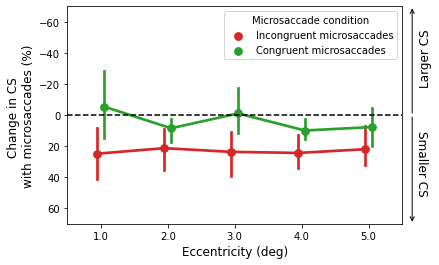

In [92]:
fig,ax=plt.subplots()
sns.pointplot(data=CS_diff,ci=95,x='ecc',y='CS_diff',dodge=0.1,palette=['C3','C2'],hue='microsaccade_condition')
ax.set_xlabel('Eccentricity (deg)',size=12)
# plt.ylabel("CS Trials W/O Microsaccades \n - CS Trials W Microsaccades (%)",size=12)
ax.set_ylabel("Change in CS \nwith microsaccades (%)",size=12)
ax.axhline(y=0,xmin=0,xmax=1,ls='--',color='k')
L=ax.legend(title='Microsaccade condition')
L.get_texts()[0].set_text('Incongruent microsaccades')
L.get_texts()[1].set_text("Congruent microsaccades")
ax.set_ylim(70,-70)
ax.annotate('', xy=(1.03, 0.5), xycoords='axes fraction', xytext=(1.03, 1), 
            arrowprops=dict(arrowstyle="<-", color='k'))
ax.text(4.75,-20,'Larger CS',rotation=90,size=12)
ax.annotate('', xy=(1.03, 0.5), xycoords='axes fraction', xytext=(1.03, 0), 
            arrowprops=dict(arrowstyle="<-", color='k'))
ax.text(4.69,50,'Smaller CS',rotation=270,size=12)
# plt.savefig('..\Plots\change_in_CS_from_noMicrosaccade_vs_ecc_hue_microsaccade_condition.pdf',format='pdf',dpi=1200,bbox_inches='tight')

C:\Users\krish\Anaconda3\lib\site-packages\seaborn\axisgrid.py:670: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


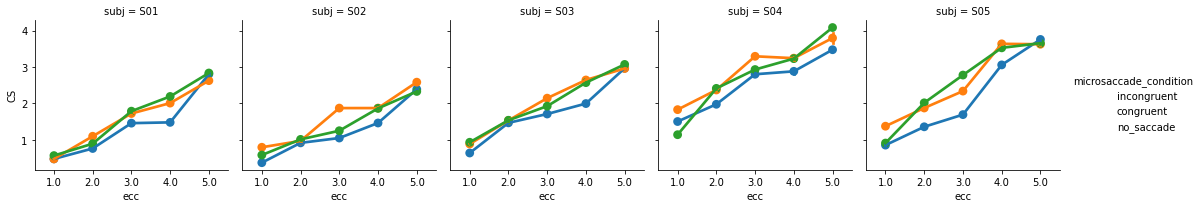

In [78]:
g=sns.FacetGrid(data=CS_df,col='subj',hue='microsaccade_condition')
g.map(sns.pointplot,'ecc','CS')
g.add_legend()

<AxesSubplot:xlabel='ecc', ylabel='boumaRatio'>

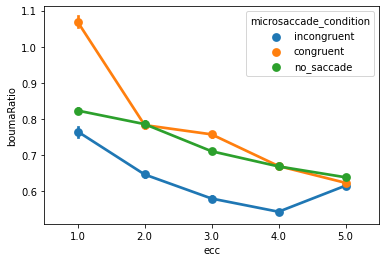

In [101]:
CS_df['boumaRatio']=CS_df['CS']/CS_df['ecc']
sns.pointplot(data=CS_df,y='boumaRatio',x='ecc',hue='microsaccade_condition')

In [97]:
df=CS_df.query("microsaccade_condition=='incongruent'").groupby('ecc').agg({'CS':['mean','std']})/CS_df.query("microsaccade_condition=='congruent'").groupby('ecc').agg({'CS':['mean','std']})

In [17]:
# We perform ANOVA on the dataframe
from statsmodels.stats.anova import AnovaRM

data=CS_df
aovrm=AnovaRM(data,'CS','subj',within=['ecc','microsaccade_condition'],aggregate_func='mean')
res=aovrm.fit()
print(res)

# Multi comparisons using tukey HSD
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison
mc1=MultiComparison(data['CS'],data['microsaccade_condition'])
result1=mc1.tukeyhsd()
print(result1)
print(mc1.groupsunique)

mc2=MultiComparison(data['CS'],data['ecc'])
result2=mc2.tukeyhsd()
print(result2)
print(mc2.groupsunique)

from statsmodels.stats.libqsturng import psturng
psturng(np.abs(result1.meandiffs / result1.std_pairs),len(result1.groupsunique),result1.df_total)
# psturng(np.abs(result2.meandiffs / result2.std_pairs),len(result2.groupsunique),result2.df_total)

                         Anova
                           F Value Num DF  Den DF Pr > F
--------------------------------------------------------
ecc                        90.3522 4.0000 16.0000 0.0000
microsaccade_condition     29.0460 2.0000  8.0000 0.0002
ecc:microsaccade_condition  2.3719 8.0000 32.0000 0.0395

     Multiple Comparison of Means - Tukey HSD, FWER=0.05     
   group1      group2   meandiff p-adj  lower   upper  reject
-------------------------------------------------------------
  congruent incongruent  -0.3309 0.001  -0.353 -0.3088   True
  congruent  no_saccade  -0.0615 0.001 -0.0836 -0.0394   True
incongruent  no_saccade   0.2694 0.001  0.2473  0.2915   True
-------------------------------------------------------------
['congruent' 'incongruent' 'no_saccade']
Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
   1.0    2.0   0.5911 0.001 0.5683 0.6139   True
   1.0

array([0.001, 0.001, 0.001])

# Microsaccade direction

In [ ]:
# we creat the spacing condition parameter for the merged saccade dataframe
leftVrightData['ecc_cond']=np.where((leftVrightData['ecc']>3),'peripheral','parafoveal')
leftVrightData['spacing_cond']=np.where((leftVrightData['spacing']<=3),'close','far')

In [20]:
# We get the number of saccades detected for each eccentricity
leftVrightData.groupby('ecc')['Duration'].count()

ecc
1.0    11482
2.0    11628
3.0    11628
4.0    12061
5.0    11757
Name: Duration, dtype: int64

C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_tight" which is no longer supported as of 3.3 and will become an error two minor releases later


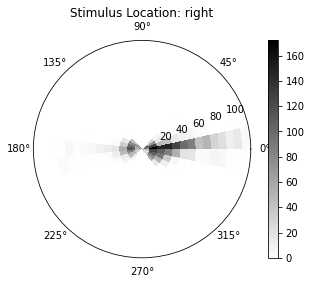

In [11]:
import numpy as np; np.random.seed(42)
import matplotlib.pyplot as plt
stim_locs=['left','right']

pltCounter=1
for aloc in stim_locs:
    # two input arrays
    data=leftVrightData.query("VectorAmp<2 & stim_loc==@aloc & 0.150<relOnsetTime<0.464")
    azimut=np.radians(data['DirectionPolar'])
    radius=data['VectorAmp']*60

    # define binning
    rbins = np.linspace(0,radius.max(), 15)
    abins = np.linspace(0,2*np.pi, 30)

    #calculate histogram
    hist, _, _ = np.histogram2d(azimut, radius, bins=(abins, rbins))
    A, R = np.meshgrid(abins, rbins)

    # plot
    fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
    pc = ax.pcolormesh(A, R, hist.T, cmap="binary")
    ax.set_theta_zero_location("E")  # theta=0 on the left
    ax.set_theta_direction(1) 
    ax.set_title('Stimulus Location: %s'%(aloc),y=1.08)
    fig.colorbar(pc)
    pltCounter+=1
    plotFilename=('..\Plots\MicrosaccadeDirection_%s.svg'%(aloc))
    plt.savefig(plotFilename,bbox_tight= True,format='svg',dpi=1200)


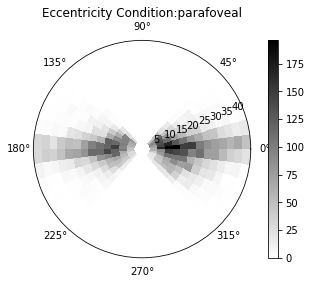

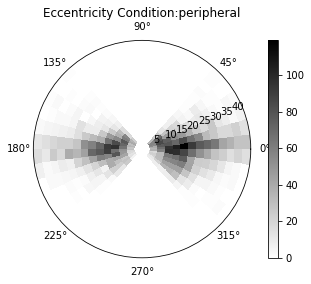

In [9]:
import numpy as np; np.random.seed(42)
import matplotlib.pyplot as plt

ecc_conds=['parafoveal','peripheral']
spacing_conds=['close','far']
# two input arrays
for ecc_cond in ecc_conds:
    data=leftVrightData.query("VectorAmp<0.75 & ecc_cond==@ecc_cond & <relOnsetTime<0.6")
    azimut=np.radians(data['DirectionPolar'])
    radius=data['VectorAmp']*60

    # define binning
    rbins = np.linspace(0,radius.max(), 15)
    abins = np.linspace(0,2*np.pi, 45)

    #calculate histogram
    hist, _, _ = np.histogram2d(azimut, radius, bins=(abins, rbins))
    A, R = np.meshgrid(abins, rbins)

    # plot
    fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
    pc = ax.pcolormesh(A, R, hist.T, cmap="binary")
    ax.set_theta_zero_location("E")  # theta=0 on the left
    ax.set_theta_direction(1) 
    ax.set_title('Eccentricity Condition:%s'%(ecc_cond),y=1.08)
    fig.colorbar(pc)
    plotFilename='..\Plots\MicrosaccadeDirectionEcc%s.svg'%(ecc_cond)
#     plt.savefig(plotFilename,bbox_tight= True)


In [ ]:
import numpy as np; np.random.seed(42)
import matplotlib.pyplot as plt

ecc_conds=['parafoveal','peripheral']
spacing_conds=['close','far']
# two input arrays
for aspacing in spacing_conds:
    data=leftVrightData.query("VectorAmp<0.75 & spacing_cond==@aspacing & -0.4<relOnsetTime<0.6 ")
    azimut=np.radians(data['DirectionPolar'])
    radius=data['VectorAmp']*60

    # define binning
    rbins = np.linspace(0,radius.max(), 15)
    abins = np.linspace(0,2*np.pi, 45)

    #calculate histogram
    hist, _, _ = np.histogram2d(azimut, radius, bins=(abins, rbins))
    A, R = np.meshgrid(abins, rbins)

    # plot
    fig, ax = plt.subplots(subplot_kw=dict(projection="polar"))
    pc = ax.pcolormesh(A, R, hist.T, cmap="binary")
    ax.set_theta_zero_location("E")  # theta=0 on the left
    ax.set_theta_direction(1) 
    ax.set_title('Spacing Condition:%s'%(aspacing),y=1.08)
    fig.colorbar(pc)
    plotFilename='..\Plots\MicrosaccadeDirectionEcc%s.svg'%(aspacing)
#     plt.savefig(plotFilename,bbox_tight= True)


C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: UserWarning: FixedFormatter should only be used together with FixedLocator


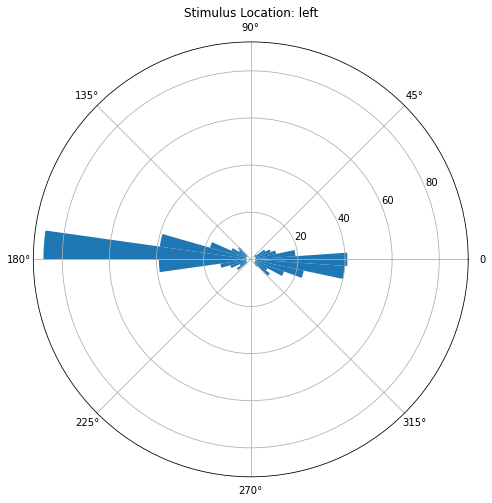

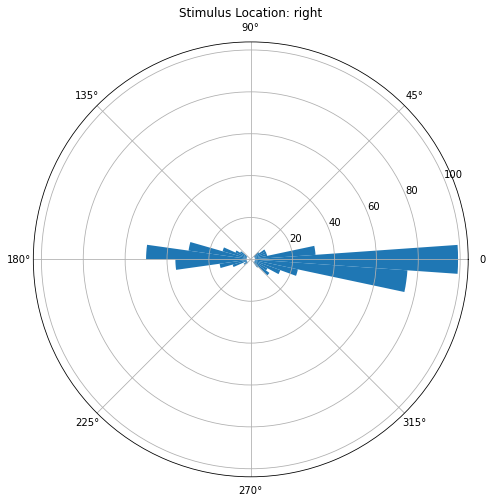

In [19]:
dirs_list=['left','right']
for i in range(2):
    # two input arrays
    dir_input=dirs_list[i]
    data=leftVrightData.query("stim_loc==@dir_input & 0<relOnsetTime<0.200")
    arr=np.radians(data['DirectionPolar'])
    # radius=data['VectorAmp']*60


    N = 45
    bottom = 2

    # create theta for 24 hours
    theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

    # make the histogram that bined on 24 hour
    radii, tick = np.histogram(arr, bins = N)

    # width of each bin on the plot
    width = (2*np.pi) / N

    # make a polar plot
    plt.figure(figsize = (12, 8))
    ax = plt.subplot(111, polar=True)
    bars = ax.bar(theta, radii, width=width, bottom=bottom)

    # set the lable go clockwise and start from the top
    ax.set_theta_zero_location("E")
    # counter-clockwise
    ax.set_theta_direction(1)

    # set the label
    ticks = ['0', '45°', '90°', '135°', '180°', '225°', '270°', '315°']
    ax.set_xticklabels(ticks)

    plt.title('Stimulus Location: %s'%(dir_input))
    plt.savefig("..\Plots\Microsaccade_direction_distribtion_%s.svg"%(dir_input),dpi=1200)

C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator


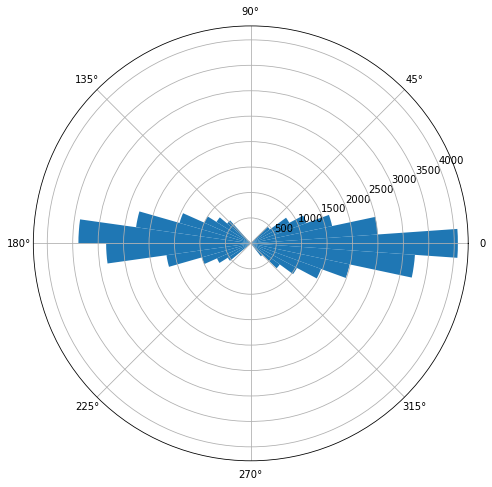

In [5]:

# two input arrays
data=leftVrightData
arr=np.radians(data['DirectionPolar'])
# radius=data['VectorAmp']*60


N = 45
bottom = 2

# create theta for 24 hours
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)

# make the histogram that bined on 24 hour
radii, tick = np.histogram(arr, bins = N)

# width of each bin on the plot
width = (2*np.pi) / N

# make a polar plot
plt.figure(figsize = (12, 8))
ax = plt.subplot(111, polar=True)
bars = ax.bar(theta, radii, width=width, bottom=bottom)

# set the lable go clockwise and start from the top
ax.set_theta_zero_location("E")
# counter-clockwise
ax.set_theta_direction(1)

# set the label
ticks = ['0', '45°', '90°', '135°', '180°', '225°', '270°', '315°']
ax.set_xticklabels(ticks)

plt.savefig("..\Plots\Microsaccade_direction_distribtion.svg",dpi=1200)

In [145]:
mydata['VectorAmp'].median()*60

15.130059319326456

C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:32: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox_tight" which is no longer supported as of 3.3 and will become an error two minor releases later


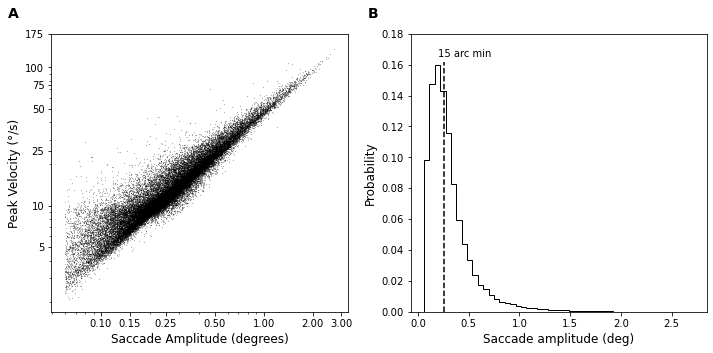

In [23]:
#TODO sns plot by subject
# plt.figure(figsize=(20,10))
fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(10,5))
counter=0
for col in ax:
    if counter==0:
        mydata=leftVrightData.query("-0.800<relOnsetTime<0.800")
        mydata['AmpArcMin']=mydata['VectorAmp']*60
        col.scatter(mydata['VectorAmp'],mydata['peakVel'],marker='.',s=0.05,color='k')
        # sns.lmplot(x="AmpArcMin",y="peakVel",data=mydata,fit_reg=False,markers='o', scatter_kws={"s": 0.05,"color":'k'})
        col.set_xlabel('Saccade Amplitude (degrees)',size=12)
        col.set_ylabel('Peak Velocity (°/s)',size=12)
        # plt.ylim(0,30)
        col.set_xscale('log')
        col.set_xticks([0.1,0.15,0.25,0.5,1, 2,3])
        col.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        col.set_yscale('log')
        col.set_yticks([5,10,25,50,75, 100,175])
        col.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        col.text(0.0265,227.5,r'$\bf{A}$',size=14)
    else:
        weights = np.ones_like(mydata['VectorAmp'])/float(len(mydata['VectorAmp']))
        col.hist((mydata['VectorAmp']),bins=50,histtype='step',color='k',weights=weights)
        col.set_xlabel('Saccade amplitude (deg)',size=12)
        col.set_ylabel('Probability',size=12)
        col.axvline(x=mydata['VectorAmp'].median(),ymin=0,ymax=0.9,ls='--',color='k')
        col.text(mydata['VectorAmp'].median()-0.05,0.165,"15 arc min")
        plt.ylim(0,0.18)
        col.text(-0.5,0.19,r"$\bf{B}$",size=14)
    counter+=1
fig.tight_layout()
plt.savefig('..\Plots\MainSeqPlot_ArcMin&SaccadeAmplitude.pdf',dpi=1200,bbox_tight=True)

In [17]:
# calculate Pearson's correlation
scipy.stats.pearsonr(mydata['VectorAmp'],mydata['peakVel'])

(0.9646528960309877, 0.0)

In [ ]:
def rose_plot(ax, angles, bins=16, density=None, offset=0, lab_unit="degrees",
              start_zero=False, **param_dict):
    """
    Plot polar histogram of angles on ax. ax must have been created using
    subplot_kw=dict(projection='polar'). Angles are expected in radians.
    """
    # Wrap angles to [-pi, pi)
    angles = (angles + np.pi) % (2*np.pi) - np.pi

    # Set bins symetrically around zero
    if start_zero:
        # To have a bin edge at zero use an even number of bins
        if bins % 2:
            bins += 1
        bins = np.linspace(-np.pi, np.pi, num=bins+1)

    # Bin data and record counts
    count, bin = np.histogram(angles, bins=bins)

    # Compute width of each bin
    widths = np.diff(bin)

    # By default plot density (frequency potentially misleading)
    if density is None or density is True:
        # Area to assign each bin
        area = count / angles.size
        # Calculate corresponding bin radius
        radius = (area / np.pi)**.5
    else:
        radius = count

    # Plot data on ax
    ax.bar(bin[:-1], radius, zorder=1, align='edge', width=widths,
           edgecolor='C0', fill=False, linewidth=1)

    # Set the direction of the zero angle
    ax.set_theta_offset(offset)

    # Remove ylabels, they are mostly obstructive and not informative
    ax.set_yticks([])
#     ax.set_ylim(0,0.40)
    ax.tick_params(axis='both',which='major',labelsize=10)

    if lab_unit == "radians":
        label = ['$0$', r'$\pi/4$', r'$\pi/2$', r'$3\pi/4$',
                  r'$\pi$', r'$5\pi/4$', r'$3\pi/2$', r'$7\pi/4$']
        ax.set_xticklabels(label)

# Microsaccade metrics Vs Experiment Parameters/Behavioral response

In [ ]:
# #microsaccade rate calc
# codeList=eyepos['trialCode'].unique()
# microSaccRate=pd.DataFrame({'msaccRate':[],'trialDur':[],'trialCode':[]})
# num_elements=len(codeList)
# counter=0
# for acode in codeList:
#     update_progress(counter/num_elements)
#     counter+=1
#     tempSacc=saccData.query("trialCode==@acode")
#     tempeyepos=eyepos.query("trialCode==@acode")
#     trialDur=tempeyepos.iloc[-1,2]-tempeyepos.iloc[0,2]
#     numSacc=len(tempSacc)
#     saccRate=numSacc/trialDur
#     microSaccRate=microSaccRate.append({'msaccRate':saccRate,'trialDur':trialDur,'trialCode':acode},ignore_index=True)
# mSaccMerge=pd.merge(microSaccRate,behavData,left_on='trialCode',right_on='trialCode')
# # mSaccMerge.to_pickle('mSaccMerge.pkl')

In [ ]:
# sns.pointplot(x='spacing',y='msaccRate',data=mSaccMerge)
# plt.ylabel('Microsaccadic rate (num/s)',size=12)
# plt.xlabel('Spacing (nominal)',size=12)
# # plt.savefig('MicrosaccadicRateVspacing.pdf',bbox_tight=True)

In [ ]:
# sns.pointplot(x='ecc',y='msaccRate',data=mSaccMerge)
# plt.ylabel('Microsaccadic rate (num/s)',size=12)
# plt.xlabel('Eccentricity (deg)',size=12)
# # plt.savefig('MicrosaccadicRateVspacing.pdf',bbox_tight=True)

In [ ]:
# sns.pointplot(x='corr',y='msaccRate',data=mSaccMerge)
# plt.ylabel('Microsaccadic rate (num/s)',size=12)
# plt.xlabel('Response outcome',size=12)
# # plt.savefig('MicrosaccadicRateVcorrect.pdf',bbox_tight=True)

In [ ]:
# g=sns.pointplot(x='spacing',y='RT',data=behavData)
# g.set(xticklabels=['1.4x','2.0x','5.0x','Unflanked'])
# plt.ylabel('Reaction Time (s)',size=12)
# plt.xlabel('Spacing (nominal)',size=12)
# plt.savefig('ReactionTimeVspacing.pdf',bbox_tight=True)

In [ ]:
g=sns.FacetGrid(data=leftVrightData,col='corr',hue='subj_id')
g.map(sns.pointplot,'spacing','RT')
g.axes[0,0].set_xlabel('Spacing (nominal)')
g.axes[0,0].set_ylabel('RT (s)')
g.axes[0,1].set_xlabel('Spacing (nominal)')
xticklabels=['1.6','2','3','5','Unflanked']
g.set_xticklabels(xticklabels)
# plt.savefig('.\Plots\Prelim\RTvSpacingbyresponse.pdf')

In [ ]:
sns.pointplot(x='ecc',y='RT',hue='subj_id',data=behavData)
plt.ylabel('RT (s)',size=12)
plt.xlabel('Eccentricity (deg)',size=12)
plt.ylim(0.6,1.1)
# plt.savefig('.\Plots\Prelim\RTvEcc.pdf')

In [ ]:
sns.pointplot(x='spacing',y='RT',hue='subj_id',data=leftVrightData)
plt.xlabel('Spacing (nominal)',size=12)
plt.ylabel('RT (s)',size=12)
plt.ylim(0.6,1.1)
xticklabels=['1.6','2','3','5','Unflanked']
plt.xticks([0,1,2,3,4],xticklabels)
# plt.savefig('.\Plots\Prelim\RTvSpacing.pdf')

In [ ]:
leftVrightData.query("resp==target").groupby(['ecc','spacing'])['target'].count()

In [ ]:
sns.pointplot(x='target',y='corr',color='k',data=leftVrightData)
plt.ylim(0,1)
plt.xlabel('Target: Number',size=12)
plt.ylabel('Proportion Correction',size=12)
# plt.savefig('.\Plots\Prelim\perfVtargetnum.pdf')

# Microsaccade analysis:Binning method

## Binning microsaccadic rates

In [ ]:
plot_=sns.lineplot(x='binPt',y='Count',ci=95,data=BinnedDataLowSampled)
plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0],label='Stimulus onset')
plt.xlabel('Time from Stimulus onset (s)',size=12)
plt.ylabel('Rate (num/s)',size=12)
plt.xlim(-0.4,0.8)
# plt.ylim(0,2)
plt.legend()
# plt.savefig('.\Plots\Prelim\MicrosaccadicRate.pdf')

In [ ]:
plot_=sns.lineplot(x='binPt',y='Count',hue='spacing_cond',ci=95,data=BinnedDataLowSampled)
plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0])
plt.xlabel('Time from Stimulus onset (s)',size=12)
plt.ylabel('Rate (num/s)',size=12)
plt.xlim(-0.4,0.8)
# plt.ylim(0,2)
plt.legend(loc='best')
# plt.savefig('.\Plots\Prelim\MicrosaccadicRate.pdf')

In [ ]:
plot_=sns.lineplot(x='binPt',y='Count',hue='corr',ci=95,data=BinnedDataLowSampled)
plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0])
plt.xlabel('Time from Stimulus onset (s)',size=12)
plt.ylabel('Rate (num/s)',size=12)
plt.xlim(-0.4,0.8)
# plt.ylim(0,2)
plt.legend(loc='best')
# plt.savefig('.\Plots\Prelim\MicrosaccadicRate.pdf')

In [ ]:
BinnedData['rate']=BinnedData['Count']*4
plot_=sns.lineplot(x='binPt',y='rate',ci=95,data=BinnedData)
plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0],label='Stimulus onset')
plt.xlabel('Time from Stimulus onset (s)',size=12)
plt.ylabel('Rate (num/s)',size=12)
plt.xlim(-0.4,0.8)
# plt.ylim(0,2)
plt.legend()
# plt.savefig('.\Plots\Prelim\MicrosaccadicRate.pdf')

## Reaction time binning method

In [ ]:
data=leftVrightData.query("-.4<relOnsetTime<0.8")
trialWsaccCode=data['trialCode'].unique()
trialWOsacc=behavData.query("trialCode not in @trialWsaccCode")

In [ ]:
sns.lineplot(x='binPt',y='RT',ci=95,data=BinnedData)
plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0],label='Stimulus onset')
plt.ylabel('RT (s)',size=12)
plt.xlabel('Time from stimulus onset (s)',size=12)
# we first get the data for the no microsaccade condition
yVal=trialWOsacc.query("RT!='nan'")['RT']
# We compute CI
ci=sns.utils.ci(sns.algorithms.bootstrap(yVal))
diff=np.abs(yVal.mean()-ci[0])
min=plt.xlim()[0]
max=plt.xlim()[1]
plt.hlines(xmin=min,xmax=max,y=yVal.mean(),ls='--',color=[0,0,0])
x=linspace(min,max,10)
y=np.repeat(yVal.mean(),len(x))
plt.fill_between(x, (y-diff),(y+diff), color='b', alpha=.1)
plt.xlim(-0.4,0.4)
plt.ylim(0.6,1)
plt.legend()
plt.savefig('..\Plots\Microsaccades&RT.svg',format='svg',dpi=1200)

In [ ]:
g=sns.FacetGrid(BinnedData,col='ecc')
g.map(sns.lineplot,'binPt','propCong')
plt.ylabel('RT (s)',size=12)
plt.xlabel('Time from stimulus onset (s)',size=12)
plt.legend(loc='lower right')

In [ ]:
# noSaccPeripheral=trialWOsacc.query("ecc>3")
# noSaccParafoveal=trialWOsacc.query("ecc<3")
sns.lineplot(x='binPt',y='RT',hue='ecc_cond',data=BinnedData)
# plt.axhline(y=noSaccPeripheral['RT'].mean(),xmin=0,xmax=1,ls='--',color='darkorange')
# plt.axhline(y=noSaccParafoveal['RT'].mean(),xmin=0,xmax=1,ls='--',color='royalblue')
plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0])
plt.ylabel('RT (s)',size=12)
plt.xlabel('Time from stimulus onset (s)',size=12)
plt.legend(loc='lower right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.xlim(-0.4,0.4)
# plt.ylim(0.2,0.8)
# plt.savefig('.\Plots\Prelim\RTmodulationbyEcc.pdf',bbox_inches='tight')

In [ ]:
# noSaccClose=trialWOsacc.query("spacing<=3")
# noSaccFar=trialWOsacc.query("spacing>3")
sns.lineplot(x='binPt',y='RT',hue='spacing_cond',data=BinnedData)
# plt.axhline(y=noSaccFar['RT'].mean(),xmin=0,xmax=1,ls='--',color='darkorange')
# plt.axhline(y=noSaccClose['RT'].mean(),xmin=0,xmax=1,ls='--',color='royalblue')
plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0])
plt.ylabel('RT (s)',size=12)
plt.xlabel('Time from stimulus onset (s)',size=12)
plt.legend(loc='lower right')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.xlim(-0.4,0.4)
# plt.ylim(0.2,0.8)
# plt.savefig('.\Plots\Prelim\RTmodulationbySpacing.pdf',bbox_inches='tight')

In [ ]:
sns.lineplot(x='binPt',y='RT',hue='target_difficulty',data=BinnedData)
plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0],label='Stimulus onset')
plt.ylabel('RT (s)',size=12)
plt.xlabel('Time from stimulus onset (s)',size=12)
# plt.xlim(-0.4,0.4)
# plt.ylim(0.2,0.8)
# plt.savefig('.\Plots\Prelim\RTmodulation.pdf')

## Microsaccadic direction Binning Method

In [ ]:
sns.lineplot(x='binPt',y='propCong',data=BinnedData)
plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0],label='Stimulus onset')
plt.ylabel('Proportion of trials with \ncongruent microsaccades',size=12)
plt.legend()
plt.xlabel('Time from stimulus onset (s)',size=12)
plt.xlim(-0.4,0.6)
plt.ylim(0.4,0.7)
plt.savefig('..\Plots\DirectionalModulationMicrosaccade_highSampled.svg',format='svg',dpi=1200,bbox_inches='tight')

In [ ]:
sns.lineplot(x='binPt',y='propCong',hue='corr',data=BinnedData)
plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0],label='Stimulus onset')
plt.ylabel('Proportion of trials with \ncongruent microsaccades',size=12)
plt.xlabel('Time from stimulus onset (s)',size=12)
plt.xlim(-0.4,0.6)
plt.ylim(0.4,0.7)
plt.savefig('..\Plots\DirectionalModulationMicrosaccadeByresponse.svg',format='svg',dpi=1200)

In [ ]:
g=sns.FacetGrid(data=BinnedData,col='spacing_cond',hue='corr')
g.map(sns.lineplot,'binPt','propCong')
g.axes[0,0].set_xlabel('Time from stimulus onset (s)')
g.axes[0,0].set_xlim(-0.4,0.6)
g.axes[0,0].set_ylim(0.4,0.7)
g.axes[0,0].set_ylabel('Proportion of trials with \ncongruent microsaccades')
g.axes[0,1].set_xlabel('Time from stimulus onset (s)')
g.axes[0,1].set_xlim(-0.4,0.6)
g.axes[0,1].set_ylim(0.4,0.7)
g.add_legend(title='Behavioral \n outcome')
# Add stimulus onset
axes = g.fig.axes
for ax in axes:
    ax.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0])
# Change column headers
for ax, title in zip(g.axes.flat, ['Crowded Trials', 'Uncrowded Trials']):
    ax.set_title(title)
# replace labels
new_labels = ['Incorrect', 'Correct']
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)
#Move legend position
leg=g._legend
leg.set_bbox_to_anchor([1.06,0.5])
# plt.savefig('..\Plots\DirectionalModulationMicrosaccadespacingCond&resp.svg',formtat='svg',dpi=1200,bbox_inches='tight')

In [ ]:
# To do look difference in behavioral and microsaccade metrics with target difficulty as hue
leftVrightData['target_difficulty']=np.where(((leftVrightData['target']==0) | (leftVrightData['target']==1) | (leftVrightData['target']==4) | (leftVrightData['target']==7)),'easy','difficult')


In [ ]:
numBins=25
df4=leftVrightData.query("0.3<relOnsetTime<0.6")
sns.distplot(df4.query("relOnsetTime<2 & target_difficulty=='easy'")['relOnsetTime'],bins=numBins)
sns.distplot(df4.query("relOnsetTime<2 & target_difficulty=='difficult'")['relOnsetTime'],bins=numBins)
# plt.xlim(0.3,0.6)

In [ ]:
plt.figure(figsize=(10,10))
BinnedData['target_difficulty']=np.where(((BinnedData['target']==0) | (BinnedData['target']==1) | (BinnedData['target']==4) | (BinnedData['target']==7)),'easy','difficult')
g=sns.FacetGrid(data=BinnedData,hue='target_difficulty')
g.map(sns.lineplot,'binPt','propCong')
g.axes[0,0].set_xlabel('Time from stimulus onset (s)')
g.axes[0,0].set_ylabel('Proportion of trials with \ncongruent microsaccades')
# g.axes[0,1].set_xlabel('Time from stimulus onset (s)')
plt.legend()
# plt.savefig('.\Plots\Prelim\DirectionalModulationMicrosaccadeBytargetnum&resp.pdf')

In [ ]:
BinnedData.query("0.150<binPt<0.160").groupby(['corr','spacing_cond'])['propCong'].mean()

In [ ]:
df=leftVrightData.query("0.3<relOnsetTime<0.4").groupby(['congruent','spacing','ecc','subj_id'])['corr'].mean().reset_index()
g=sns.FacetGrid(df,hue='congruent')
g.map(sns.lineplot,'spacing','corr')
plt.xscale('log')

In [ ]:
g=sns.FacetGrid(data=BinnedData,col='spacing')
g.map(sns.lineplot,'binPt','propCong')
g.axes[0,0].set_ylabel('Proportion of trials with \ncongruent microsaccades',size=12)
g.axes[0,0].set_xlabel('')
g.axes[0,1].set_xlabel('')
g.axes[0,2].set_xlabel('')
g.axes[0,3].set_xlabel('')
g.axes[0,4].set_xlabel('')
g.axes[0,0].set_ylim(0.2,0.8)
g.axes[0,1].set_ylim(0.2,0.8)
g.axes[0,2].set_ylim(0.2,0.8)
g.axes[0,3].set_ylim(0.2,0.8)
g.axes[0,4].set_ylim(0.2,0.8)

# Change column headers
for ax, title in zip(g.axes.flat, ['Flanked Spacing: 1.6x','Flanked Spacing: 2x','Flanked Spacing: 3x','Flanked Spacing: 5x','Flanked Spacing: Unflanked']):
    ax.set_title(title)
    
#change xlabel
g.fig.text(0.4,0,'Time relative to stimulus onset (s)',size=12)

plt.savefig('..\Plots\DirectionalModulationMicrosaccadeByspacing.svg',format='svg',dpi=1200,bbox_inches='tight')

In [ ]:
g=sns.FacetGrid(data=BinnedData,col='ecc',hue='spacing')
g.map(sns.lineplot,'binPt','propCong',ci=None)
g.axes[0,0].set_ylabel('Proportion of trials with \ncongruent microsaccades',size=12)
g.axes[0,0].set_xlabel('')
g.axes[0,1].set_xlabel('')
g.axes[0,2].set_xlabel('')
g.axes[0,3].set_xlabel('')
g.axes[0,4].set_xlabel('')
g.axes[0,0].set_ylim(0.2,0.8)
g.axes[0,1].set_ylim(0.2,0.8)
g.axes[0,2].set_ylim(0.2,0.8)
g.axes[0,3].set_ylim(0.2,0.8)
g.axes[0,4].set_ylim(0.2,0.8)

# Change column headers
# for ax, title in zip(g.axes.flat, ['Flanked Spacing: 1.6x','Flanked Spacing: 2x','Flanked Spacing: 3x','Flanked Spacing: 5x','Flanked Spacing: Unflanked']):
#     ax.set_title(title)
    
#change xlabel
g.fig.text(0.4,0,'Time relative to stimulus onset (s)',size=12)
g.add_legend()

plt.savefig('..\Plots\DirectionalModulationMicrosaccadeByeccentricity.svg',format='svg',dpi=1200,bbox_inches='tight')

In [ ]:
BinnedData.query("0.150<binPt<0.160").groupby('spacing_cond')['propCong'].mean()

In [70]:
# We run permutation test for each time point/bin step 
bins=df.binPt_x.unique()
p_vals_cong=[]
binPt_list=[]
idx=0
# loop through each bin
for abin in bins:
    print('%d/%d'%(idx,len(bins)-1),end='\r')
    idx+=1
    group1=df.query("binPt_x==@abin")['propCong']
    group2=np.repeat(0.5,len(group1))
    res=perm_test(group1,group2,10000,'mean',z_score=False)
    # append P val
    p_vals_cong.append(res['p_val'])
    binPt_list.append(abin)
    

In [ ]:
p_val_df['p_val_cong_baseline']=p_vals_cong

In [ ]:
sign_df_cong=p_val_df['bins'].iloc[np.where(p_val_df['p_val_cong_baseline']<0.001)]
print(sign_df_cong.min(),sign_df_cong.max())

In [ ]:
BinnedData['spacing_cond']=np.where(BinnedData['spacing']==100,'Unflanked','Flanked')

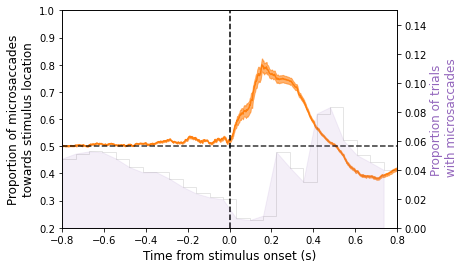

In [24]:
# Pre-process data
def col_to_code(x):
    return "%s_%s"%(x.subj_id_x,x.binPt)
# Get proportion congruent
df1=BinnedData.query("congruent==1").groupby(['binPt','subj_id_x'])['congruent'].sum().reset_index()
df1['code']=(df1.apply(col_to_code,1)).astype(str)
df2=BinnedData.groupby(['binPt','subj_id_x'])['congruent'].count().reset_index()
df2['code']=(df2.apply(col_to_code,1)).astype(str)
df=pd.merge(df1,df2,left_on='code',right_on='code')
df['propCong']=df['congruent_x']/df['congruent_y']

# Now we plot
df_mean=df.groupby(['binPt_x'])['propCong'].mean().reset_index()
# compute CI
df_std=df.groupby(['binPt_x'])['propCong'].std().reset_index()
df_count=df.groupby(["binPt_x"])['congruent_y'].mean().reset_index()
x=df_std['binPt_x']
# Column congruent y from before indicates the total count of microsaccades grouped by bin point
ci=1.96 * (df_std['propCong'])/np.sqrt(df_count['congruent_y']) 
fig,ax1=plt.subplots()
ax_twin=ax1.twinx()
ax1.fill_between(x,(df_mean['propCong']+ci),(df_mean['propCong']-ci),color='C1',alpha=0.6)
ax1.plot(df_mean['binPt_x'],df_mean['propCong'],color='C1')
ax1.set_ylim(0.2,1)
ax1.set_xlim(-0.8,0.8)
ax1.axvline(x=0,ymin=0,ymax=1,linestyle='--',color=[0,0,0])
ax1.axhline(xmin=0,xmax=1,y=0.5,linestyle='--',color=[0,0,0],alpha=0.8)
ax1.set_ylabel('Proportion of microsaccades\ntowards stimulus location',size=12)
ax1.set_xlabel('Time from stimulus onset (s)',size=12)

df1=leftVrightData.query("-0.8<relOnsetTime<0.8")
weights1 = np.ones_like(df1['relOnsetTime'])/float(len(df1['relOnsetTime']))                                              
hist,patches,obj=ax_twin.hist(df1['relOnsetTime'],weights=weights1,bins=25,histtype='step',ls='-',color='k',alpha=0.1)
ax_twin.fill_between(patches[:-1],hist*0,hist,alpha=0.1,color='C4')
ax_twin.set_ylabel('Proportion of trials\n with microsaccades',size=12,color='C4')
ax_twin.axes.set_ylim(0,0.15)

# We plot between the start and end of the region where it is significant
# start_pt=start_bins[0]
# end_pt=end_bins[-1]
# plt.fill_betweenx(y=[0,1],x1=start_pt,x2=end_pt,color=[0,0,0],alpha=0.1) 

plt.savefig('..\Plots\DirectionalModulationMicrosaccade.pdf',format='pdf',dpi=1200,bbox_inches='tight')

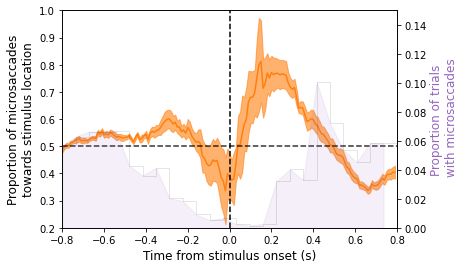

In [65]:
# Pre-process data
def col_to_code(x):
    return "%s_%s"%(x.subj_id_x,x.binPt)
# Get proportion congruent
df1=BinnedData_single_sacc.query("congruent==1").groupby(['binPt','subj_id_x'])['congruent'].sum().reset_index()
df1['code']=(df1.apply(col_to_code,1)).astype(str)
df2=BinnedData_single_sacc.groupby(['binPt','subj_id_x'])['congruent'].count().reset_index()
df2['code']=(df2.apply(col_to_code,1)).astype(str)
df=pd.merge(df1,df2,left_on='code',right_on='code')
df['propCong']=df['congruent_x']/df['congruent_y']

# Now we plot
df_mean=df.groupby(['binPt_x'])['propCong'].mean().reset_index()
# compute CI
df_std=df.groupby(['binPt_x'])['propCong'].std().reset_index()
df_count=df.groupby(["binPt_x"])['congruent_y'].mean().reset_index()
x=df_std['binPt_x']
# Column congruent y from before indicates the total count of microsaccades grouped by bin point
ci=1.96 * (df_std['propCong'])/np.sqrt(df_count['congruent_y']) 
fig,ax1=plt.subplots()
ax_twin=ax1.twinx()
ax1.fill_between(x,(df_mean['propCong']+ci),(df_mean['propCong']-ci),color='C1',alpha=0.6)
ax1.plot(df_mean['binPt_x'],df_mean['propCong'],color='C1')
ax1.set_ylim(0.2,1)
ax1.set_xlim(-0.8,0.8)
ax1.axvline(x=0,ymin=0,ymax=1,linestyle='--',color=[0,0,0])
ax1.axhline(xmin=0,xmax=1,y=0.5,linestyle='--',color=[0,0,0],alpha=0.8)
ax1.set_ylabel('Proportion of microsaccades\ntowards stimulus location',size=12)
ax1.set_xlabel('Time from stimulus onset (s)',size=12)

df1=leftVrightData_single_msacc.query("-0.8<relOnsetTime<0.8")
weights1 = np.ones_like(df1['relOnsetTime'])/float(len(df1['relOnsetTime']))                                              
hist,patches,obj=ax_twin.hist(df1['relOnsetTime'],weights=weights1,bins=25,histtype='step',ls='-',color='k',alpha=0.1)
ax_twin.fill_between(patches[:-1],hist*0,hist,alpha=0.1,color='C4')
ax_twin.set_ylabel('Proportion of trials\n with microsaccades',size=12,color='C4')
ax_twin.axes.set_ylim(0,0.15)

# We plot between the start and end of the region where it is significant
# start_pt=start_bins[0]
# end_pt=end_bins[-1]
# plt.fill_betweenx(y=[0,1],x1=start_pt,x2=end_pt,color=[0,0,0],alpha=0.1) 

plt.savefig('..\Plots\DirectionalModulationMicrosaccade_singleMicrosaccade.svg',format='svg',dpi=1200,bbox_inches='tight')

In [ ]:
g=sns.lineplot(x='binPt',y='propCong',hue='spacing_cond',data=BinnedData,palette=["C3","C2"])
g.legend(loc='upper left').texts[0].set_text("Flanker Spacing")

g.axes.axvline(x=0,ymin=0,ymax=1,linestyle='--',color=[0,0,0])
g.axes.axhline(xmin=0,xmax=1,y=0.5,linestyle='-',color=[0,0,0])
g.axes.set_ylabel('Proportion of microsaccades\ntowards stimulus location',size=12)
g.axes.set_xlabel('Time from stimulus onset (s)',size=12)
# we plot significance over this
p_vals_cong=p_val_df['p_val_cong']
bins=p_val_df['bins']
alpha_lvl=0.001
start_bins=[]
end_bins=[]
got_one=0
for idx in range(len(p_vals_cong)):
    a_pval=p_vals_cong[idx]
    abin=bins[idx]
    if a_pval<alpha_lvl and got_one==0:
        start_bins.append(abin)
        got_one=1
    elif a_pval>alpha_lvl and got_one==1:
        end_bins.append(abin)
        got_one=0
# We plot between the start and end of the region where it is significant
start_pt=start_bins[0]
end_pt=end_bins[-1]
g.axes.fill_betweenx(y=[0,1],x1=start_pt,x2=end_pt,color=[0,0,0],alpha=0.1)   
g.axes.set_xlim(-0.4,0.6)
g.axes.set_ylim(0.2,0.8)

g1=g.twinx()
df1=leftVrightData.query("-0.4<relOnsetTime<0.6")
weights1 = np.ones_like(df1['relOnsetTime'])/float(len(df1['relOnsetTime']))                                              
hist,patches,obj=g1.hist(df1['relOnsetTime'],weights=weights1,bins=25,histtype='step',ls='-',color='k',alpha=0.1)
g1.fill_between(patches[:-1],hist*0,hist,alpha=0.1,color='C4')
g1.set_ylabel('Proportion of trials\n with microsaccades',size=12,color='C4')
g1.axes.set_ylim(0,0.15)
plt.savefig('..\Plots\DirectionalModulationMicrosaccadeByspacing_cond.svg',format='svg',dpi=1200,bbox_inches='tight')

In [ ]:
g=sns.lineplot(x='binPt',y='propCong',data=BinnedData)

g.axes.axvline(x=0,ymin=0,ymax=1,linestyle='--',color=[0,0,0])
g.axes.axhline(xmin=0,xmax=1,y=0.5,linestyle='-',color=[0,0,0])
g.axes.set_ylabel('Proportion of microsaccades\ntowards stimulus location',size=12)
g.axes.set_xlabel('Time from stimulus onset (s)',size=12)
# we plot significance over this
p_vals_cong=p_val_df['p_val_cong_baseline']
bins=p_val_df['bins']
alpha_lvl=0.001
start_bins=[]
end_bins=[]
got_one=0
for idx in range(len(p_vals_cong)):
    a_pval=p_vals_cong[idx]
    abin=bins[idx]
    if a_pval<alpha_lvl and got_one==0:
        start_bins.append(abin)
        got_one=1
    elif a_pval>alpha_lvl and got_one==1:
        end_bins.append(abin)
        got_one=0
# We plot between the start and end of the region where it is significant
start_pt=start_bins[0]
end_pt=end_bins[-1]
g.axes.fill_betweenx(y=[0,1],x1=start_pt,x2=end_pt,color=[0,0,0],alpha=0.1)   
g.axes.set_xlim(-0.4,0.6)
g.axes.set_ylim(0.2,0.8)

g1=g.twinx()
df1=leftVrightData.query("-0.4<relOnsetTime<0.6")
weights1 = np.ones_like(df1['relOnsetTime'])/float(len(df1['relOnsetTime']))                                              
hist,patches,obj=g1.hist(df1['relOnsetTime'],weights=weights1,bins=25,histtype='step',ls='-',color='k',alpha=0.1)
g1.fill_between(patches[:-1],hist*0,hist,alpha=0.1,color='C4')
g1.set_ylabel('Proportion of trials\n with microsaccades',size=12,color='C4')
g1.axes.set_ylim(0,0.15)
# plt.savefig('..\Plots\DirectionalModulationMicrosaccade.svg',format='svg',dpi=1200,bbox_inches='tight')

In [ ]:
g=sns.FacetGrid(data=BinnedData,hue='spacing',height=3,aspect=5)
g.map(sns.lineplot,'binPt','propCong',ci=None)
# replace labels
g.add_legend(title='Target Flanker spacing')
new_labels = ["1.6","2","3","5","100"]
for t, l in zip(g._legend.texts, new_labels): t.set_text(l)

In [ ]:
BinnedData['target_difficulty']=np.where(((BinnedData['target']==0) | (BinnedData['target']==1) | (BinnedData['target']==4) | (BinnedData['target']==7)),'easy','difficult')

In [ ]:
sns.lineplot(x='binPt',y='propCong',ci=95,hue='target_difficulty',data=BinnedData)
plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0])
plt.ylabel('Proportion of trials with \ncongruent microsaccades',size=12)
plt.xlabel('Time from stimulus onset (s)',size=12)
plt.xlim(-0.4,0.6)
plt.ylim(0.4,0.7)
plt.savefig('..\Plots\DirectionalModulationMicrosaccadeBytargetDifficulty.svg',format='svg',dpi=1200)

In [ ]:
g=sns.FacetGrid(hue='target_difficulty',col='corr',data=BinnedData)
g.map(sns.lineplot,"binPt","propCong",ci=None)
plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0])
plt.ylabel('Proportion of trials with \ncongruent microsaccades',size=12)
plt.xlabel('Time from stimulus onset (s)',size=12)
plt.xlim(-0.4,0.6)
plt.ylim(0.4,0.7)
# plt.savefig('..\Plots\DirectionalModulationMicrosaccadeBytargetDifficultyHueResp.svg',format='svg',dpi=1200)

In [ ]:
g=sns.FacetGrid(data=BinnedData,col='corr',hue='spacing_cond')
g.map(sns.lineplot,'binPt','propCong')
g.axes[0,0].set_xlim(-0.4,0.6)
g.axes[0,0].set_xlabel('Time from stimulus onset (s)',size=12)
g.axes[0,0].set_ylabel('Proportion of trials with \ncongruent microsaccades',size=12)
g.axes[0,1].set_xlim(-0.4,0.6)
plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0])
g.add_legend()
# Add stimulus onset
axes = g.fig.axes
for ax in axes:
    ax.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0])

In [ ]:
g=sns.FacetGrid(data=BinnedData,col='subj_id',hue='spacing_cond')
g.map(sns.lineplot,'binPt','propCong')
# plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0])
g.axes[0,0].set_xlabel('Time from stimulus onset (s)')
g.axes[0,0].set_ylabel('Proportion of trials with \ncongruent microsaccades')
g.axes[0,1].set_xlabel('Time from stimulus onset (s)')
g.axes[0,1].set_xlabel('Time from stimulus onset (s)')

# plt.xlim(-0.4,0.4)
# plt.ylim(0.2,0.8)
# plt.savefig('.\Plots\Prelim\DirectionalModulationMicrosaccadeByspacing&Subj.pdf')

In [ ]:
sns.lineplot(x='binPt',y='propCong',hue='ecc_cond',data=BinnedData)
plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0])
plt.ylabel('Proportion of trials with \ncongruent microsaccades',size=12)
plt.xlabel('Time from stimulus onset (s)',size=12)
# plt.xlim(-0.4,0.4)
# plt.ylim(0.2,0.8)
# plt.savefig('.\Plots\Prelim\DirectionalModulationMicrosaccadeByEcc.pdf')

# Congruent V incongruent trials

In [6]:
eyeposMerged=pd.merge(eyepos,stimData,left_on='trialCode',right_on='trialCode')
eyeposMerged['relOnsetTime']=eyeposMerged['stimulusOnsetTime']-eyeposMerged['time']

In [55]:
df=eyepos_rel.groupby('trialCode')['time'].nth([0,-1]).reset_index()
trialDur_df=df.groupby('trialCode')['time'].diff().reset_index()
trialDur_df[~trialDur_df['time'].isnull()].query("time>0")['time'].describe()

count    3198.000000
mean        2.046658
std         0.408162
min         1.210438
25%         1.722947
50%         2.058369
75%         2.354208
max         3.777149
Name: time, dtype: float64

In [171]:
# We get relative eye positions for the two congruency conditions to see if there is a drift towards stimulus
# 1. Get info for incongruent trials
trialsWincong156to407=leftVrightData.query("@start_pt<relOnsetTime<@end_pt & congruent==0")['trialCode'].unique()
# we extract eye pos for only trials with incongruent microsaccades in the 157 -407 ms window
eyeposCode=eyeposMerged['trialCode'].unique()
incongTrials=eyeposCode[np.isin(eyeposCode,trialsWincong156to407)]
eyeposRelIncongTrials=eyeposMerged.loc[eyeposMerged['trialCode'].isin(incongTrials)]

# we segregate the eye pos based on stimulus location
eyeposIncongTrialCode=eyeposRelIncongTrials['trialCode'].unique()
#we get trial code for trials with stim on the left & right of fixation and based on behavioral response
leftStimCode_corr=behavData.query("stim_loc=='left' & corr==1")['trialCode'].unique()
leftStimCode_incorr=behavData.query("stim_loc=='left' & corr==0")['trialCode'].unique()
rightStimCode_corr=behavData.query("stim_loc=='right' & corr==1")['trialCode'].unique()
rightStimCode_incorr=behavData.query("stim_loc=='right' & corr==0")['trialCode'].unique()
#we then filter eye pos based on stim location
leftStimEyePos_incong_corr=eyeposRelIncongTrials.loc[eyeposRelIncongTrials['trialCode'].isin(leftStimCode_corr)]
leftStimEyePos_incong_incorr=eyeposRelIncongTrials.loc[eyeposRelIncongTrials['trialCode'].isin(leftStimCode_incorr)]
rightStimEyePos_incong_corr=eyeposRelIncongTrials.loc[eyeposRelIncongTrials['trialCode'].isin(rightStimCode_corr)]
rightStimEyePos_incong_incorr=eyeposRelIncongTrials.loc[eyeposRelIncongTrials['trialCode'].isin(rightStimCode_incorr)]
# We add stimulus parameter to the pandas dfs
leftStimEyePos_incong_corr['stimLoc']='left'
leftStimEyePos_incong_incorr['stimLoc']='left'
rightStimEyePos_incong_corr['stimLoc']='right'
rightStimEyePos_incong_corr['stimLoc']='right'
leftStimEyePos_incong_corr['congruency']='incongruent'
leftStimEyePos_incong_incorr['congruency']='incongruent'
rightStimEyePos_incong_corr['congruency']='incongruent'
rightStimEyePos_incong_incorr['congruency']='incongruent'
leftStimEyePos_incong_corr['corr']=1
leftStimEyePos_incong_incorr['corr']=0
rightStimEyePos_incong_corr['corr']=1
rightStimEyePos_incong_incorr['corr']=0

# 2 We get the data for the congruent trials
# we extract eye pos for only trials with congruent microsaccades in the 157 -407 ms window
trialsWcong157to407=leftVrightData.query("@start_pt<relOnsetTime<@end_pt & congruent==1")['trialCode'].unique()
eyeposCode=eyeposMerged['trialCode'].unique()
congTrials=eyeposCode[np.isin(eyeposCode,trialsWcong157to407)]
eyeposRelcongTrials=eyeposMerged.loc[eyeposMerged['trialCode'].isin(congTrials)]

# we segregate the eye pos based on stimulus location
eyeposcongTrialCode=eyeposRelcongTrials['trialCode'].unique()
#we get trial code for trials with stim on the left & right of fixation and based on behavioral response
leftStimCode_corr=behavData.query("stim_loc=='left' & corr==1")['trialCode'].unique()
leftStimCode_incorr=behavData.query("stim_loc=='left' & corr==0")['trialCode'].unique()
rightStimCode_corr=behavData.query("stim_loc=='right' & corr==1")['trialCode'].unique()
rightStimCode_incorr=behavData.query("stim_loc=='right' & corr==0")['trialCode'].unique()
#we then filter eye pos based on stim location
leftStimEyePos_cong_corr=eyeposRelcongTrials.loc[eyeposRelcongTrials['trialCode'].isin(leftStimCode_corr)]
leftStimEyePos_cong_incorr=eyeposRelcongTrials.loc[eyeposRelcongTrials['trialCode'].isin(leftStimCode_incorr)]
rightStimEyePos_cong_corr=eyeposRelcongTrials.loc[eyeposRelcongTrials['trialCode'].isin(rightStimCode_corr)]
rightStimEyePos_cong_incorr=eyeposRelcongTrials.loc[eyeposRelcongTrials['trialCode'].isin(rightStimCode_incorr)]
# We add stimulus parameter to the pandas dfs
leftStimEyePos_cong_corr['stimLoc']='left'
leftStimEyePos_cong_incorr['stimLoc']='left'
rightStimEyePos_cong_corr['stimLoc']='right'
rightStimEyePos_cong_corr['stimLoc']='right'
leftStimEyePos_cong_corr['congruency']='congruent'
leftStimEyePos_cong_incorr['congruency']='congruent'
rightStimEyePos_cong_corr['congruency']='congruent'
rightStimEyePos_cong_incorr['congruency']='congruent'
leftStimEyePos_cong_corr['corr']=1
leftStimEyePos_cong_incorr['corr']=0
rightStimEyePos_cong_corr['corr']=0
rightStimEyePos_cong_incorr['corr']=0

# we then combine the 4 different dataframes together
eyepos_segregated=pd.DataFrame().append([leftStimEyePos_incong_corr,leftStimEyePos_incong_incorr,rightStimEyePos_incong_corr,rightStimEyePos_incong_incorr,leftStimEyePos_cong_corr,leftStimEyePos_cong_incorr,rightStimEyePos_cong_corr,rightStimEyePos_cong_incorr])

C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pand

In [172]:
eyepos_mean_x=eyepos_segregated.groupby("subj_id_x")['xpos'].mean().reset_index()
eyepos_mean_y=eyepos_segregated.groupby("subj_id_x")['ypos'].mean().reset_index()
subs=eyepos_segregated.subj_id_x.unique()
eyepos_rel=[]
for asub in subs:
    xpos_mean=eyepos_mean_x.query("subj_id_x==@asub")['xpos'].values[0]
    ypos_mean=eyepos_mean_y.query("subj_id_x==@asub")['ypos'].values[0]
    #get subj eye positions
    eyepos_subj=eyepos_segregated.query("subj_id_x==@asub")
    # subtract off the mean from x & y positions
    eyepos_subj['xpos']=eyepos_subj['xpos']-xpos_mean
    eyepos_subj['ypos']=eyepos_subj['ypos']-ypos_mean
    #append to another df
    eyepos_rel.append(eyepos_subj)
    
eyepos_rel=pd.concat(eyepos_rel)

C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [98]:
subs=eyepos_rel.subj_id_x.unique()
eyepos_smoothed=[]
#Bin params
stepSize=0.002 #seconds
binSize=0.100
startPt=-0.800
endPt=0.800
bins=np.arange(startPt,endPt,stepSize)
numelements=len(subs)*len(bins)
binWidth=binSize/2
counter=1
for asub in subs:
    for abin in bins:
        start=abin-binWidth
        end=abin+binWidth
        print('%d/%d'%(counter,numelements),end='\r')
        temp_eyeposDF=eyepos_rel.query("@start<relOnsetTime<@end & subj_id_x==@asub").drop_duplicates(subset=['trialCode'])
        temp_eyeposDF['binPt']=abin
        eyepos_smoothed.append(temp_eyeposDF)
        counter+=1
        
eyepos_smoothed=pd.concat(eyepos_smoothed)
eyepos_smoothed.to_csv("eyepos_smoothed.csv")

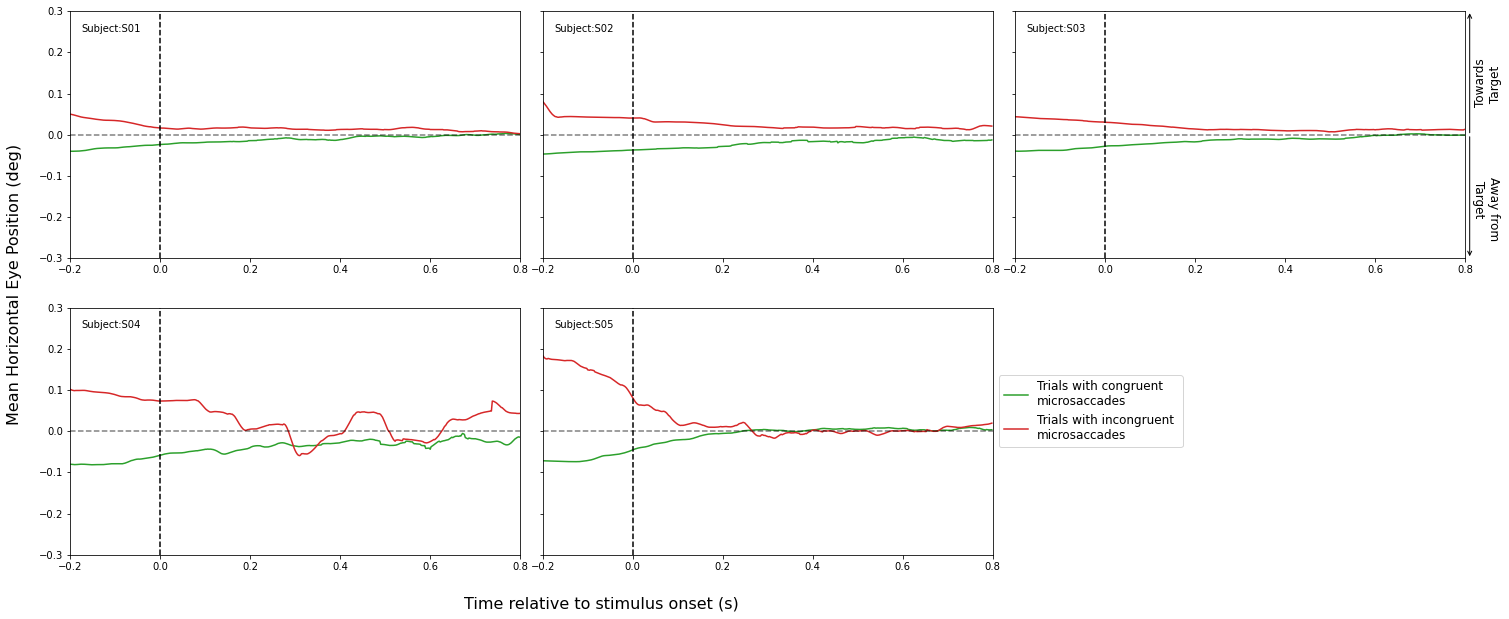

In [25]:
fig,ax=plt.subplots(nrows=2,ncols=3,figsize=(25,10),sharey=True)
subs=eyepos_smoothed.subj_id_x.unique()
fix_cross=False
# we also save the combined data
cong_df=[]
incong_df=[]
subCounter=0
for row in ax:
    for col in row:
        if subCounter!=5:
            asub=subs[subCounter]
            # First we get data for stimuli located to the left from fixation
            df1_left_cong=eyepos_smoothed.query("stimLoc=='left' & subj_id_x==@asub & congruency=='congruent'").groupby("binPt")['xpos'].mean().reset_index()
            df1_left_incong=eyepos_smoothed.query("stimLoc=='left' & subj_id_x==@asub & congruency=='incongruent'").groupby("binPt")['xpos'].mean().reset_index()
            # we flip the x data so positive always indicates towards the target location
            df1_left_cong['xpos']=-df1_left_cong['xpos']
            df1_left_incong['xpos']=-df1_left_incong['xpos']
            # We do the same for stimuli location to the right from fixation
            df2_right_cong=eyepos_smoothed.query("stimLoc=='right' & subj_id_x==@asub & congruency=='congruent'").groupby("binPt")['xpos'].mean().reset_index()
            df2_right_incong=eyepos_smoothed.query("stimLoc=='right' & subj_id_x==@asub & congruency=='incongruent'").groupby("binPt")['xpos'].mean().reset_index()
            # we then append the two dataframes together
            df1=df1_left_cong.append(df2_right_cong)
            df2=df1_left_incong.append(df2_right_incong)
            # we then group by bin point and get means
            df1_cong=df1.groupby('binPt')['xpos'].mean().reset_index()
            df2_incong=df2.groupby('binPt')['xpos'].mean().reset_index()
            # we add subject and congruency column to this
            df1_cong['subj']=asub
            df1_cong['congruency']='congruent'
            df2_incong['subj']=asub
            df2_incong['congruency']='incongruent'
            #We append this to separate df
            cong_df.append(df1_cong)
            incong_df.append(df2_incong)
            # We then plot the congruent and incongruent for both stimulus locations together
            col.plot(df1_cong['binPt'],df1_cong['xpos'],label='Trials with congruent \nmicrosaccades',color='C2')
            col.plot(df2_incong['binPt'],df2_incong['xpos'],label='Trials with incongruent \nmicrosaccades',color='C3')

            col.set_ylim(-0.3,0.3)
            col.set_xlim(-0.2,0.8)
            col.axvline(x=0,ls='--',color='k')
            col.axhline(y=0,ls='--',color='k',alpha=0.5)
            if subCounter==4:
                col.legend(bbox_to_anchor=(1,0.75),fontsize=12)
            if subCounter==2:
                col.annotate('', xy=(1.01, 0.5), xycoords='axes fraction', xytext=(1.01, 1), 
                    arrowprops=dict(arrowstyle="<-", color='k'),ha='center',va='center')
                col.text(0.820,0.075,'Towards\n Target',rotation=90,size=12)
                col.annotate('', xy=(1.01, 0.5), xycoords='axes fraction', xytext=(1.01, 0), 
                            arrowprops=dict(arrowstyle="<-", color='k'),ha='center',va='center')
                col.text(0.815,-0.25,'Away from\n Target',rotation=-90,size=12)
            col.text(col.get_xlim()[0]+0.025,col.get_ylim()[1]-0.05,"Subject:%s"%(asub))
            # Draw cross to represent fixation cross
            if fix_cross==True:
                xpos_cross=col.get_xlim()[1]-0.2
                col.plot([xpos_cross,xpos_cross],[-0.18,0.18],color='k')
                col.plot([0.45,0.75],[0,0],color='k')
                col.plot(xpos_cross,0,'o',color='grey')
            subCounter+=1
        else:
            fig.delaxes(col)
fig.text(0.42,0.05,"Time relative to stimulus onset (s)",ha='center',size=16)
fig.text(0.09,0.5,"Mean Horizontal Eye Position (deg)",rotation='vertical',va='center',size=16)
fig.subplots_adjust(wspace=0.05)
plt.savefig("..\Plots\MeanXposVsTime.pdf",dpi=1200,bbox_inches='tight')

# Finally, we compile the dataframe that was built inside the loop
cong_df=pd.concat(cong_df)
incong_df=pd.concat(incong_df)
# we get combined DF
congruency_eyepos_df=cong_df.append(incong_df)

In [27]:
## We compute the bias in eye position during stimulus onset time and look at relationship to behavioral performance
PosAtOnset=eyeposMerged.query("0<relOnsetTime<0.100").groupby("trialCode")['xpos'].mean().reset_index()
PosAtOnset=pd.merge(PosAtOnset,behavData,left_on='trialCode',right_on='trialCode')

# Trials with incong microsaccades
trialsWincong156to407=leftVrightData.query("@start_pt<relOnsetTime<@end_pt & congruent==0")['trialCode'].unique()
# we extract eye pos for only trials with incongruent microsaccades in the 157 -407 ms window
eyeposCode=PosAtOnset['trialCode'].unique()
incongTrials=eyeposCode[np.isin(eyeposCode,trialsWincong156to407)]
PosIncongTrials=PosAtOnset.loc[PosAtOnset['trialCode'].isin(incongTrials)]
PosIncongTrials['congruency']='incongruent'
# Separate based on stimulus location
PosIncongTrials_left=PosIncongTrials.query("stim_loc=='left'")
PosIncongTrials_right=PosIncongTrials.query("stim_loc=='right'")
PosIncongTrials_left['xpos']=- PosIncongTrials_left['xpos']
PosIncongTrials=PosIncongTrials_left.append(PosIncongTrials_right)
PosIncongTrials['xArcMin']=PosIncongTrials['xpos']*60

# we extract eye pos for only trials with congruent microsaccades in the 157 -407 ms window
trialsWcong157to407=leftVrightData.query("@start_pt<relOnsetTime<@end_pt & congruent==1")['trialCode'].unique()
eyeposCode=PosAtOnset['trialCode'].unique()
congTrials=eyeposCode[np.isin(eyeposCode,trialsWcong157to407)]
PoscongTrials=PosAtOnset.loc[PosAtOnset['trialCode'].isin(congTrials)]
PoscongTrials['congruency']='congruent'
# Separate based on stimulus location
PoscongTrials_left=PoscongTrials.query("stim_loc=='left'")
PoscongTrials_right=PoscongTrials.query("stim_loc=='right'")
PoscongTrials_left['xpos']=- PoscongTrials_left['xpos']
PoscongTrials=PoscongTrials_left.append(PoscongTrials_right)
PoscongTrials['xArcMin']=PoscongTrials['xpos']*60

# We do the same thing for trials without microsaccades
noSaccWindow="@start_pt<relOnsetTime<@end_pt"#"-0.4<relOnsetTime<0.8"
data=leftVrightData.query(noSaccWindow)
trialWsaccCode=data['trialCode'].unique()
trialWOsaccRaw=behavData[~behavData.trialCode.isin(trialWsaccCode)]
eyeposCode=PosAtOnset['trialCode'].unique()
noSaccTrials=eyeposCode[np.isin(eyeposCode,trialWOsaccRaw)]
PosWOsaccTrials=PosAtOnset.loc[PosAtOnset['trialCode'].isin(noSaccTrials)]
PosWOsaccTrials['congruency']='no microsaccade'
# Separate based on stimulus location
PosWOsaccTrials_left=PosWOsaccTrials.query("stim_loc=='left'")
PosWOsaccTrials_right=PosWOsaccTrials.query("stim_loc=='right'")
PosWOsaccTrials_left['xpos']=- PosWOsaccTrials_left['xpos']
PosWOsaccTrials=PosWOsaccTrials_left.append(PosWOsaccTrials_right)
PosWOsaccTrials['xArcMin']=PosWOsaccTrials['xpos']*60


# We combine two dfs together
posDF=PosIncongTrials.append(PoscongTrials)
posDF=posDF.append(PosWOsaccTrials)

NameError: name 'eyeposMerged' is not defined

In [101]:
eyepos_mean_x=posDF.groupby("subj_id")['xArcMin'].mean().reset_index()
subs=posDF.subj_id.unique()
posDF_rel=[]
for asub in subs:
    xpos_mean=eyepos_mean_x.query("subj_id==@asub")['xArcMin'].values[0]
    #get subj eye positions
    eyepos_subj=posDF.query("subj_id==@asub")
    # subtract off the mean from x & y positions
    eyepos_subj['xArcMin']=eyepos_subj['xArcMin']-xpos_mean
    #append to another df
    posDF_rel.append(eyepos_subj)
    
posDF_rel=pd.concat(posDF_rel)

C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [26]:
binCenter=[-35,-25,-15,-5,5,15,25,35]
binWidth=5
posDF_binned=[]
subs=behavData.subj_id.unique()
for asub in subs:
    for abin in binCenter:
        start_bin=abin-binWidth
        end_bin=abin+binWidth
        tempDF=posDF_rel.query("subj_id==@asub & @start_bin<xArcMin<@end_bin")
        tempDF['binPt']=abin
        posDF_binned.append(tempDF)
        
posDF_binned=pd.concat(posDF_binned)

C:\Users\krish\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [13]:
posDF_binned=pd.read_csv("posDF_binned.csv")

In [26]:
plt.figure(figsize=(8,4))
sns.pointplot(data=posDF_binned,x='binPt',y='corr',hue='congruency',palette=['C3','C2','k'])
#No saccade condition
df3_mean=noSaccDF['corr'].mean()

plt.ylabel('Proportion Correct',size=12)
plt.xlabel("Horizontal Bias (arc minutes)",size=12)
plt.legend(title='Microsaccade Condition',bbox_to_anchor=(1,1))
plt.ylim(0,1)
plt.tight_layout()
plt.savefig("..\Plots\PerformanceVsHorizontalPositionalBias.pdf",dpi=1200)

NameError: name 'posDF_binned' is not defined

<Figure size 576x288 with 0 Axes>

In [47]:
congruency_eyepos_df.query("-0.2<binPt<0").groupby(["congruency"])['xpos'].mean()

congruency
congruent     -0.050009
incongruent    0.070257
Name: xpos, dtype: float64

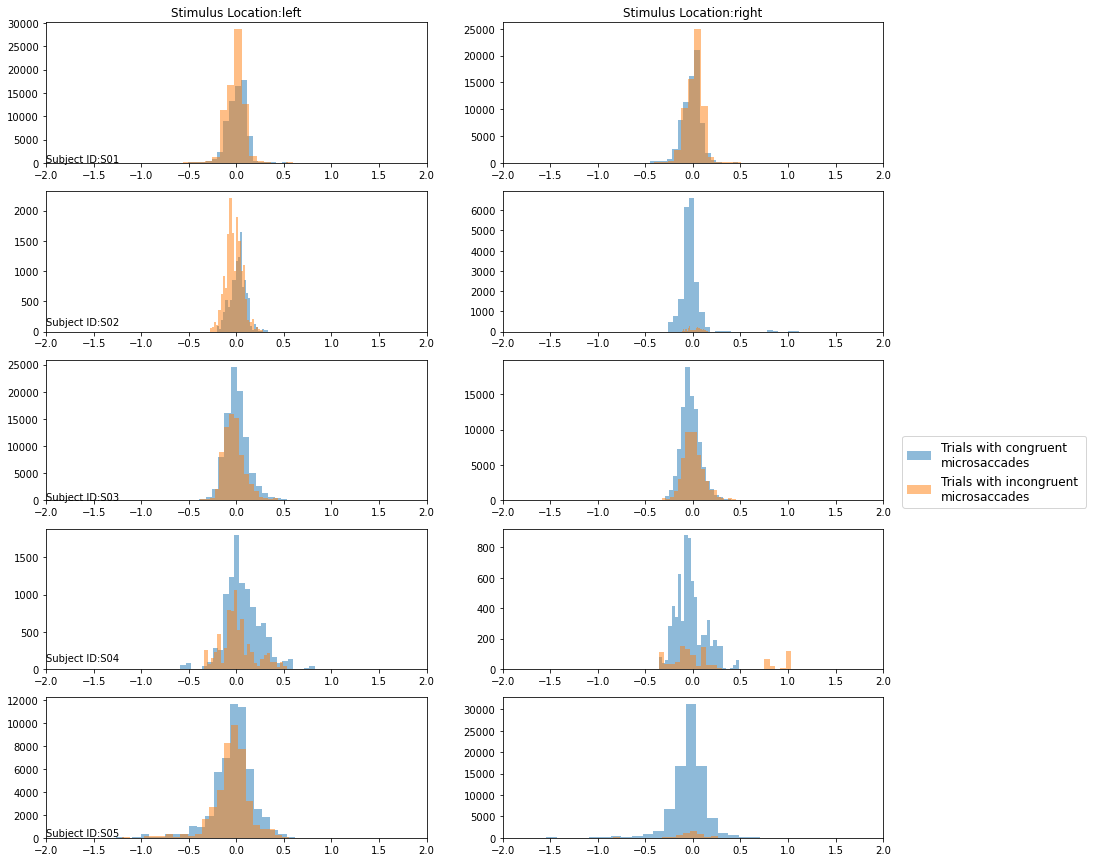

In [44]:
fig,ax=plt.subplots(nrows=5,ncols=2,figsize=(15,15))
subs=eyepos_rel.subj_id_x.unique()
subCounter=0
stimLocs_cols=eyepos_rel.stimLoc.unique()
for row in ax:
    asub=subs[subCounter]
    colCounter=0
    for col in row:
        stimLoc_cond=stimLocs_cols[colCounter]
        df1=eyepos_rel.query("congruency=='congruent' & @start_pt<relOnsetTime<@end_pt & stimLoc==@stimLoc_cond & subj_id_x==@asub")['xpos']
        col.hist(df1,alpha=0.5,color='C0',bins=25,label='Trials with congruent \nmicrosaccades')
        df2=eyepos_rel.query("congruency=='incongruent' & @start_pt<relOnsetTime<@end_pt & stimLoc==@stimLoc_cond & subj_id_x==@asub")['xpos']
        col.hist(df2,alpha=0.5,color='C1',bins=25,label='Trials with incongruent \nmicrosaccades')
        # plt.title('Horizontal eye positions between -400 - 157 ms relative to stimulus onset')
        col.set_xlim(-2,2)
        if subCounter==2 and colCounter==1:
            col.legend(bbox_to_anchor=(1.55,0.5),fontsize=12)
        if subCounter==0:
            col.set_title("Stimulus Location:%s"%(stimLoc_cond))
        if colCounter==0:
            col.text(col.get_xlim()[0],col.get_ylim()[0]+100,"Subject ID:%s"%(asub))
        colCounter+=1
    subCounter+=1
# plt.savefig("DirectionBiasBeforeSaccadeonset.pdf")

In [66]:
eyepos_rel.query("relOnsetTime<0").groupby(['stimLoc','subj_id_x','congruency'])['xpos'].mean()*60
# TO-do: Add eccentricity column

stimLoc  subj_id_x  congruency 
left     S01        congruent      -0.509433
                    incongruent    -0.610494
         S02        congruent      -0.753564
                    incongruent    -1.351809
         S03        congruent      -1.813248
                    incongruent    -0.844580
         S04        congruent      -8.913778
                    incongruent    -1.717382
         S05        congruent     -10.598287
                    incongruent    -5.914390
right    S01        congruent      -0.163521
                    incongruent     0.741424
         S02        congruent       0.987269
                    incongruent     3.957526
         S03        congruent       1.351163
                    incongruent     0.620452
         S04        congruent       4.381286
                    incongruent     6.162524
         S05        congruent       8.816650
                    incongruent    16.279238
Name: xpos, dtype: float64

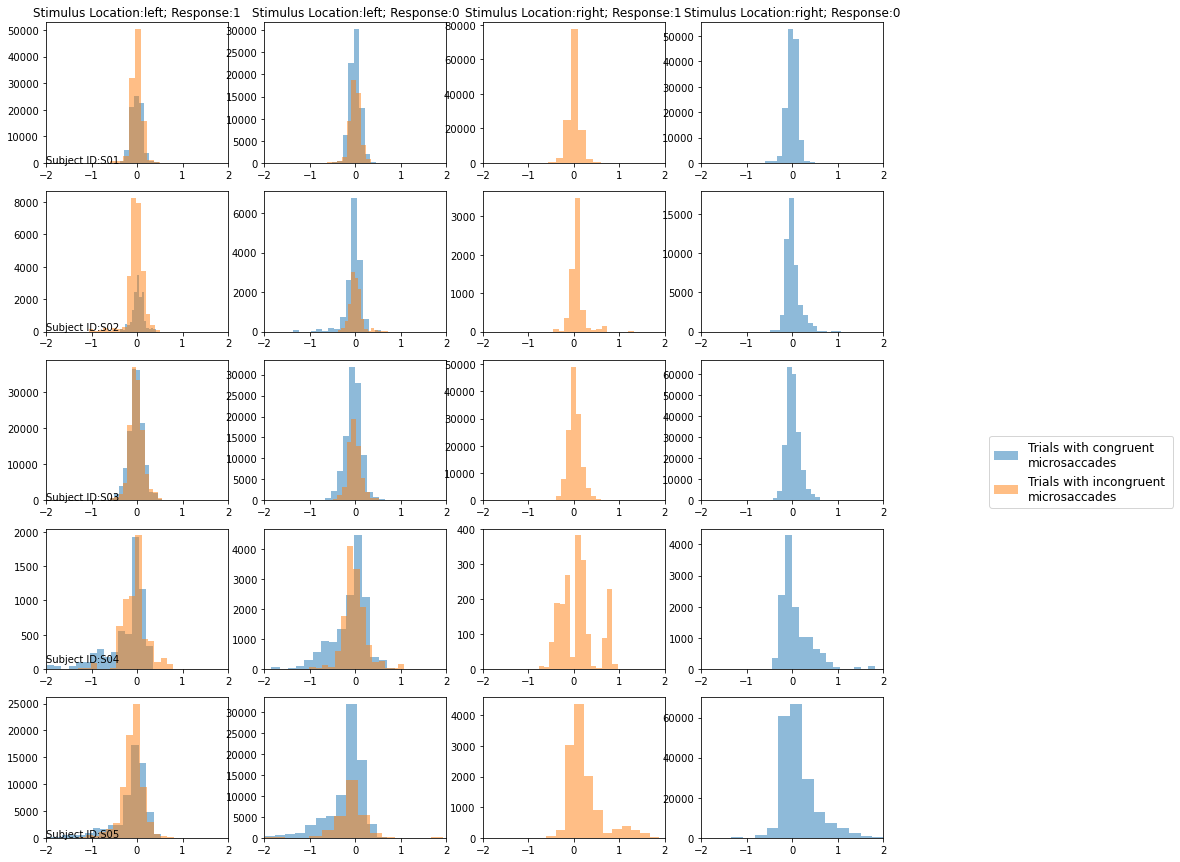

In [60]:
fig,ax=plt.subplots(nrows=5,ncols=4,figsize=(15,15))
subs=eyepos_rel.subj_id_x.unique()
subCounter=0
stimLocs_cols=['left','left','right','right']
response_cols=[1,0,1,0]
for row in ax:
    asub=subs[subCounter]
    colCounter=0
    for col in row:
        stimLoc_cond=stimLocs_cols[colCounter]
        response_cond=response_cols[colCounter]
        df1=eyepos_rel.query("congruency=='congruent' & relOnsetTime<0 & stimLoc==@stimLoc_cond & subj_id_x==@asub & corr==@response_cond")['xpos']
        col.hist(df1,alpha=0.5,color='C0',bins=15,label='Trials with congruent \nmicrosaccades')
        df2=eyepos_rel.query("congruency=='incongruent' & relOnsetTime<0 & stimLoc==@stimLoc_cond & subj_id_x==@asub & corr==@response_cond")['xpos']
        col.hist(df2,alpha=0.5,color='C1',bins=15,label='Trials with incongruent \nmicrosaccades')
        # plt.title('Horizontal eye positions between -400 - 157 ms relative to stimulus onset')
        col.set_xlim(-2,2)
        if subCounter==2 and colCounter==3:
            col.legend(bbox_to_anchor=(1.55,0.5),fontsize=12)
        if subCounter==0:
            col.set_title("Stimulus Location:%s; Response:%d"%(stimLoc_cond,response_cond))
        if colCounter==0:
            col.text(col.get_xlim()[0],col.get_ylim()[0]+100,"Subject ID:%s"%(asub))
        colCounter+=1
    subCounter+=1
plt.savefig("DirectionBiasBeforeSaccadeonset_byresp.pdf")

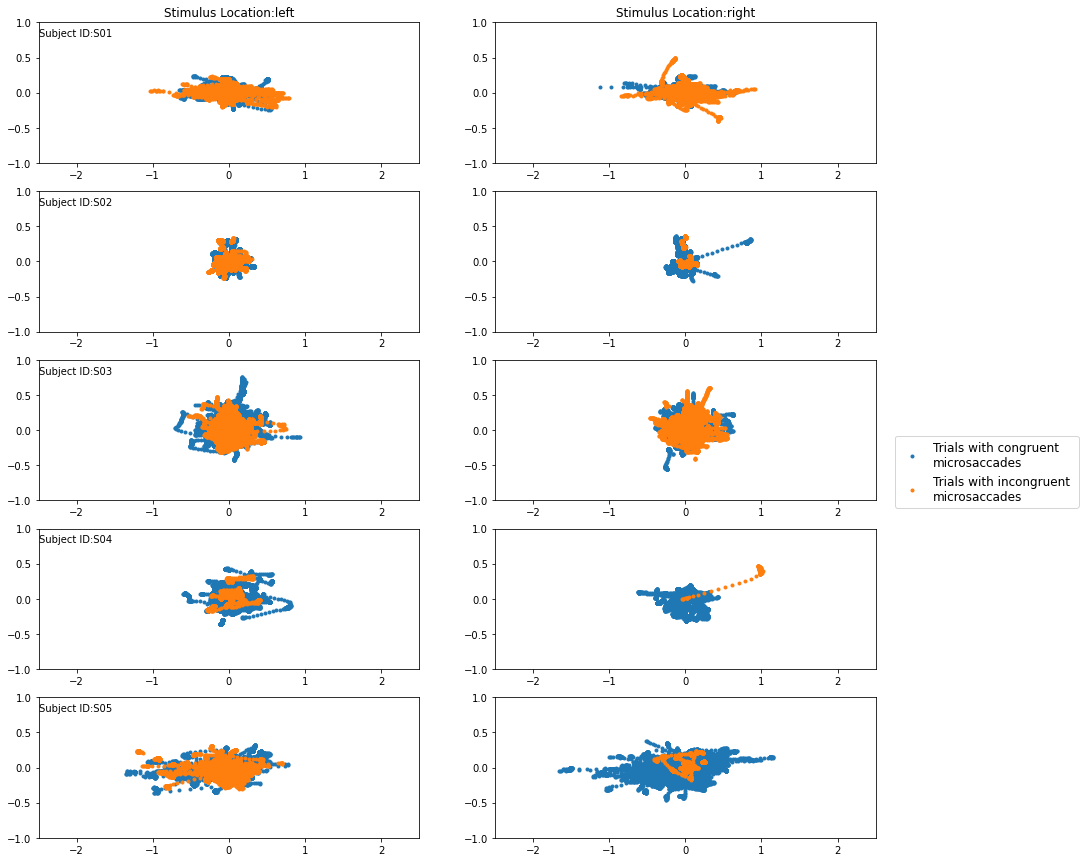

In [23]:
fig,ax=plt.subplots(nrows=5,ncols=2,figsize=(15,15))
subs=eyepos_rel.subj_id_x.unique()
subCounter=0
stimLocs_cols=eyepos_rel.stimLoc.unique()
for row in ax:
    asub=subs[subCounter]
    colCounter=0
    for col in row:
        stimLoc_cond=stimLocs_cols[colCounter]
        df1=eyepos_rel.query("congruency=='congruent' & @start_pt<relOnsetTime<@end_pt & stimLoc==@stimLoc_cond & subj_id_x==@asub")
        col.plot(df1['xpos'],df1['ypos'],linestyle='',marker='.',color='C0',label='Trials with congruent \nmicrosaccades')
        df2=eyepos_rel.query("congruency=='incongruent' & @start_pt<relOnsetTime<@end_pt & stimLoc==@stimLoc_cond & subj_id_x==@asub")
        col.plot(df2['xpos'],df2['ypos'],linestyle='',marker='.',color='C1',label='Trials with incongruent \nmicrosaccades')
        # plt.title('Horizontal eye positions between -400 - 157 ms relative to stimulus onset')
        col.set_xlim(-2.5,2.5)
        col.set_ylim(-1,1)
        if subCounter==2 and colCounter==1:
            col.legend(bbox_to_anchor=(1.55,0.5),fontsize=12)
        if subCounter==0:
            col.set_title("Stimulus Location:%s"%(stimLoc_cond))
        if colCounter==0:
            col.text(col.get_xlim()[0],col.get_ylim()[1]-0.2,"Subject ID:%s"%(asub))
        colCounter+=1
    subCounter+=1


In [ ]:
tempData=np.column_stack((onsetXpos,onsetYpos,offsetXpos,offsetYpos))
saccPosDF=pd.DataFrame(tempData)
saccPosDF.columns=['onsetX','onsetY','offsetX','offsetY']

In [ ]:
eyeposCode=eyeposRel['code'].unique()
numelements=len(eyeposCode)
counter=0
output={}
for acode in eyeposCode:
    update_progress(counter/numelements)
    counter+=1
    df=eyeposRel.query("code==@acode")
    dfmean=df.mean()[['xpos','ypos']]
    output[acode]=np.array(dfmean)
    eyeposRel.loc[eyeposRel.code==acode,'xpos']-=output[acode][0]
    eyeposRel.loc[eyeposRel.code==acode,'ypos']-=output[acode][1]

In [ ]:
saccCode=leftVrightData['trialCode'].unique()
stim_locs=['left','right']
response_cond=[0,1]
stim_locs_list=[]
response_list=[]
onsetXpos=[]
onsetYpos=[]
offsetXpos=[]
offsetYpos=[]
numelements=len(saccCode)*len(stim_locs)*len(response_cond)
counter=0
for acode in saccCode:
    for aloc in stim_locs:
        for aresp in response_cond:
            update_progress(counter/numelements)
            counter+=1
            acodeEyePos=acode[0:(acode.find('ecc_')+5)]
            eyeposDF=eyeposRel.query("code==@acodeEyePos")
            saccDF=leftVrightData.query("trialCode==@acode & stim_loc==@acode & corr==@aresp")
            for saccIdx in range(len(saccDF)):
                #from matlab algorithm (account for indexing differences)
                onsetIdx=int(saccDFincong.query("trialCode==@acode & stim_loc==@acode & corr==@aresp").iloc[saccIdx,1])-1
                offsetIdx=int(saccDFincong.query("trialCode==@acode & stim_loc==@acode & corr==@aresp").iloc[saccIdx,2])-1
                onsetX=eyeposDF.query("index==@onsetIdx").iloc[0,0]
                onsetY=eyeposDF.query("index==@onsetIdx").iloc[0,1]
                offsetX=eyeposDF.query("index==@offsetIdx").iloc[0,0]
                offsetY=eyeposDF.query("index==@offsetIdx").iloc[0,1]
                onsetXpos.append(onsetX)
                onsetYpos.append(onsetY)
                offsetXpos.append(offsetX)
                offsetYpos.append(offsetY)
                response_list.append(aresp)

tempData=np.column_stack((onsetXpos,onsetYpos,offsetXpos,offsetYpos,response_list))
saccPosDF=pd.DataFrame(tempData)
saccPosDF.columns=['onsetX','onsetY','offsetX','offsetY','cirr']
saccPosDF['onsetX']=saccPosDF['onsetX'].astype('float')
saccPosDF['onsetY']=saccPosDF['onsetY'].astype('float')
saccPosDF['offsetX']=saccPosDF['offsetX'].astype('float')
saccPosDF['offsetY']=saccPosDF['offsetY'].astype('float')
saccPosDF['corr']=saccPosDF['corr'].astype('float')

In [ ]:
saccDFincong=leftVrightData.query("0.2<relOnsetTime<0.4 & congruent==0")
stim_locs=['left','right']
response_cond=[0,1]
stim_locs_list=[]
response_list=[]
onsetXpos=[]
onsetYpos=[]
offsetXpos=[]
offsetYpos=[]
numelements=len(trialsWincong200to400)*len(stim_locs)*len(response_cond)
counter=0
for acode in trialsWincong200to400:
    for aloc in stim_locs:
        for aresp in response_cond:
            update_progress(counter/numelements)
            counter+=1
            acodeEyePos=acode[0:(acode.find('ecc_')+5)]
            eyeposDF=eyeposRel.query("code==@acodeEyePos")
            saccDF=saccDFincong.query("trialCode==@acode & stim_loc==@aloc & corr==@aresp")
            if len(saccDF)!=0:
                for saccIdx in range(len(saccDF)):
                    onsetIdx=int(saccDFincong.query("trialCode==@acode & stim_loc==@aloc & corr==@aresp").iloc[saccIdx,1])-1
                    offsetIdx=int(saccDFincong.query("trialCode==@acode & stim_loc==@aloc & corr==@aresp").iloc[saccIdx,2])-1
                    #from matlab algorithm (account for indexing differences)
                    onsetX=eyeposDF.query("index==@onsetIdx").iloc[0,0]
                    onsetY=eyeposDF.query("index==@onsetIdx").iloc[0,1]
                    offsetX=eyeposDF.query("index==@offsetIdx").iloc[0,0]
                    offsetY=eyeposDF.query("index==@offsetIdx").iloc[0,1]
                    onsetXpos.append(onsetX)
                    onsetYpos.append(onsetY)
                    offsetXpos.append(offsetX)
                    offsetYpos.append(offsetY)
                    stim_locs_list.append(aloc)
                    response_list.append(aresp)
        
tempData=np.column_stack((onsetXpos,onsetYpos,offsetXpos,offsetYpos,stim_locs_list,response_list))
saccPosIncongDF=pd.DataFrame(tempData)
saccPosIncongDF.columns=['onsetX','onsetY','offsetX','offsetY','stim_loc','corr']
saccPosIncongDF['onsetX']=saccPosIncongDF['onsetX'].astype('float')
saccPosIncongDF['onsetY']=saccPosIncongDF['onsetY'].astype('float')
saccPosIncongDF['offsetX']=saccPosIncongDF['offsetX'].astype('float')
saccPosIncongDF['offsetY']=saccPosIncongDF['offsetY'].astype('float')
saccPosIncongDF['corr']=saccPosIncongDF['corr'].astype('float')

In [ ]:
cond_query1="stim_loc=='left'"
df1=saccPosIncongDF.query(cond_query1)
fig, axs = plt.subplots(2,2,figsize=(15,15))
heatmap1, xedges1, yedges1 = np.histogram2d(df1['onsetX'],df1['onsetY'], bins=50)
extent1 = [xedges1[0], xedges1[-1], yedges1[0], yedges1[-1]]

heatmap2, xedges2, yedges2 = np.histogram2d(df1['offsetX'],df1['offsetY'], bins=50)
extent2 = [xedges2[0], xedges2[-1], yedges2[0], yedges2[-1]]

cond_query2="stim_loc=='right'"
df2=saccPosIncongDF.query(cond_query2)
heatmap3, xedges3, yedges3= np.histogram2d(df2['onsetX'],df2['onsetY'], bins=50)
extent3 = [xedges3[0], xedges3[-1], yedges3[0], yedges3[-1]]

heatmap4, xedges4, yedges4= np.histogram2d(df2['offsetX'],df2['offsetY'], bins=50)
extent4 = [xedges4[0], xedges4[-1], yedges4[0], yedges4[-1]]

# axs[0].clf()
axs[0,0].imshow(heatmap1.T, extent=extent1, origin='lower')
axs[0,0].set_title('Saccade Onset Position: %s'%(cond_query1))
axs[0,0].set(xlabel='Xpos(deg)',ylabel='Ypos (deg)',xlim=(-0.3,0.3),ylim=(-0.3,0.3))
axs[1,0].imshow(heatmap2.T, extent=extent2, origin='lower')
axs[1,0].set_title('Saccade Offset Position')
axs[1,0].set(xlabel='Xpos(deg)',ylabel='Ypos (deg)',xlim=(-0.3,0.3),ylim=(-0.3,0.3))

axs[0,1].imshow(heatmap3.T, extent=extent3, origin='lower')
axs[0,1].set_title('Saccade Onset Position: %s'%(cond_query2))
axs[0,1].set(xlabel='Xpos(deg)',ylabel='Ypos (deg)',xlim=(-0.3,0.3),ylim=(-0.3,0.3))
axs[1,1].imshow(heatmap4.T, extent=extent4, origin='lower')
axs[1,1].set_title('Saccade Offset Position')
axs[1,1].set(xlabel='Xpos(deg)',ylabel='Ypos (deg)',xlim=(-0.3,0.3),ylim=(-0.3,0.3))


# Amplitude binning method

In [ ]:
sns.lineplot(x='binPt',y='AmpVal',ci=95,data=BinnedData)
plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0],label='Stimulus Onset')
plt.ylabel('Saccade Amplitude (deg)')
plt.xlabel('Time from stimulus onset (s)')
plt.xlim(-0.4,0.6)
plt.ylim(0.15,0.4)
plt.legend()
plt.savefig('..\Plots\saccAmpVtimeBin.svg',format='svg',dpi=1200)

In [ ]:
sns.lineplot(x='binPt',y='AmpVal',hue='spacing_cond',ci=95,data=BinnedData)
plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0])
plt.ylabel('Saccade Amplitude (deg)')
plt.xlabel('Time from stimulus onset (s)')

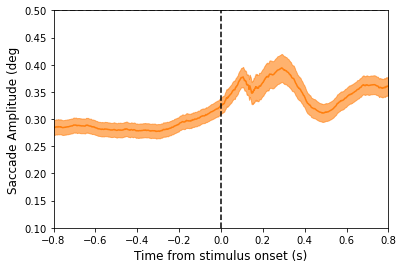

In [26]:
df_mean=BinnedData.groupby(['binPt'])['VectorAmp'].mean().reset_index()
# compute CI
df_std=BinnedData.groupby(['binPt'])['VectorAmp'].std().reset_index()
x=df_std['binPt']
y=df_std['VectorAmp']
ci=1.96 * (y)/np.sqrt(len(x))
plt.fill_between(x,(df_mean['VectorAmp']+ci),(df_mean['VectorAmp']-ci),color='C1',alpha=0.6)
plt.plot(df_mean['binPt'],df_mean['VectorAmp'],color='C1')
plt.ylim(0.1,0.5)
plt.xlim(-0.8,0.8)
plt.axvline(x=0,ymin=0,ymax=1,linestyle='--',color=[0,0,0])
plt.axhline(xmin=0,xmax=1,y=0.5,linestyle='--',color=[0,0,0],alpha=0.8)
plt.ylabel('Saccade Amplitude (deg)',size=12)
plt.xlabel('Time from stimulus onset (s)',size=12)

plt.savefig('..\Plots\saccAmpVtimeBin.svg',format='svg',dpi=1200)

In [ ]:
# We run permutation test for each time point/bin step 
bins=BinnedData.binPt.unique()
p_vals_amp=[]
idx=0
# loop through each bin
for abin in bins:
    print('%d/%d'%(idx,len(bins)-1),end='\r')
    idx+=1
    group1=BinnedData.query("binPt==@abin & ecc_cond=='parafoveal' & AmpVal>0")['AmpVal']
    group2=BinnedData.query("binPt==@abin & ecc_cond=='peripheral'& AmpVal>0")['AmpVal']
    res=perm_test(group1,group2,10000,'mean',z_score=False)
    # append P val
    p_vals_amp.append(res['p_val'])

In [ ]:
g=sns.lineplot(x='binPt',y='AmpVal',hue='ecc_cond',data=BinnedData)
g.legend(loc='best').texts[0].set_text("Target Eccentricity")
g.axes.axvline(x=0,ymin=0,ymax=1,linestyle='--',color=[0,0,0])
g.axes.set_ylim(0.15,0.4)
g.axes.set_ylabel('Saccade Amplitude (deg)')
g.axes.set_xlabel('Time from stimulus onset (s)')
# we plot significance over this
p_vals_amp=p_val_df['p_val_amp']
bins=p_val_df['binPt']
alpha_lvl=0.001
start_bins=[]
end_bins=[]
got_one=0
for idx in range(len(p_vals_amp)):
    a_pval=p_vals_amp[idx]
    abin=bins[idx]
    if a_pval<alpha_lvl and got_one==0:
        start_bins.append(abin)
        got_one=1
    elif a_pval>alpha_lvl and got_one==1:
        end_bins.append(abin)
        got_one=0
# We plot between the start and end of the region where it is significant
for idx in range(len(end_bins)):
    start_pt=start_bins[idx]
    end_pt=end_bins[idx]
    g.axes.fill_betweenx(y=[0,1],x1=start_pt,x2=end_pt,color=[0,0,0],alpha=0.1)    
# plt.savefig('..\Plots\saccAmpVtimeBin_byEccCond.svg',format='svg',dpi=1200)

In [ ]:
BinnedData.query("propCong<2")['propCong'].unique()

In [ ]:
g=sns.FacetGrid(data=BinnedData,hue='ecc',col='propCong',height=4,aspect=1)
g.map(sns.lineplot,'binPt','AmpVal',ci=None)
plt.legend()
# plt.axvline(x=0,ymin=0,ymax=1,ls='--',color=[0,0,0])
# plt.ylabel('Saccade Amplitude (deg)')
# plt.xlabel('Time from stimulus onset (s)')

In [ ]:
g=sns.FacetGrid(data=BinnedData,col='spacing',hue='ecc',height=5)
g.map(sns.lineplot,'binPt','AmpVal',ci=None)
plt.legend()

In [ ]:
g=sns.FacetGrid(data=BinnedData,col='ecc',row='spacing',height=5)
g.map(sns.lineplot,'binPt','AmpVal',ci=None)
plt.legend()

## Mislocalization Errors

In [ ]:
codeList=behavData.query("spacing!=100.0").code.unique()
misLoc=[]
for acode in codeList:
    tempData=behavData.query("code==@acode")
    # we get only the data from the last presentation and ignore the other ones
    lastStim=tempData.tail(1)
    behavResp=lastStim.resp.values[0]
    # we get the flankers used in that trial
    flankersUsed=[lastStim.outer.values[0],lastStim.up.values[0],lastStim.down.values[0]]
    # Eliminate trials where there was a correct response
    if lastStim.corr!=0:
        # check if the subject reported one of the flankers / mislocalization
        if behavResp in flankersUsed:
            if behavResp==lastStim.outer.values[0]:
                lastStim['misloc_pos']='outer'
            elif behavResp==lastStim.up.values[0]:
                lastStim['misloc_pos']='up'
            elif behavResp==lastStim.down.values[0]:
                lastStim['misloc_pos']='down'
            misLoc.append(lastStim)
mislocalizedTrials=pd.concat(misLoc)

In [ ]:
numErrors=len(behavData.query("corr==0"))
mislocalizedTrials['numErrors']=mislocalizedTrials['corr'].count()/numErrors
sns.barplot(x='misloc_pos',y='numErrors',data=mislocalizedTrials)
plt.ylabel('Proportion of \nmislocalization errors',size=12)
plt.xlabel('Flanker Mislocalized',size=12)

# PyMc3 modelling

In [ ]:
import pymc3 as pm
import arviz as az

In [ ]:
df=ampBin.query("0.150<binPt<0.250")

with pm.Model() as modelmlt:
    pm.glm.GLM.from_formula("AmpVal~ecc*subj_id",df)
    tracemlt=pm.sample(2000,cores=3)

In [ ]:
pm.traceplot(tracemlt)

In [ ]:
pm.summary(tracemlt,kind='stats')

In [ ]:
with pm.Model() as modeladd:
    pm.glm.GLM.from_formula("AmpVal~ecc+subj_id",df)
    traceadd=pm.sample(2000,cores=3)

In [ ]:
pm.traceplot(traceadd)

In [ ]:
pm.summary(traceadd,kind='stats')

In [ ]:
# bayesian comparison of the two models
pooled_add=az.loo(traceadd,modeladd)

pooled_add.loo

In [ ]:
pooled_mlt=az.loo(tracemlt,modelmlt)

pooled_mlt.loo

In [ ]:
df_comp_loo=az.compare({"multiply":tracemlt,"add":traceadd})
df_comp_loo

In [ ]:
az.plot_compare(df_comp_loo,insample_dev=False)

In [ ]:
df1=ampBin.query("-0.05<binPt<0.0")

with pm.Model() as modelColon:
    pm.glm.GLM.from_formula("AmpVal~ecc:subj_id",df1)
    traceColon=pm.sample(2000,cores=3)

In [ ]:
pm.traceplot(traceColon)

In [ ]:
pm.summary(traceColon,kind='stats')

## Permutation tests
Example are shown here

In [ ]:
# Permutation Test Example
# T score
crowdedData=BinnedData.query("0<binPt<0.1 and propCong<2 and spacing_cond=='close'")['propCong']
uncrowdedData=BinnedData.query("0<binPt<0.1 and propCong<2 and spacing_cond=='far'")['propCong']
    
res=perm_test(uncrowdedData,crowdedData,2000,'ttest')
print(res['p_val'])
plt.hist(res['k'],bins=10)
plt.axvline(x=res['diff'],ymin=0,ymax=1,color='k')

In [ ]:
num_perm=10000
c=BinnedPerfData.query("0.2<binPt<0.4 and sacc_cond=='Sacc' and congruent=='1' & meanPerf<2")['meanPerf']
t=BinnedPerfData.query("0.2<binPt<0.4 and sacc_cond=='Sacc' and congruent=='0' & meanPerf<2")['meanPerf']
res=perm_test(c,t,2000,'ftest')

In [130]:
# Common permutation test for all conditions
# We run permutation test for each time point/bin step 
bins=BinnedData.binPt.unique()
binPtList=[]
p_vals_perf=[]
p_vals_cong=[]
idx=0
# loop through each bin
for abin in bins:
    print('%d/%d'%(idx,len(bins)-1),end='\r')
    idx+=1
    # Performance permutation test [By Congruency]
#     group1_perf=(BinnedPerfData_sacc.query("binPt==@abin and congruent==1")['corr'])
#     group2_perf=(BinnedPerfData_sacc.query("binPt==@abin and congruent==0")['corr'])
#     res_perf=perm_test(group1_perf,group2_perf,10000,'mean',z_score=True)
    res_perf['p_val']=0
    # append P val
    p_vals_perf.append(res_perf['p_val'])
    # Congruency permutation test [By Spacing]
    group1=df.query("binPt_x==@abin")['propCong']
    group2=np.repeat(0.5,len(group1))
    res_cong=perm_test(group1,group2,10000,'mean',z_score=False)
    # append P val
    p_vals_cong.append(res_cong['p_val'])
    binPtList.append(abin)
p_val_df=pd.DataFrame(np.column_stack((binPtList,p_vals_perf,p_vals_cong)),columns=['binPt','p_val_perf','p_val_cong'])

## Data visualization
We use this to view the eye traces from each trial

In [ ]:
df=eyeposRel.query("code=='S01_S1_T001_ecc_1'")

In [ ]:
plt.scatter(df['x'])

In [ ]:
code='S01_S1_T003_ecc_5_39'

data=eyepos.query("trialCode==@code & time<76.679792")
# markerDataFiltered=stimTimes.query("code==@code")
SaccFiltered=saccData.query("trialCode==@code")
driftFiltered=driftData.query("trialCode==@code")
plt.figure(figsize=(20,10))
xdata=data['xpos']-data['xpos'].iloc[0]
ydata=data['ypos']-data['ypos'].iloc[0]
ax=plt.plot(xdata*60,ydata*60,'.-')
plt.plot(data['xpos'],data['ypos'],'.-')
# try:
#     ax=plt.axvline(x=markerDataFiltered['stimlusOnsetTime'][0],ymin=0,ymax=1,ls='--')
# except:
#     ax=plt.axvline(x=markerDataFiltered['stimlusOnsetTime'][1],ymin=0,ymax=1,ls='--')
if len(SaccFiltered)>0:
    for i in range(len(SaccFiltered)):
        startTime=SaccFiltered['onsetTime'].iloc[i]
        endTime=SaccFiltered['offsetTime'].iloc[i]
        filteredData=data.query("time>@startTime & time<@endTime")
        x=filteredData['xpos']
        y=filteredData['ypos']
        plt.plot(x,y,ls='-',color=[0,0,0],linewidth=5,label='Microsaccade' if i==0 else "")

if len(driftFiltered)>0:
    for k in range(len(driftFiltered)):
        startTime=driftFiltered['onsetTime'].iloc[k]
        endTime=driftFiltered['offsetTime'].iloc[k]
        filteredData=data.query("time>@startTime & time<@endTime")
        x=filteredData['xpos']
        y=filteredData['ypos']
        plt.plot(x,y,'o',color='C0',label='Drifts' if k==0 else "")
plt.legend()
plt.xlabel('X Position (arcmin)', size=18)
plt.ylabel('Y Position (arcmin)', size=18)

# plt.savefig('SampleEyeTrace2DwithEvents.pdf',bbox_tight=True)

In [ ]:
code='S01_S1_T003_ecc_5_39'
markerCode=code+'.0'
data=eyepos.query("trialCode==@code")
movieData=eyepos.query("code=='S01_S1_T003_ecc_5'")
data['xpos']=data['xpos']-movieData['xpos'].iloc[0]
data['ypos']=data['ypos']-movieData['ypos'].iloc[0]
SaccFiltered=saccData.query("trialCode==@code")
driftFiltered=driftData.query("trialCode==@code")
stimTime=stimData.query("trialCode==@markerCode")
plt.figure(figsize=(8,5))
plt.plot(data['time'],data['xpos'],'.-',label='Horizontal')
plt.plot(data['time'],data['ypos'],'.-',color='C1',label='Vertical')
ax=plt.axvline(x=stimTime['stimulusOnsetTime'].values,ymin=0,ymax=1,ls='--',label='Stimulus Onset')
#     ax1=plt.axvline(x=stimTime['cueOnsetTime'].values,ymin=0,ymax=1,color='k',ls='--',label='Cue Onset')
if len(SaccFiltered)>0:
    for i in range(len(SaccFiltered)):
        startTime=SaccFiltered['onsetTime'].iloc[i]
        endTime=SaccFiltered['offsetTime'].iloc[i]
        filteredData=data.query("time>@startTime & time<@endTime")
        x=filteredData['time']
        y1=filteredData['xpos']
        y2=filteredData['ypos']
        plt.plot(x,y1,'v',color='C0',label='Microsaccade' if i==0 else "")
        plt.plot(x,y2,'v',color='C1')

if len(driftFiltered)>0:
    for k in range(len(driftFiltered)):
        startTime=driftFiltered['onsetTime'].iloc[k]
        endTime=driftFiltered['offsetTime'].iloc[k]
        filteredData=data.query("time>@startTime & time<@endTime")
        x=filteredData['time']
        y1=filteredData['xpos']
        y2=filteredData['ypos']
        plt.plot(x,y1,'.',color='C0',label='Drifts' if k==0 else "")
        plt.plot(x,y2,'.',color='C1')
plt.xlabel('Time (s)',size=12)
plt.ylabel('Eye Position (degrees)',size=12)
plt.legend(loc='center right')


In [38]:
codeListTrial=eyepos['trialCode'].unique()

def plot_func_trial(code_idx):
    code=codeListTrial[int(code_idx)]
    print(code)
    data=eyepos.query("trialCode==@code")
    SaccFiltered=saccData.query("trialCode==@code")
    driftFiltered=driftData.query("trialCode==@code")
    stimTime=stimData.query("trialCode==@code")
    plt.figure(figsize=(8,5))
    plt.plot(data['time'],data['xpos'],'.-',label='Horizontal')
    plt.plot(data['time'],data['ypos'],'.-',color='C1',label='Vertical')
    ax=plt.axvline(x=stimTime['stimulusOnsetTime'].values,ymin=0,ymax=1,ls='--',label='Stimulus Onset')
#     ax1=plt.axvline(x=stimTime['cueOnsetTime'].values,ymin=0,ymax=1,color='k',ls='--',label='Cue Onset')
    if len(SaccFiltered)>0:
        for i in range(len(SaccFiltered)):
            startTime=SaccFiltered['onsetTime'].iloc[i]
            endTime=SaccFiltered['offsetTime'].iloc[i]
            filteredData=data.query("time>@startTime & time<@endTime")
            x=filteredData['time']
            y1=filteredData['xpos']
            y2=filteredData['ypos']
            plt.plot(x,y1,'v',color='C0',label='Microsaccade' if i==0 else "")
            plt.plot(x,y2,'v',color='C1')

    if len(driftFiltered)>0:
        for k in range(len(driftFiltered)):
            startTime=driftFiltered['onsetTime'].iloc[k]
            endTime=driftFiltered['offsetTime'].iloc[k]
            filteredData=data.query("time>@startTime & time<@endTime")
            x=filteredData['time']
            y1=filteredData['xpos']
            y2=filteredData['ypos']
            plt.plot(x,y1,'.',color='C0',label='Drifts' if k==0 else "")
            plt.plot(x,y2,'.',color='C1')
    plt.xlabel('Time (s)',size=12)
    plt.ylabel('Eye Position (degrees)',size=12)
    plt.legend(bbox_to_anchor=(1,1))
#     plt.savefig('SampleEyeTraceTrial.png',bbox_tight=True,dpi=300)

slider_max=len(codeListTrial)-1
interact(plot_func_trial, code_idx = widgets.FloatSlider(value=0,
                                               min=0,
                                               max=slider_max,
                                               step=1))

interactive(children=(FloatSlider(value=0.0, description='code_idx', max=23928.0, step=1.0), Output()), _dom_c…

<function __main__.plot_func_trial(code_idx)>

In [41]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
codeListTrial=eyepos['code'].unique()
def plot_func_trial(code_idx):
    code=codeListTrial[int(code_idx)]
    print(code)
    data=eyepos.query("code==@code")
    SaccFiltered=saccData.query("code==@code")
    driftFiltered=driftData.query("code==@code")
    stimTime=stimData.query("code==@code")
    plt.figure(figsize=(13,6))
    plt.plot(data['time'],data['xpos'],'.-',label='Horizontal')
    plt.plot(data['time'],data['ypos'],'.-',color='C1',label='Vertical')
    ax=[plt.axvline(x=anx,ymin=0,ymax=1,ls='--') for anx in stimTime['stimulusOnsetTime'].values]
    if len(SaccFiltered)>0:
        for i in range(len(SaccFiltered)):
            startTime=SaccFiltered['onsetTime'].iloc[i]
            endTime=SaccFiltered['offsetTime'].iloc[i]
            filteredData=data.query("time>@startTime & time<@endTime")
            x=filteredData['time']
            y1=filteredData['xpos']
            y2=filteredData['ypos']
            plt.plot(x,y1,'v',color='C0',label='Microsaccade' if i==0 else "")
            plt.plot(x,y2,'v',color='C1')

    if len(driftFiltered)>0:
        for k in range(len(driftFiltered)):
            startTime=driftFiltered['onsetTime'].iloc[k]
            endTime=driftFiltered['offsetTime'].iloc[k]
            filteredData=data.query("time>@startTime & time<@endTime")
            x=filteredData['time']
            y1=filteredData['xpos']
            y2=filteredData['ypos']
            plt.plot(x,y1,'.',color='C0',label='Drifts' if k==0 else "")
            plt.plot(x,y2,'.',color='C1')
#     plt.xlim(0,1.5)
    plt.xlabel('Time (s)',size=12)
    plt.ylabel('Eye Position (degrees)',size=12)
#     plt.legend(loc='best')
#     plt.savefig('SampleEyeTraceTrial.png',bbox_tight=True,dpi=300)

slider_max=len(codeListTrial)-1
interact(plot_func_trial, code_idx = widgets.FloatSlider(value=0,
                                               min=0,
                                               max=slider_max,
                                               step=1))

interactive(children=(FloatSlider(value=0.0, description='code_idx', max=480.0, step=1.0), Output()), _dom_cla…

<function __main__.plot_func_trial(code_idx)>